In [1]:
from ElephasReader import DataReader, utils

In [2]:
import pandas as pd
import pyodbc
import numpy as np
import string
import matplotlib.pyplot as plt
import datetime

In [3]:
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline = True, world_readable=True)

In [4]:
def add_zero(ticker_int):
    """adjust the ticker code to six digit format"""
    ticker_str = str(ticker_int)
    if len(ticker_str) < 6:
        ticker_str = '0' * (6 - len(ticker_str)) + ticker_str
    return ticker_str

# 1. query the data - skip if we want to import csv

## 1.1 zyyx data

In [ ]:
db_price = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                          'Server=192.168.0.157;'
                          'Database=zyyx2;'
                          'UID=sa01;PWD=sa01;')

cursor = db_price.cursor()

In [ ]:
sql_index_query = """
SELECT * 
FROM zyyx2.dbo.qt_idx_daily
WHERE 1=1
and index_code IN ('000905', '000300', '399303')
and trade_date > '2012-01-01'
"""

In [ ]:
price_index = pd.read_sql(sql_index_query, db_price)
# price index pivot
price_index_df = pd.pivot_table(price_index[["index_code", "trade_date", "tclose"]], "tclose", "trade_date", "index_code")
price_index_df.columns.name = None
return_index_df =  price_index_df.diff() / price_index_df.shift(1)
return_index_df.to_csv("return_index_df.csv")

In [ ]:
sql_price_query = """
SELECT trade_date, stock_code, tcap, tclose, amount, turnover_rate, matiply_ratio, backward_adjratio
FROM zyyx2.dbo.qt_stk_daily
WHERE 1=1
--and stock_code IN ({})
and tcap > 50000
and is_valid = 1
and trade_date > '2011-01-01'
"""

In [ ]:
# grab the data and do some adjustment
## price = pd.read_sql(sql_price_query.format(",".join(metadata["ticker"].unique().tolist())), db_price)
price = pd.read_sql(sql_price_query, db_price)
# price.sort_values("trade_date", inplace = True)
price["back_adj"] = price["tclose"] / price["backward_adjratio"]
price["forward_adj"] = price["tclose"] * price["matiply_ratio"]
# price = price[price["stock_code"].isin(metadata["ticker"].unique().tolist())]
# keep a copy
price.to_csv("price.csv")

In [ ]:
# price pivot
price_df = pd.pivot_table(price[["stock_code", "trade_date", "forward_adj"]], "forward_adj", "trade_date", "stock_code")
price_df.columns.name = None
price_df = price_df.replace(0.0, np.nan)
# market cap data
tcap_df = pd.pivot_table(price[["stock_code", "trade_date", "tcap"]], "tcap", "trade_date", "stock_code")
turnover_df = pd.pivot_table(price[["stock_code", "trade_date", "turnover_rate"]], "turnover_rate", "trade_date", "stock_code")
adv_df = pd.pivot_table(price[["stock_code", "trade_date", "amount"]], "amount", "trade_date", "stock_code")
## adv_df = pd.pivot_table(price[["stock_code", "trade_date", "amount"]], "amount", "trade_date", "stock_code")

# return data
return_df = price_df.diff() / price_df.shift(1)
return_df_alpha300 = return_df.sub(return_index_df["000300"], axis = 0)
return_df_alpha500 = return_df.sub(return_index_df["000905"], axis = 0)
return_df_alpha2000 = return_df.sub(return_index_df["399303"], axis = 0)

In [ ]:
# ipo information
ipo_df = DataReader.get_ipo_date()
ipo_df["ticker"] = ipo_df.apply(lambda x: x["stock_code"][:-3], axis = 1)
ipo_df.to_csv("ipo_df.csv")

In [ ]:
sql_industry_query = """
SELECT * 
FROM zyyx2.dbo.qt_indus_constituents
where standard_name = N'申银万国一级行业' and use_status = 1
"""

In [ ]:
# grab the data and do some adjustment
industry_df = pd.read_sql(sql_industry_query, db_price)
#keep a copy
industry_df.to_csv("industry_df.csv")

In [ ]:
sql_cons_query = """
SELECT x.stock_code, x.con_date, x.con_rating_strength, x.con_rating_type, y.*
FROM zyyx2.dbo.con_rating_stk x
LEFT JOIN zyyx2.dbo.con_forecast_roll_stk y 
ON x.stock_code = y.stock_code AND x.con_date = y.con_date 

WHERE 1=1
-- and x.stock_code IN ({})
and x.con_date > '2012-01-01'
"""

In [ ]:
# grab the data and do some adjustment
con_df = pd.read_sql(sql_cons_query, db_price)
#con_df = con_df[con_df["stock_code"].isin(metadata["ticker"].unique().tolist())]
# keep a copy
con_df.iloc[:, 1:].to_csv("con_df.csv")

In [ ]:
con_df.to_csv("con_df.csv")

In [ ]:
db_price_ys2 = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                          'Server=192.168.0.157;'
                          'Database=zyyx_ys2;'
                          'UID=sa01;PWD=sa01;')

cursor = db_price_ys2.cursor()

In [ ]:
sql_coverage_query = """
SELECT x.stock_code, x.con_date, x.organ_num_q, a.diver
FROM zyyx_ys2.dbo.der_report_num x 
LEFT JOIN (
SELECT stock_code, con_date, avg(eps_diver) as diver
FROM zyyx_ys2.dbo.der_diver_stk 
WHERE YEAR(con_date) = con_year - 1 or YEAR(con_date) = con_year
group by stock_code, con_date ) a 
ON x.stock_code = a.stock_code AND x.con_date = a.con_date 

WHERE 1=1
-- and x.stock_code IN ({})
and x.con_date > '2012-01-01'
"""

In [ ]:
# grab the data and do some adjustment
coverage_df = pd.read_sql(sql_coverage_query, db_price_ys2)
#coverage_df = coverage_df[coverage_df["stock_code"].isin(metadata["ticker"].unique().tolist())]
# keep a copy
coverage_df.to_csv("coverage_df.csv")

In [ ]:
# combine 
con_df_combined = con_df.merge(coverage_df, how = 'left', on = ["stock_code", "con_date"])
con_df_combined.to_csv("con_df_combined.csv")

## 1.2 jydb data

In [ ]:
db_jy = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                          'Server=192.168.0.157;'
                          'Database=jydb;'
                          'UID=sa01;PWD=sa01;')

cursor = db_jy.cursor()

In [ ]:
info_query = """
select *
from jydb.dbo.SecuMain
"""

In [ ]:
#earning release data
info_df = pd.read_sql(info_query, db_jy)
info_df.to_csv("info_df.csv")

In [ ]:
sql_earning_query = """
(SELECT distinct InfoPublDate, a.EndDate, b.SecuCode, 'Full' as "Type"
FROM jydb.dbo.DZ_IncomeStatementAll a
left join jydb.dbo.SecuMain b
on a.CompanyCode = b.CompanyCode

) 

UNION

(SELECT distinct InfoPublDate, a.EndDate, b.SecuCode, 'Short' as "Type"
FROM jydb.dbo.DZ_FSPerformedLetters a
left join jydb.dbo.SecuMain b
on a.CompanyCode = b.CompanyCode)

UNION

(SELECT distinct InfoPublDate, a.EndDate, b.SecuCode, 'Forecast' as "Type"
FROM jydb.dbo.DZ_PerformanceForecast a
left join jydb.dbo.SecuMain b
on a.CompanyCode = b.CompanyCode)

"""

In [ ]:
#earning release data
earning_df = pd.read_sql(sql_earning_query, db_jy)
earning_df.columns = ["publish_date", "end_date", "ticker", "type"]
earning_df.sort_values(["ticker", "end_date", "publish_date"], inplace = True)
#earning_df = earning_df[earning_df["ticker"].isin(metadata["ticker"].unique().tolist())]
earning_df = earning_df[earning_df["publish_date"] > pd.Timestamp(2012,1,1)]


In [ ]:

earning_df = earning_df.groupby(["ticker", "end_date"]).apply(lambda x: x.iloc[0])
earning_df = earning_df.set_index("ticker")["publish_date"].reset_index().drop_duplicates()
earning_df = earning_df.sort_values(["ticker", "publish_date"])
# keep a copy
earning_df.to_csv("earning_df.csv")

In [ ]:
def get_suspend_df(ref_df):
    """
    generate dataframe with suspension dates and ticker
    :params
        ref_df: mainly just use the index
    """
    suspend_df_list = []
    for date in ref_df.index:
        df = DataReader.get_suspended(date.to_pydatetime())["stock_code"].to_frame()
        df["ticker"] = df.apply(lambda x: x["stock_code"][:6], axis = 1)
        df["trade_date"] = date
        df["suspend"] = 1
        suspend_df_list.append(df)
    return pd.concat(suspend_df_list, axis = 0).reset_index(drop = True)

In [ ]:
# suspension data
suspend_df = get_suspend_df(price_df)
suspend_df.to_csv("suspend_df.csv")

In [ ]:
def get_st_df(ref_df):
    """
    generate dataframe with st dates and ticker
    :params
        ref_df: mainly just use the index
    """
    st_df_list = []
    for date in ref_df.index:
        df = DataReader.get_st(date.to_pydatetime())["stock_code"].to_frame()
        df["ticker"] = df.apply(lambda x: x["stock_code"][:6], axis = 1)
        df["trade_date"] = date
        df["st"] = 1
        st_df_list.append(df)
    return pd.concat(st_df_list, axis = 0).reset_index(drop = True)

In [ ]:
# st data
st_df = get_st_df(price_df)
st_df.to_csv("st_df.csv")

## 1.3 just import the csv

### index return data

In [5]:
return_index_df = pd.read_csv("return_index_df.csv")
return_index_df["trade_date"] = return_index_df.apply(lambda x: pd.Timestamp(x["trade_date"]), axis = 1)
return_index_df.set_index("trade_date", inplace = True)

### price, return, market cap

In [6]:
price = pd.read_csv("price.csv")
price["trade_date"] = price.apply(lambda x: pd.Timestamp(x["trade_date"]), axis = 1)
price["stock_code"] = price.apply(lambda x: add_zero(x["stock_code"]), axis = 1)

# price pivot
price_df = pd.pivot_table(price[["stock_code", "trade_date", "forward_adj"]], "forward_adj", "trade_date", "stock_code")
price_df.columns.name = None
price_df = price_df.replace(0.0, np.nan)
# market cap data
tcap_df = pd.pivot_table(price[["stock_code", "trade_date", "tcap"]], "tcap", "trade_date", "stock_code")
turnover_df = pd.pivot_table(price[["stock_code", "trade_date", "turnover_rate"]], "turnover_rate", "trade_date", "stock_code")
adv_df = pd.pivot_table(price[["stock_code", "trade_date", "amount"]], "amount", "trade_date", "stock_code")
## adv_df = pd.pivot_table(price[["stock_code", "trade_date", "amount"]], "amount", "trade_date", "stock_code")

# return data
return_df = price_df.diff() / price_df.shift(1)
return_df_alpha300 = return_df.sub(return_index_df["000300"], axis = 0)
return_df_alpha500 = return_df.sub(return_index_df["000905"], axis = 0)
return_df_alpha2000 = return_df.sub(return_index_df["399303"], axis = 0)

### IPO

In [7]:
ipo_df = pd.read_csv("ipo_df.csv")
ipo_df["ticker"] = ipo_df.apply(lambda x: add_zero(x["ticker"]), axis = 1)
ipo_df["list_date"] = ipo_df.apply(lambda x: pd.Timestamp(x["list_date"]), axis = 1)
ipo_df["delist_date"] = ipo_df.apply(lambda x: pd.Timestamp(x["delist_date"]), axis = 1)

### ticker info

In [8]:
info_df = pd.read_csv("info_df.csv")

### industry

In [9]:
industry_df = pd.read_csv("industry_df.csv")
industry_df["stock_code"] = industry_df.apply(lambda x: add_zero(x["stock_code"]), axis = 1)

### consensus data

In [10]:
con_df_combined = pd.read_csv("con_df_combined.csv")
con_df_combined["con_date"] = con_df_combined.apply(lambda x: pd.Timestamp(x["con_date"]), axis = 1)
con_df_combined["stock_code"] = con_df_combined.apply(lambda x: add_zero(x["stock_code"]), axis = 1)

### earning event data

In [11]:
earning_df = pd.read_csv("earning_df.csv")
earning_df["publish_date"] = earning_df.apply(lambda x: pd.Timestamp(x["publish_date"]), axis = 1)
earning_df["ticker"] = earning_df.apply(lambda x: add_zero(x["ticker"]), axis = 1)

### suspension data

In [12]:
suspend_df = pd.read_csv("suspend_df.csv")
suspend_df["ticker"] = suspend_df.apply(lambda x: add_zero(x["ticker"]), axis = 1)
suspend_df["trade_date"] = suspend_df.apply(lambda x: pd.Timestamp(x["trade_date"]), axis = 1)

### st data

In [13]:
st_df = pd.read_csv("st_df.csv")
st_df["ticker"] = st_df.apply(lambda x: add_zero(x["ticker"]), axis = 1)
st_df["trade_date"] = st_df.apply(lambda x: pd.Timestamp(x["trade_date"]), axis = 1)

# 2. brd metadata

## 2.1 build the metadata from scratch

In [ ]:
# metadata and adjust the ticker to the right format
# only look at the brd data for now
metadata = pd.read_csv("Astock_ECM_BRD_HISTORY_TO_20220316_CN_Meta_COMPANY_RESULT3.csv")
metadata = metadata[metadata["typesOfInvestorRelationsActivities"] == "brd"]
metadata["ticker"] = metadata.apply(lambda x: add_zero(x["Stockcode"]), axis = 1)


In [ ]:
def publish_date_transform(date_string):
    try:
        date = pd.Timestamp(datetime.datetime.strptime(date_string, "%d/%m/%Y %H:%M:%S"))
    except: 
        date = pd.Timestamp(datetime.datetime.strptime(date_string[:-7], "%d/%m/%Y %H:%M:%S"))
        
    if date.month >= 4 and date.month <= 10:
        date += pd.Timedelta(hours = 7)
    else:
        date += pd.Timedelta(hours = 8)
        
    if date.hour < 14:
        date = date - pd.Timedelta(days = 1)
        
    return pd.Timestamp(date.year, date.month, date.day)
    
        
    

In [ ]:
# reassign the roadshow on the weekend to Monday
metadata["publish_date"] = metadata.apply(lambda x: publish_date_transform(x["publish"]) + \
                                          pd.Timedelta(days = 7 - publish_date_transform(x["publish"]).weekday()) \
                                          if publish_date_transform(x["publish"]).weekday() > 4 else publish_date_transform(x["publish"]),\
                                          axis = 1)

In [ ]:
# merge on transcript id
metadata = pd.merge(metadata, nlp[["transcriptuniqueid", "label_mean_val"]], how = 'left', on= "transcriptuniqueid")
# then take the average score by day
nlp_score = metadata.groupby(["ticker", "publish_date"])["label_mean_val"].mean().to_frame().reset_index()

In [ ]:
# drop the duplicates then remerge
metadata = metadata.loc[metadata[["ticker", "publish_date"]].drop_duplicates().index]
del metadata["label_mean_val"]
metadata = pd.merge(metadata, nlp_score, how = 'left', on= ["ticker", "publish_date"])

In [ ]:
# sort the data
metadata.sort_values(["ticker", "publish_date"], inplace = True)

### - check ST, suspension

In [ ]:
# assume trade_date is one biz day after publish date
date_df = price_df.index.to_frame().reset_index(drop = True)
date_df.columns = ["publish_date"]
date_df["trade_date"] = date_df["publish_date"].shift(-1)
metadata = pd.merge(metadata, date_df, how = 'left', on = "publish_date")

In [ ]:
# add suspend info
metadata = pd.merge(metadata, suspend_df[["ticker", "trade_date", "suspend"]], on = ["ticker", "trade_date"], how = "left")

In [ ]:
# add st info
metadata = pd.merge(metadata, st_df[["ticker", "trade_date", "st"]], on = ["ticker", "trade_date"], how = "left")

### - visitors: number and type

In [ ]:
def list_length(string):
    if string == '[]':
        return 0
    else:
        try:
            return len(string.split(","))
        except:
            return 0

In [ ]:
metadata["num_visitors"] = metadata["company_names"].apply(lambda x: list_length(x))

In [ ]:
def org_in_series(string, org_series):
    if string == "[]" or type(string) == float:
        return False
    for org in org_series:
        if org in string:
            return True
    return False

In [ ]:
mutual_list = pd.read_excel("Funds.xlsx", sheet_name = "Mutual", header = 2)["Name"]
broker_list = pd.read_excel("Funds.xlsx", sheet_name = "Securities", header = 2)["Name"]

In [ ]:
metadata["mutual"] = metadata.apply(lambda x: org_in_series(x["company_names"], mutual_list), axis = 1)

In [ ]:
metadata["broker"] = metadata.apply(lambda x: org_in_series(x["company_names"], broker_list), axis = 1) | metadata.apply(lambda x: '证券' in x["company_names"] if type(x["company_names"]) != float else False, axis = 1)

In [ ]:
metadata["foreign"] = metadata.apply(lambda x: org_in_series(x["company_names"], list(string.ascii_lowercase) + list(string.ascii_uppercase)), axis = 1)

### - gap between events

In [ ]:
def last_earning_date(earning_df, ref_date, ticker):
    
    try:
        last_earning_day = earning_df[(earning_df["publish_date"] <= ref_date) & (earning_df["ticker"] == ticker)].iloc[-1]["publish_date"]
        return last_earning_day
    except:
        return None    

In [ ]:
def gap_days_since_last_earning(earning_df, ref_date, ticker):
    """
    earning_df needs to be sorted
    return the gap of days between ref_date and last earning
    if the ref_date happens to be an earning, we see it as zero
    """
    try:
        last_earning_day = last_earning_date(earning_df, ref_date, ticker)
#         earning_df[(earning_df["publish_date"] <= ref_date) & (earning_df["ticker"] == ticker)].iloc[-1]["publish_date"]
        return (ref_date - last_earning_day).days
    except:
        return None

In [ ]:
def gap_days_to_next_earning(earning_df, ref_date, ticker):
    """
    earning_df needs to be sorted
    return the gap of days between ref_date and next earning
    if the ref_date happens to be an earning, we look to the next
    """
    try:
        next_earning_day = earning_df[(earning_df["publish_date"] > ref_date) & (earning_df["ticker"] == ticker)].iloc[0]["publish_date"]
        return (next_earning_day - ref_date).days
    except:
        return None

In [ ]:
# calculate the gap since last meeting
def gap_days_since_last_brd(fundamental_df):
    """
    add the days gap column by doing some dataframe manipulation
    return the panda series to be int where there is data, or None where is no earlier data
    """
    
    fundamental_df_sorted = fundamental_df.sort_values(["ticker", "publish_date"])
    date_diff_timestamp = fundamental_df_sorted["publish_date"] -  fundamental_df_sorted.shift(1)["publish_date"]
    ticker_diff = fundamental_df_sorted["ticker"] ==  fundamental_df_sorted.shift(1)["ticker"]
    
    date_diff_days = date_diff_timestamp.apply(lambda x: x.days if type(x) == pd.Timedelta else None)
    date_diff_days[ticker_diff == False] = None
    return date_diff_days

In [ ]:
# calculate the gap since last meeting
def gap_days_brd_shift_diff(fundamental_df, count):
    """
    add the days gap column by doing some dataframe manipulation
    return the panda series to be int where there is data, or None where is no earlier data
    """
    
    fundamental_df_sorted = fundamental_df.sort_values(["ticker", "publish_date"])
    brd_shift = fundamental_df_sorted["days_since_last_brd"].replace(np.nan, 0.0) -  fundamental_df_sorted["days_since_last_brd"].replace(np.nan, 0.0).shift(count)
    ticker_diff = fundamental_df_sorted["ticker"] == fundamental_df_sorted.shift(count)["ticker"]
    
    brd_shift[ticker_diff == False] = None
    return brd_shift

In [ ]:
def avg_brd_lookback(fundamental_df, ipo_date, ticker, ref_date, lookback):
    try:
        real_lookback = min(lookback, (ref_date - ipo_date.loc[ticker]).days)
        return fundamental_df[(fundamental_df["ticker"] == ticker) & (fundamental_df["publish_date"] <= ref_date) & (fundamental_df["publish_date"] >= ref_date - pd.Timedelta(days = real_lookback))].shape[0] / real_lookback
    except:
        return None
    
    

In [ ]:
def reset_cumsum_above_gap(data_series, gap, diviser):
    """
    reset the cumsum at nan, and divide by a diviser
    params:
        gap - minimum number to reset the cumsum
    """
    v = data_series.copy()
    v[v > gap] = None
    v_fill = v.cumsum().fillna(method = 'pad')
    reset = -v_fill[v.isnull()].diff().fillna(v_fill)
    result = v.where(v.notnull(), reset).cumsum() // diviser
    result[result.isnull()] = 0 # initial consecutive nan to be assigned none, so change to 0
    return result

In [ ]:
def reset_count_above_gap(data_series, gap):
    """
    reset the count at nan, and divide by a diviser
    params:
        gap - minimum number to reset the cumsum
    """
    v = data_series.copy()
    v[v > gap] = None
    v[v.notnull()] = 1.0
    v_fill = v.cumsum().fillna(method = 'pad')
    reset = -v_fill[v.isnull()].diff().fillna(v_fill)
    result = v.where(v.notnull(), reset).cumsum()
    result[result.isnull()] = 0 # initial consecutive nan to be assigned none, so change to 0
    return result

In [ ]:
def reset_count_after_earning(data_series, earning_series):
    """
    reset the count at nan, and divide by a diviser
    params:
        gap - minimum number to reset the cumsum
    """
    v = data_series.copy()
    v[earning_series.diff() != pd.Timedelta(days=0) ] = None
    v[v.notnull()] = 1.0
    v_fill = v.cumsum().fillna(method = 'pad')
    reset = -v_fill[v.isnull()].diff().fillna(v_fill)
    result = v.where(v.notnull(), reset).cumsum()
    result[result.isnull()] = 0 # initial consecutive nan to be assigned none, so change to 0
    return result

In [ ]:
def apply_number(row, num):
    try:
        return row.iloc[num]
    except:
        pass

In [ ]:
metadata["days_since_last_brd"] = gap_days_since_last_brd(metadata)

In [ ]:
metadata["reset_cumsum_180d_div7"] = metadata.groupby("ticker").apply(lambda x: reset_cumsum_above_gap(x["days_since_last_brd"], 180, 7)).values

In [ ]:
metadata["reset_cumsum_120d_div7"] = metadata.groupby("ticker").apply(lambda x: reset_cumsum_above_gap(x["days_since_last_brd"], 120, 7)).values

In [ ]:
metadata["reset_count_180d"] = metadata.groupby("ticker").apply(lambda x: reset_count_above_gap(x["days_since_last_brd"], 180)).values

In [ ]:
metadata["reset_count_120d"] = metadata.groupby("ticker").apply(lambda x: reset_count_above_gap(x["days_since_last_brd"], 120)).values

In [ ]:
metadata["days_since_last_earning"] = metadata.apply(lambda x: gap_days_since_last_earning(earning_df, x["publish_date"], x["ticker"]), axis = 1)

In [ ]:
metadata["days_to_next_earning"] = metadata.apply(lambda x: gap_days_to_next_earning(earning_df, x["publish_date"], x["ticker"]), axis = 1)

In [ ]:
metadata["position_in_earning"] = metadata["days_since_last_earning"] / (metadata["days_since_last_earning"] + metadata["days_to_next_earning"])

In [ ]:
metadata["gap_between_earning"] = metadata["days_since_last_earning"] + metadata["days_to_next_earning"] 

In [ ]:
metadata["last_earning"] = metadata.apply(lambda x: x["publish_date"] - pd.Timedelta(days=x["days_since_last_earning"]) if x["days_since_last_earning"] >= 0 else None, axis = 1)

In [ ]:
metadata["reset_count_earning"] = metadata.groupby("ticker").apply(lambda x: reset_count_after_earning(x["days_since_last_earning"], x["last_earning"])).values

### - period dummy

In [ ]:
# period dummy
metadata["year"] = metadata.apply(lambda x: x["publish_date"].year, axis = 1)
metadata["quarter"] = metadata.apply(lambda x: (x["publish_date"].month - 1) // 3 + 1, axis = 1)
metadata["month"] = metadata.apply(lambda x: x["publish_date"].month, axis = 1)

### - industry dummy

In [ ]:
# merge industry information
metadata = pd.merge(metadata, industry_df[["stock_code", "industry_name"]].rename({"stock_code": "ticker"}, axis = 1), how = "left", on = ["ticker"])

### - ipo date

In [ ]:
# ipo date
metadata = metadata.merge(ipo_df[["ticker", "list_date", "delist_date"]], on = "ticker", how = "left")

### - factors

#### - size

In [ ]:
def calc_spot_df(ticker, ref_date, df) -> float:
    """
    calculate matching data in the dataframe the day before 
    params:
    return_df: index is date in the ref_date format, columns are ticker
    """
    try:
        return df.loc[:ref_date, ticker].iloc[-2]
    except:
        return None

In [ ]:
metadata["tcap"] = metadata.apply(lambda x: calc_spot_df(x["ticker"], x["publish_date"], tcap_df), axis = 1)

#### - adv

In [ ]:
def calc_mean_df(ticker, ref_date, look_back: int, df) -> float:
    """
    calculate average value with certain look_back, excluding the ref_date
    params:
    return_df: index is date in the ref_date format, columns are ticker
    """
    try:
        return df.loc[:ref_date, ticker][-look_back:-1].mean()
    except:
        return None

In [ ]:
metadata["adv_30d"] = metadata.apply(lambda x: calc_mean_df(x["ticker"], x["publish_date"], 30, adv_df), axis = 1)

#### - turnover

In [ ]:
metadata["turnover_30d"] = metadata.apply(lambda x: calc_mean_df(x["ticker"], x["publish_date"], 30, turnover_df), axis = 1)

#### - vol

In [ ]:
def calc_std_df(ticker, ref_date, look_back: int, df) -> float:
    """
    calculate normal volatility with certain look_back, excluding the ref_date
    params:
    return_df: index is date in the ref_date format, columns are ticker
    """
    try:
        return df.loc[:ref_date, ticker][-look_back:-1].std()
    except:
        return None

In [ ]:
metadata["vol_60d"] = metadata.apply(lambda x: calc_std_df(x["ticker"], x["publish_date"], 60, return_df), axis = 1)
metadata["vol_20d"] = metadata.apply(lambda x: calc_std_df(x["ticker"], x["publish_date"], 20, return_df), axis = 1)

#### - momentum

In [ ]:
# add pre event return data
def calc_back_return(ticker, ref_date, length, leave, return_df):
    """
    calculate the return data from ref_date for a certain length backwards leave a certain days
    """
    try:
        return (1+return_df.loc[:ref_date, ticker].iloc[-int(length) - leave: -leave]).cumprod().ffill().iloc[-1]-1
    except:
        return None
    

In [ ]:
metadata["return_alpha500_40d_1d"] = metadata.apply(lambda x: calc_back_return(x["ticker"], x["publish_date"], 40, 1, return_df_alpha500), axis = 1)

In [ ]:
metadata["return_alpha500_5d_1d"] = metadata.apply(lambda x: calc_back_return(x["ticker"], x["publish_date"], 5, 1, return_df_alpha500), axis = 1)

In [ ]:
metadata["return_abs_20d_1d"] = metadata.apply(lambda x: calc_back_return(x["ticker"], x["publish_date"], 20, 1, return_df), axis = 1)

In [ ]:
metadata["return_abs_120d_20d"] = metadata.apply(lambda x: calc_back_return(x["ticker"], x["publish_date"], 120, 10, return_df), axis = 1)

#### - technical

In [ ]:
def get_macd(price_df, slow, fast, smooth):
    exp1 = price_df.ewm(span = fast, adjust = False).mean()
    exp2 = price_df.ewm(span = slow, adjust = False).mean()
    dif = exp1 - exp2
    dea = dif.ewm(span = smooth, adjust = False).mean()
    macd = (dif - dea) * 2
    return dif, dea, macd

dif_df, dea_df, macd_df = get_macd(price_df, 30, 10, 15)

In [ ]:
metadata["dif"] =  metadata.apply(lambda x: calc_spot_df(x["ticker"], x["publish_date"], dif_df), axis = 1)
metadata["dea"] =  metadata.apply(lambda x: calc_spot_df(x["ticker"], x["publish_date"], dea_df), axis = 1)
metadata["macd"] =  metadata.apply(lambda x: calc_spot_df(x["ticker"], x["publish_date"], macd_df), axis = 1)

In [ ]:
from typing import Callable

# Define function to calculate the RSI
def calc_rsi(over: pd.Series, fn_roll: Callable) -> pd.Series:
    # Get the difference in price from previous step
    delta = over.diff()
    # Get rid of the first row, which is NaN since it did not have a previous row to calculate the differences
    delta = delta[1:] 

    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.clip(lower=0), delta.clip(upper=0).abs()

    roll_up, roll_down = fn_roll(up), fn_roll(down)
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    # Avoid division-by-zero if `roll_down` is zero
    # This prevents inf and/or nan values.
    rsi[:] = np.select([roll_down == 0, roll_up == 0, True], [100, 0, rsi])

    # Assert range
#    valid_rsi = rsi[length - 1:]
#     assert ((0 <= valid_rsi) & (valid_rsi <= 100)).all()
    # Note: rsi[:length - 1] is excluded from above assertion because it is NaN for SMA.

    return rsi

# Calculate RSI using MA of choice
# Reminder: Provide ≥ `1 + length` extra data points!
rsi_df = calc_rsi(price_df, lambda s: s.ewm(span=20).mean())


In [ ]:
metadata["rsi"] =  metadata.apply(lambda x: calc_spot_df(x["ticker"], x["publish_date"], rsi_df), axis = 1)

In [ ]:
def PSY(df, N):  
    return (price_df > price_df.shift(1)).rolling(N).sum()/N * 100

psy_df = PSY(price_df, 20)

In [ ]:
metadata["psy"] =  metadata.apply(lambda x: calc_spot_df(x["ticker"], x["publish_date"], psy_df), axis = 1)

In [ ]:
def BIAS(df, N):  
    return (df - df.rolling(N).mean())/df.rolling(N).mean() * 100

bias_df = BIAS(price_df, 20)

In [ ]:
metadata["bias"] =  metadata.apply(lambda x: calc_spot_df(x["ticker"], x["publish_date"], bias_df), axis = 1)

In [ ]:
def BOLL(df, N):
    return (df - df.rolling(N).mean()) / df.rolling(N).std()
boll_df = BOLL(price_df, 20)

In [ ]:
metadata["boll"] =  metadata.apply(lambda x: calc_spot_df(x["ticker"], x["publish_date"], boll_df), axis = 1)

#### - consensus revision

In [ ]:
# add pre event change data
def calc_back_change(ticker, ref_date, look_back, con_df, column_name):
    """
    calculate the return data from ref_date for a certain lookback 
    """
    try:
        data_df = con_df[con_df["stock_code"] == ticker]
        data_series = data_df[["con_date", column_name]].set_index("con_date").loc[:ref_date, column_name].iloc[-int(look_back):].bfill().ffill()
        return (data_series.iloc[-1] - data_series.iloc[0]) / abs(data_series.iloc[0])
        
            
    except:
        return None
    

In [ ]:
eps_df = pd.pivot_table(con_df_combined[["stock_code","con_date", "con_eps_roll"]], values = "con_eps_roll", index = "con_date", columns = "stock_code")
eps_return = eps_df.diff()/eps_df.shift(1)

In [ ]:
# metadata["eps_upgrade_40d"] = metadata.apply(lambda x: calc_back_change(x["ticker"], x["publish_date"], 40, con_df, "con_eps_roll"), axis = 1)

In [ ]:
metadata["eps_revision_40d_1d"] = metadata.apply(lambda x: calc_back_return(x["ticker"], x["publish_date"], 40, 1, eps_return), axis = 1)

#### - valuation

In [ ]:
# add post event return data
def calc_forward_return(ticker, ref_date, entry_delay, look_forward, return_df):
    """
    calculate the return data from ref_date for a certain period forward 
    entry_delay 1 means get on the position at T+1, so start calculating raturn at T+2
    """
    try:
        return (1+return_df.loc[ref_date:, ticker].iloc[1+entry_delay:1+entry_delay+look_forward]).cumprod().ffill().iloc[-1]-1
    except:
        return None
    

In [ ]:
# merge con value data
def merge_con_value(fundamental_df, con_df, metrics) -> pd.DataFrame:
    """
    grab the specific consensus value
    con_pe_roll: rolling pe
    con_peg_roll: rolling peg
    con_npcgrate_2y_roll: rolling two year cagr
    con_or_yoy_roll: rolling top line yoy
    con_np_yoy_roll: rolling bottom line yoy
    metrics: list of columns
    """
    
    ratio_df = con_df[["stock_code", "con_date"] + metrics].rename({"stock_code": "ticker", "con_date": "publish_date"}, axis = 1)
    return pd.merge(fundamental_df, ratio_df, how = "left", on = ["ticker", "publish_date"])

 

In [ ]:
metadata = merge_con_value(metadata, con_df_combined, con_df_combined.columns[con_df_combined.columns.tolist().index("con_date")+1:].tolist() + ["con_rating_strength", "con_rating_type"])

### - export the data

In [ ]:
# keep a copy
metadata.to_csv("metadata.csv")

## 2.2 if we just want to import the dataframe

In [14]:
metadata = pd.read_csv("metadata.csv")
metadata["publish_date"] = metadata.apply(lambda x: pd.Timestamp(x["publish_date"]), axis = 1)
metadata["trade_date"] = metadata.apply(lambda x: pd.Timestamp(x["trade_date"]), axis = 1)
metadata["list_date"] = metadata.apply(lambda x: pd.Timestamp(x["list_date"]), axis = 1)
metadata["delist_date"] = metadata.apply(lambda x: pd.Timestamp(x["delist_date"]), axis = 1)
metadata["ticker"] = metadata.apply(lambda x: add_zero(x["ticker"]), axis = 1)

# 3. data exploration


- data from Jul2012 to Feb2022 
- 3146 stocks in total
- all broker meetings not earning call
- if two meetings happen on the same day, treat it as one

### - market cap is concentrated < 100 亿
- median is 70 亿
- min is 6 亿
- mean is 180 亿 (heavy skew to the right

In [ ]:
metadata["tcap"].describe()

In [ ]:
# # number of meetings distribution
# (metadata.sort_values("tcap")["tcap"].dropna().iloc[:-1000]/10000).iplot(kind = "histogram", 
#                                 bins = 200, 
#                                 theme = "white", 
#                                 title = "distribution of market cap",
#                                 xTitle = 'total market cap at the time of meeting', 
#                                 yTitle = 'count of meetings')

### - industry distribution

In [ ]:
number_of_stocks_by_industry = metadata.groupby("industry_name")["ticker"].apply(lambda x: x.unique().shape[0])

In [ ]:
# metadata.groupby("industry_name").apply(len).sort_values().iplot(kind = "bar",
#                                          title = "number of total meetings by industry")

In [ ]:
# (metadata.groupby("industry_name").apply(len) / number_of_stocks_by_industry).sort_values().iplot(kind = "bar",
#                                          title = "avg number of meetings per company by industry")

### - 60d at the time of meeting

In [ ]:
metadata.sort_values("vol_60d")["vol_60d"].dropna().describe()

In [ ]:
# (metadata.sort_values("vol_60d")["vol_60d"].dropna().iloc[50:-50]).iplot(kind = "histogram", 
#                                 bins = 100, 
#                                 theme = "white", 
#                                 title = "distribution of 60d vol",
#                                 xTitle = '60d vol at the time of meeting', 
#                                 yTitle = 'count of meetings')

### - most common PE is 15-25 at the time of meeting

In [ ]:
metadata.sort_values("con_pe_roll")["con_pe_roll"].dropna().describe()

In [ ]:
# (metadata.sort_values("con_pe_roll")["con_pe_roll"].dropna().iloc[500:-500]).iplot(kind = "histogram", 
#                                 bins = 100, 
#                                 theme = "white", 
#                                 title = "distribution of consensus PE",
#                                 xTitle = 'rolling consensus PE at the time of meeting', 
#                                 yTitle = 'count of meetings')

### -  consensus NP growth, no obvious growth bias

In [ ]:
metadata.sort_values("con_np_yoy_roll")["con_np_yoy_roll"].dropna().describe()

In [ ]:
# (metadata.sort_values("con_np_yoy_roll")["con_np_yoy_roll"].dropna().iloc[500:-500]).iplot(kind = "histogram", 
#                                 bins = 100, 
#                                 theme = "white", 
#                                 title = "distribution of consensus NP growth",
#                                 xTitle = 'rolling consensus NP growth at the time of meeting', 
#                                 yTitle = 'count of meetings')

### - more than 40% companies have less than 10 broker meetings

In [ ]:
# # number of meetings distribution
# metadata.groupby("ticker").apply(lambda x: len(x)).sort_values().iplot(kind = "histogram", 
#                                 bins = 40, 
#                                 theme = "white", 
#                                 title = "distribution of broker meeting counts per stock",
#                                 xTitle = 'number of meetings', 
#                                 yTitle = 'count of stocks')

### - number of meetings are relatively stable across years

In [ ]:
# metadata.groupby("year").apply(len).iplot(kind = "bar",
#                                           theme = 'white',
#                                          title = "number of meetings per year")

### - some seasonality but 2012 and 2022 don't have full Q1 data

In [ ]:
# metadata.groupby("quarter").apply(len).iplot(kind = "bar",
#                                          title = "number of meetings each quarter")

In [ ]:
# metadata.groupby("month").apply(len).iplot(kind = "bar",
#                                          title = "number of meetings each month")

### - time gap between meetings and versus earning releases

In [ ]:
metadata["days_since_last_brd"].describe()

In [ ]:
# # days_since_last_brd distribution
# metadata["days_since_last_brd"].dropna().sort_values()[:-2000].iplot(kind = "histogram", 
#                                 bins = 400, 
#                                 theme = "white", 
#                                 title = "days since last meeting distribution",
#                                 xTitle = 'days since last meeting', 
#                                 yTitle = 'count of instances')

In [ ]:
# # days_since_last_earning distribution
# metadata["days_since_last_earning"].dropna().sort_values()[:-50].iplot(kind = "histogram", 
#                                 bins = 100, 
#                                 theme = "white", 
#                                 title = "days since last earning distribution",
#                                 xTitle = 'days since last earning', 
#                                 yTitle = 'count of instances')

In [ ]:
# # days_to_next_earning distribution
# metadata["days_to_next_earning"].dropna().sort_values()[:-50].iplot(kind = "histogram", 
#                                 bins = 100, 
#                                 theme = "white", 
#                                 title = "days till next earning distribution",
#                                 xTitle = 'days till next earning', 
#                                 yTitle = 'count of instances')

### - return before the brd meeting

In [ ]:
metadata["return_alpha500_20d"].describe()

In [ ]:
metadata["return_alpha500_40d"].describe()

In [ ]:
metadata["return_alpha500_last_brd"].describe()

In [ ]:
metadata["return_alpha500_last_earning"].describe()

In [ ]:
metadata["return_alpha500_40d"].sort_values().dropna()

In [ ]:
# # alpha return 20d
# metadata["return_alpha500_20d"].dropna().sort_values()[:-200].iplot(kind = "histogram", 
#                                 bins = 100, 
#                                 theme = "white", 
#                                 title = "alpha return 20d before the meeting",
#                                 xTitle = 'alpha return 20d', 
#                                 yTitle = 'count of instances')

In [ ]:
# # alpha return 40d
# metadata["return_alpha500_40d"].dropna().sort_values()[:-200].iplot(kind = "histogram", 
#                                 bins = 100, 
#                                 theme = "white", 
#                                 title = "alpha return 40d before the meeting",
#                                 xTitle = 'alpha return 40d', 
#                                 yTitle = 'count of instances')

In [ ]:
# # alpha return from last brd
# metadata["return_alpha500_last_brd"].dropna().sort_values()[:-200].iplot(kind = "histogram", 
#                                 bins = 200, 
#                                 theme = "white", 
#                                 title = "alpha return from last brd",
#                                 xTitle = 'alpha return', 
#                                 yTitle = 'count of instances')

In [ ]:
# # alpha return from last earning
# metadata["return_alpha500_last_earning"].dropna().sort_values()[:-200].iplot(kind = "histogram", 
#                                 bins = 200, 
#                                 theme = "white", 
#                                 title = "alpha return from last earning",
#                                 xTitle = 'alpha return', 
#                                 yTitle = 'count of instances')

# 4. event trades research/analytics

In [15]:
def quantile_score(data_series, bins):
    data_series_copy = data_series.copy()
    
    for i in range(1, bins + 1):
        if i == bins:
            data_series_copy[(data_series >= data_series.quantile((i-1)/bins)) & (data_series <= data_series.quantile(i/bins))] = i
        else:
            data_series_copy[(data_series >= data_series.quantile((i-1)/bins)) & (data_series < data_series.quantile(i/bins))] = i
    return data_series_copy

In [16]:
def quantile_analysis_plot(trade_return_df, bins, column_name, return_column):
    growth_analysis = pd.concat([quantile_score(trade_return_df[column_name], bins),trade_return_df[return_column]], axis = 1)
    growth_analysis.columns = [column_name, "return"]
    growth_analysis.groupby(column_name)["return"].apply(lambda x: x.mean()).sort_index().iplot(kind = "bar",
                                            theme = 'white',
                                            xTitle = "score",
                                            yTitle = "return per trade",
                                            title = "average return per trade by " + column_name)

In [23]:
def get_if_limit_up(ticker, list_date, return_df, trade_date):
    
    try:
        return_pct = return_df.loc[trade_date, ticker]
    except:
        print("no such index")
        return None
    
    if return_pct < 0: #circuit breakif below 0%
        return False
    
    stock_code = utils.normalize_stkcode(ticker)
    trade_date_5d_off = trade_date - pd.Timedelta(days = 7)
#     is_st = kwargs['is_st']

    # 判断最大涨幅
    limit_pct = 10
    if stock_code[-2:] == 'NE':  # 北交所
        if list_date == trade_date:
            limit_pct = 0
        else:
            limit_pct = 30
    elif stock_code[:2] == '68':  # 科创板
        if (list_date > trade_date_5d_off) and (list_date <= trade_date):
            limit_pct = 0
        else:
            limit_pct = 20
    elif stock_code[:2] == '30' and trade_date >= pd.Timestamp(2020, 8, 24):  # 创业板
        if (list_date > trade_date_5d_off) and (list_date <= trade_date):
            limit_pct = 0
        else:
            limit_pct = 20
    else:
        if trade_date > pd.Timestamp(2014, 6, 13) and trade_date == list_date:  # 其他情况上市首日
            limit_pct = 44

#         if is_st == 1:  # st股
#             limit_pct = 5

    if limit_pct == 0:
        return False

    if return_pct < limit_pct / 100 - 0.0001:
        return False
    else:
        return True

In [15]:
def trade_return_series(return_df, ticker, publish_date, holding, start_day):
    """
    return the pandas series with return data as values and days of holding as index
    :params
        return_df: return dataframe
        publish_date: pd Timestamp, day -1 on the index
        holding: length of the dataframe
        start_day: can be 0 or negative
        
    :return
        trade_date: day 0 and day 1

    """
    
    data_series = return_df.loc[:, ticker].shift(-start_day - 1).loc[publish_date:].iloc[:holding-start_day + 1]
    trade_date = data_series.index[1: 3]
    data_series.index = range(start_day, data_series.shape[0] + start_day)
    return trade_date, data_series

In [16]:
def generate_trade_analytics_df(metadata, return_df, abs_return_df, holding, entry_delay, column_list):
    """
    return the dataframe with tuple of fundamental information as columns, and days of holding as index
    
    :return
        dataframe with columns as multiindex of all the info, index as days
    
    """
    
    trade_analytics_dict = {}
    for i in metadata.index:
        target_row = metadata.loc[i]
        info_list = []
        for col in column_list:
            info_list.append(target_row[col])
        
        try:
            if target_row["st"] != 1 and target_row["suspend"] != 1:
                trade_date, data_series = trade_return_series(return_df, target_row["ticker"], target_row["publish_date"], holding, entry_delay)

                day0_limit_up = get_if_limit_up(target_row["ticker"], target_row["list_date"], abs_return_df, trade_date[0])
                day1_limit_up = get_if_limit_up(target_row["ticker"], target_row["list_date"], abs_return_df, trade_date[1])

                if day0_limit_up and day1_limit_up:
                    pass
                else:
                    if day0_limit_up:
                        trade_analytics_dict[tuple(info_list)] = data_series.shift(-1)
                    else:
                        trade_analytics_dict[tuple(info_list)] = data_series
                        
            else:
                pass
        except:
            pass
        
    trade_analytics_df = pd.DataFrame(trade_analytics_dict)
    return trade_analytics_df


In [338]:
def trade_return_series(return_df, ticker, ref_date, holding, entry_delay):
    """
    return the pandas series with return data as values and days of holding as index
    entry delay is to have entry at close in mind, as we shift the return one morem so day 1 is the close to close return
    on the day after the entry day
    """
    data_series = return_df.loc[:, ticker].shift(-entry_delay - 1).loc[ref_date:].iloc[:holding]
    trade_date = data_series.index[:2]
    data_series.index = range(entry_delay, data_series.shape[0] + entry_delay)
    return trade_date, data_series

In [339]:
def generate_trade_analytics_df(metadata, return_df, abs_return_df, holding, entry_delay, column_list):
    """
    return the dataframe with tuple of fundamental information as columns, and days of holding as index
    
    entry delay is to have entry at close in mind, as we shift the return one morem so day 1 is the close to close return
    on the day after the entry day
    """
    
    trade_analytics_dict = {}
    for i in metadata.index:
        target_row = metadata.loc[i]
        info_list = []
        for col in column_list:
            info_list.append(target_row[col])
        
        if target_row["st"] != 1 and target_row["suspend"] != 1:
            try:

                trade_date, data_series = trade_return_series(return_df, target_row["ticker"], target_row["publish_date"], holding, entry_delay)
                if get_if_limit_up(target_row["ticker"], target_row["list_date"], abs_return_df, trade_date[0]) and get_if_limit_up(target_row["ticker"], target_row["list_date"], abs_return_df, trade_date[1]):
                    pass
                else:
                    if get_if_limit_up(target_row["ticker"], target_row["list_date"], abs_return_df, trade_date[0]):
                        trade_analytics_dict[tuple(info_list)] = data_series.shift(-1)
                    else:
                        trade_analytics_dict[tuple(info_list)] = data_series
            except:
                pass
        
    trade_analytics_df = pd.DataFrame(trade_analytics_dict)
    return trade_analytics_df

## 4.1 return series

### - by days

In [ ]:
trade_analytics_alpha300_df = generate_trade_analytics_df(metadata, return_df_alpha300, return_df, 40, -5, metadata.columns[metadata.columns.tolist().index("ticker"):])
# trade_analytics_alpha300_df_small = trade_analytics_alpha300_df.loc[:, trade_analytics_alpha300_df.apply(lambda x: x.name[9], axis = 0) < metadata["tcap"].quantile(0.5)]
trade_analytics_alpha300_df_large = trade_analytics_alpha300_df.loc[:, trade_analytics_alpha300_df.apply(lambda x: x.name[metadata.columns[metadata.columns.tolist().index("ticker"):].tolist().index("tcap")], axis = 0) > metadata["tcap"].quantile(0.5)]

In [19]:
trade_analytics_alpha500_df

""


In [17]:
trade_analytics_alpha500_df = generate_trade_analytics_df(metadata, return_df_alpha500, return_df, 40, -5, metadata.columns[metadata.columns.tolist().index("ticker"):])
trade_analytics_alpha500_df_small = trade_analytics_alpha500_df.loc[:, trade_analytics_alpha500_df.apply(lambda x: x.name[metadata.columns[metadata.columns.tolist().index("ticker"):].tolist().index("tcap")], axis = 0) < metadata["tcap"].quantile(0.5)]
# trade_analytics_alpha500_df_large = trade_analytics_alpha500_df.loc[:, trade_analytics_alpha500_df.apply(lambda x: x.name[9], axis = 0) > metadata["tcap"].quantile(0.5)]

ValueError: Cannot index with multidimensional key

In [343]:
trade_analytics_alpha500_df_new = generate_trade_analytics_df(metadata, return_df_alpha500, return_df, 40, -5, metadata.columns[metadata.columns.tolist().index("ticker"):])
trade_analytics_alpha500_df_small_new = trade_analytics_alpha500_df.loc[:, trade_analytics_alpha500_df.apply(lambda x: x.name[metadata.columns[metadata.columns.tolist().index("ticker"):].tolist().index("tcap")], axis = 0) < metadata["tcap"].quantile(0.5)]
# trade_analytics_alpha500_df_large = trade_analytics_alpha500_df.loc[:, trade_analytics_alpha500_df.apply(lambda x: x.name[9], axis = 0) > metadata["tcap"].quantile(0.5)]

In [ ]:
trade_analytics_alpha2000_df = generate_trade_analytics_df(metadata, return_df_alpha2000, return_df, 40, -5, metadata.columns[metadata.columns.tolist().index("ticker"):])
trade_analytics_alpha2000_df_small = trade_analytics_alpha2000_df.loc[:, trade_analytics_alpha2000_df.apply(lambda x: x.name[metadata.columns[metadata.columns.tolist().index("ticker"):].tolist().index("tcap")], axis = 0) < metadata["tcap"].quantile(0.5)]

### - convert into dataframe with return data and feature vectors

In [162]:
return_df_alpha500.loc[pd.Timestamp(2022, 3,10): pd.Timestamp(2022, 4,15), "002520"]

trade_date
2022-03-10   -0.018868
2022-03-11   -0.010758
2022-03-14   -0.002820
2022-03-15    0.009464
2022-03-16   -0.000664
2022-03-17    0.012377
2022-03-18    0.019227
2022-03-21    0.006353
2022-03-22    0.000131
2022-03-23   -0.009279
2022-03-24   -0.005055
2022-03-25    0.011960
2022-03-28   -0.011519
2022-03-29   -0.016664
2022-03-30   -0.005852
2022-03-31   -0.005614
2022-04-01   -0.017226
2022-04-06    0.009117
2022-04-07   -0.016446
2022-04-08   -0.000406
2022-04-11   -0.004743
2022-04-12    0.011030
2022-04-13    0.021729
2022-04-14   -0.015230
2022-04-15   -0.020410
Name: 002520, dtype: float64

In [393]:
trade_return_series(return_df, "300551", pd.Timestamp(2019,10,22), 30, -5)

(DatetimeIndex(['2019-10-23', '2019-10-24'], dtype='datetime64[ns]', name='trade_date', freq=None),
 -5    0.002591
 -4   -0.005814
 -3    0.007147
 -2   -0.005161
 -1    0.099870
 0     0.100236
 1     0.100214
 2     0.099854
 3     0.100089
 4    -0.069646
 5    -0.051493
 6     0.099909
 7    -0.002489
 8     0.004574
 9     0.100166
 10   -0.040632
 11    0.000000
 12   -0.091373
 13    0.003453
 14   -0.048172
 15   -0.046543
 16    0.000474
 17   -0.033633
 18    0.037255
 19    0.023157
 20   -0.034180
 21   -0.033477
 22   -0.026225
 23    0.007114
 24   -0.020182
 25    0.033471
 26    0.036373
 27    0.003365
 28   -0.001437
 29    0.028311
 30   -0.007000
 Name: 300551, dtype: float64)

In [416]:
old_columns = set(trade_analytics_alpha500_df.apply(lambda x: x.name[0] + str(x.name[1]), axis = 0).values)

In [417]:
new_columns = set(trade_analytics_alpha500_df_new.apply(lambda x: x.name[0] + str(x.name[1]), axis = 0).values)

In [418]:
diff = old_columns - new_columns

In [419]:
len(diff)

129

In [420]:
list(diff)[5]

'0021942013-08-16 00:00:00'

In [421]:
return_df.loc[pd.Timestamp(2013,8,16):, "002194"]

trade_date
2013-08-16   -0.044311
2013-08-19    0.100251
2013-08-20    0.100228
2013-08-21    0.066253
2013-08-22   -0.014563
                ...   
2022-04-27    0.051114
2022-04-28    0.012469
2022-04-29    0.032020
2022-05-05    0.010740
2022-05-06    0.049881
Name: 002194, Length: 2120, dtype: float64

In [423]:
trade_analytics_alpha500_df["002194"][pd.Timestamp(2013,8,16)].loc[1:11].mean()

0.428571  2  True  True  False  2013  3  8  通信  2007-12-07  1900-01-01  464159.8  68443175.68  1.4851  4.506631e+07  1.103141  29.0  0.0  0.0  0.0  0.0  1.0  74.0  0.013333  75.0  2013-08-15  0.0  0.031784  0.03543  0.1758  0.116804  0.142271  0.272819  0.761562  0.534937  0.45325  73.195229  55.0  11.296235  3.19536  0.004799  128193.1507  12844.0435  0.2304  209036.8321  2.1273  3.4689  34.6287  1.4995  5.91  23.0932  13.77  -32.3  2017-09-07  2017-09-07  4.529084e+09  2.0  NaN  0.625  2.0  2013-08-19  NaN  NaN    0.003056
dtype: float64

In [398]:
trade_analytics_alpha500_df_new["300331"][pd.Timestamp(2015,5,8)]

KeyError: Timestamp('2015-05-08 00:00:00')

In [ ]:
trade_alpha300_return_df = pd.concat([trade_analytics_alpha300_df.loc[1:11].sum(axis = 0), 
                                      trade_analytics_alpha300_df.loc[1:16].sum(axis = 0), 
                                      trade_analytics_alpha300_df.loc[1:21].sum(axis = 0), 
                                      trade_analytics_alpha300_df.loc[1:].sum(axis = 0)], axis = 1).reset_index()

trade_alpha300_return_df.columns = metadata.columns[metadata.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d","return_post_20d", "return_post_30d"]

In [ ]:
trade_alpha300_return_df_large = pd.concat([trade_analytics_alpha300_df_large.loc[1:11].sum(axis = 0), 
                                            trade_analytics_alpha300_df_large.loc[1:16].sum(axis = 0), 
                                            trade_analytics_alpha300_df_large.loc[1:21].sum(axis = 0), 
                                            trade_analytics_alpha300_df_large.loc[1:].sum(axis = 0)], axis = 1).reset_index()

trade_alpha300_return_df_large.columns = metadata.columns[metadata.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d", "return_post_20d", "return_post_30d"]

In [427]:
trade_alpha500_return_df = pd.concat([trade_analytics_alpha500_df.loc[1:11].sum(axis = 0), 
                                      trade_analytics_alpha500_df.loc[1:21].sum(axis = 0), 
                                      trade_analytics_alpha500_df.loc[1:16].sum(axis = 0), 
                                      trade_analytics_alpha500_df.loc[1:].sum(axis = 0)], axis = 1).reset_index()

trade_alpha500_return_df.columns = metadata.columns[metadata.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d", "return_post_20d", "return_post_30d"]

In [428]:
trade_alpha500_return_df_small = pd.concat([trade_analytics_alpha500_df_small.loc[1:11].sum(axis = 0), 
                                            trade_analytics_alpha500_df_small.loc[1:16].sum(axis = 0), 
                                      trade_analytics_alpha500_df_small.loc[1:21].sum(axis = 0), 
                                      trade_analytics_alpha500_df_small.loc[1:].sum(axis = 0)], axis = 1).reset_index()

trade_alpha500_return_df_small.columns = metadata.columns[metadata.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d", "return_post_20d", "return_post_30d"]

In [ ]:
trade_alpha2000_return_df = pd.concat([trade_analytics_alpha2000_df.loc[1:11].sum(axis = 0), 
                                       trade_analytics_alpha2000_df.loc[1:16].sum(axis = 0), 
                                      trade_analytics_alpha2000_df.loc[1:21].sum(axis = 0), 
                                      trade_analytics_alpha2000_df.loc[1:].sum(axis = 0)], axis = 1).reset_index()

trade_alpha2000_return_df.columns = metadata.columns[metadata.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d","return_post_20d", "return_post_30d"]

In [ ]:
trade_alpha2000_return_df_small = pd.concat([trade_analytics_alpha2000_df_small.loc[1:11].sum(axis = 0), 
                                             trade_analytics_alpha2000_df_small.loc[1:16].sum(axis = 0),
                                      trade_analytics_alpha2000_df_small.loc[1:21].sum(axis = 0), 
                                      trade_analytics_alpha2000_df_small.loc[1:].sum(axis = 0)], axis = 1).reset_index()

trade_alpha2000_return_df_small.columns = metadata.columns[metadata.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d","return_post_20d", "return_post_30d"]

In [ ]:
trade_alpha_return_df = trade_alpha300_return_df_large.append(trade_alpha500_return_df_small).reset_index(drop = True)

## 4.2 feature review

### - alpha decay: alpha shrinks over time, but small cap shows alpha til day 10-15
- whole universe has around 9bps abs return and 5bps alpha per day in the time period, this is the benchmark
- small cap universe has around 8bps abs return and 4bps alpha per day
- large cap universe has around 11bps abs return and 8bps alpha per day
- vs 2000: whole universe 4bps alpha and small cap 3bps alpha

In [ ]:
broker_trade_analytics_alpha500_df_small.mean(axis = 1).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "day",
                                        yTitle = "return per trade",
                                        title = "small cap alpha vs 500 per trade by day")

In [ ]:
broker_trade_analytics_alpha300_df_large.mean(axis = 1).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "day",
                                        yTitle = "return per trade",
                                        title = "small cap alpha vs 500 per trade by day")

In [197]:
trade_alpha500_return_df_small["return_post_10d"].mean()

0.009775684525917884

In [247]:
trade_analytics_alpha500_df.mean(axis = 1).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "day",
                                        yTitle = "return per trade",
                                        title = "small cap alpha vs 500 per trade by day")

In [248]:
trade_analytics_alpha500_df_small.mean(axis = 1).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "day",
                                        yTitle = "return per trade",
                                        title = "small cap alpha vs 500 per trade by day")

In [195]:
trade_analytics_alpha500_df_small.mean(axis = 1).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "day",
                                        yTitle = "return per trade",
                                        title = "small cap alpha vs 500 per trade by day")

In [32]:
trade_analytics_alpha500_df_small.mean(axis = 1).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "day",
                                        yTitle = "return per trade",
                                        title = "small cap alpha vs 500 per trade by day")

### - institutions: number, type

In [ ]:
trade_alpha2000_return_df_small["num_visitors"].describe()

In [ ]:
quantile_analysis_plot(trade_alpha300_return_df_large, 5, "num_visitors", "return_post_10d")

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "num_visitors", "return_post_10d")

### - return by year

In [ ]:
trade_alpha500_return_df_small.groupby("year")["return_post_15d"].apply(lambda x: x.mean()).apply(np.mean).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "year",
                                        yTitle = "alpha per trade",
                                        title = "small cap alpha per trade by year")

### - return by quarter: Q3&4 have seasonally weaker performance

In [ ]:
trade_alpha500_return_df_small.groupby("quarter")["return_post_15d"].apply(lambda x: x.mean()).apply(np.mean).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "quarter",
                                        yTitle = "return per trade",
                                        title = "return per trade by quarter")

### - return by month: similar to quarterly seasonality

In [ ]:
trade_alpha500_return_df_small.groupby("month")["return_post_15d"].apply(lambda x: x.mean()).apply(np.mean).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "month",
                                        yTitle = "return per trade",
                                        title = "return per trade by month")

### - industry: majority of industries have positive return

In [ ]:
trade_alpha500_return_df_small.groupby("industry_name")["return_post_10d"].apply(lambda x: x.mean()).apply(np.mean).sort_values().iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "industry",
                                        yTitle = "alpha per trade",
                                        title = "alpha per trade by industry")

### - return by position in earning

In [ ]:
trade_alpha500_return_df_small["position_in_earning"].describe()

In [ ]:
quantile_analysis_plot(trade_alpha300_return_df_large, 4, "position_in_earning", "return_post_10d")

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 4, "position_in_earning", "return_post_15d")

In [ ]:
trade_alpha300_return_df_large.columns

In [ ]:
trade_alpha500_return_df_small[trade_alpha500_return_df_small["label_mean_val"].isna()]["return_post_10d"].mean()

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 10, "label_mean_val", "return_post_10d")

### - return by days since last brd: similar trend as since last meeting but less significant

In [ ]:
trade_alpha500_return_df_small["days_since_last_brd"].describe()

In [ ]:
quantile_analysis_plot(trade_alpha300_return_df_large,5,"days_since_last_brd", "return_post_10d")

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "days_since_last_brd", "return_post_10d")

### - reset cumsum and count after a gap

In [ ]:
trade_alpha500_return_df_small["reset_count_180d"].describe()

In [ ]:
trade_alpha500_return_df_small.groupby("reset_count_earning")["return_post_10d"].apply(lambda x: x.shape[0]).iloc[:20].iplot(kind="bar")

In [ ]:
trade_alpha500_return_df_small.groupby("reset_count_earning")["return_post_10d"].mean().loc[:20].iplot(kind="bar")

In [ ]:
trade_alpha500_return_df_small.groupby("reset_count_180d")["return_post_10d"].apply(lambda x: x.shape[0]).loc[:40].iplot(kind="bar",title="reset_count_180d sample size")

In [ ]:
trade_alpha500_return_df_small.groupby("reset_count_180d")["return_post_10d"].mean().loc[:40].iplot(kind="bar",title="reset_count_180d return")

In [ ]:
trade_alpha500_return_df_small.groupby("reset_cumsum_180d_div7")["return_post_10d"].apply(lambda x: x.shape[0]).loc[:40].iplot(kind = "bar",
                                                                                                                              title = "reset_cumsum_180d_div7 sample size")

In [ ]:
trade_alpha500_return_df_small.groupby("reset_cumsum_180d_div7")["return_post_10d"].mean().loc[:40].iplot(kind="bar", title = "reset_cumsum_180d_div7 return")

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 10, "reset_count_180d", "return_post_10d")

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 10, "reset_cumsum_120d_div7", "return_post_10d")

### - return by market cap: small cap outperforms

In [ ]:
trade_alpha500_return_df["tcap"].describe()

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df,5,"tcap", "return_post_10d")

### - vol: different profile for different return measure, vs 500 it seems not much different

In [ ]:
trade_alpha500_return_df_small["vol_60d"].describe()

In [ ]:
quantile_analysis_plot(trade_alpha300_return_df_large, 5, "vol_60d", "return_post_10d")

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "vol_60d", "return_post_10d")

### - PE: there seems to be some value bias, expensive stocks perform less well

In [ ]:
trade_alpha2000_return_df_small["con_pe_roll"].describe()

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "con_pe_roll", "return_post_10d")

### - growth: a little bit growth bias but tiny

In [ ]:
trade_abs_return_df_5d["con_np_yoy_roll"].describe()

In [ ]:
def growth_analysis_plot(trade_return_df):
    growth_analysis = pd.concat([quantile_score(trade_return_df["con_np_yoy_roll"]),trade_return_df["return_post"]], axis = 1)
    growth_analysis.columns = ["con_np_yoy_roll", "return"]
    growth_analysis.groupby("con_np_yoy_roll")["return"].apply(lambda x: x.mean()).sort_index().iplot(kind = "bar",
                                            theme = 'white',
                                            xTitle = "growth score",
                                            yTitle = "return per trade",
                                            title = "average return per trade by growth")

In [ ]:
growth_analysis_plot(trade_alpha500_return_df_10d_small)

In [ ]:
growth_analysis_plot(trade_alpha2000_return_df_10d_small)

### - PS

In [ ]:
trade_alpha2000_return_df_10d_small["con_ps_roll"].describe()

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "con_ps_roll", "return_post_10d")

### - PEG

In [ ]:
trade_alpha2000_return_df_small["con_peg_roll"].describe()

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "con_peg_roll", "return_post_10d")

### - Top line growth

In [ ]:
trade_alpha2000_return_df_small["con_or_yoy_roll"].describe()

In [ ]:
trade_alpha2000_return_df_small[trade_alpha2000_return_df_small["con_or_yoy_roll"].isna()]["return_post_10d"].mean()

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "con_or_yoy_roll", "return_post_10d")

### - analyst strength: doesn't seem to have a power

In [ ]:
trade_alpha2000_return_df_small["con_rating_strength"].describe()

In [ ]:
trade_alpha2000_return_df_small[trade_alpha2000_return_df_small["con_rating_strength"].isna()]["return_post_10d"].mean()

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "con_rating_strength", "return_post_10d")

### - EPS: 

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "eps_revision_40d_1d", "return_post_10d")

### - analyst coverage: up to 6 doesn't change much, over that decreases the return

In [ ]:
trade_alpha500_return_df_small["organ_num_q"].describe()

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "organ_num_q", "return_post_10d")

In [ ]:
trade_alpha500_return_df_small[(trade_alpha500_return_df_small["organ_num_q"] <= 6) & (trade_alpha500_return_df_small["return_alpha500_40d"] <= 0.01) & (trade_alpha500_return_df_small["brd_diff_shift_1"].abs() > 60)].groupby("year")["return_post_10d"].mean()

### - analyst idea divergence: extreme leads to higher return

In [ ]:
trade_alpha500_return_df_small["diver"].describe()

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "diver", "return_post_10d")

### - pre return: big outperformance seems to be followed by underperformance, but for lower brackets not necessarily

In [ ]:
trade_alpha500_return_df_small.columns

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "return_abs_120d_20d", "return_post_10d")

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "return_abs_20d_1d", "return_post_10d")

- top line growth, net profit growth

In [ ]:
quantile_analysis_plot(pd.concat([features["growth"], labels_reg], axis = 1), 4, 'growth', 'return_post_15d')

- vol20 and vol60

In [ ]:
quantile_analysis_plot(pd.concat([features["vol"], labels_reg], axis = 1), 4, 'vol', 'return_post_15d')

- PB, PS, PE, PEG

In [ ]:
quantile_analysis_plot(pd.concat([features["value"], labels_reg], axis = 1), 4, 'value', 'return_post_15d')

- momentum, MACD, BOLL, PSY, BIAS, RSI

In [ ]:
quantile_analysis_plot(pd.concat([features["technical"], labels_reg], axis = 1), 4, 'technical', 'return_post_15d')

- eps revison

In [ ]:
quantile_analysis_plot(pd.concat([features["eps_revision_40d_1d"], labels_reg], axis = 1), 4, 'eps_revision_40d_1d', 'return_post_15d')

## nlp score
- 小票内有点作用，但不是很明显
- 有很多missing value因为orbit给了我们metadata但是没有transcript,在等一些新的数据过来
- 看看能不能跟一些其他的model对比一下
- 是不是应该看极值而不是平均值

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 4, "label_mean_val", "return_post_10d")

In [ ]:
quantile_analysis_plot(trade_alpha300_return_df_large, 5, "label_mean_val", "return_post_15d")

# 5. add broker meeting

## Broker data overview
- 数据清洗非常麻烦，他们自己内部没有mapping,花了蛮久的时间，只能在title里面慢慢趴名字；同时很多电话会都是业绩交流，要把那些都筛选掉
- 跟他们的sales简单聊了一下，他们说很多调研都是off the books,有时候拉一个群一个腾讯会议就结束了，他们不会公布，所以这个数据肯定不全
- 至于公司方，他们也不是每次都把电话会，调研，甚至业绩交流会公布，我简单看了一下这个数据库跟我们现有的overlap很小


- 海通+华泰+中泰： 海通只有2021年的数据， 华泰是2019-2021， 中泰是2020-2022
- 总共1035个数据点，电话会+调研: 华泰544个，中泰180个，海通311个；大票806个，小票229个

### return by year
- 2022: 数据库里面大票回报-1.4%，这里面回报-1.3%； 数据库里面小票回报-0.6%，这里面回报-0.8%
- 2021: 数据库里面大票回报0.7%，这里面回报1.2%； 数据库里面小票回报1.5%，这里面回报1.5%
- 2020: 数据库里面大票回报0.1%，这里面回报0.4%； 数据库里面小票回报0.2%，这里面回报-0.3%
- 2019: 数据库里面大票回报0.6%，这里面回报1.6%； 数据库里面小票回报1%，这里面回报2%
- 总体来说大票表现更好，小票区别不大, 提供很多大票所以还是有一些意义

### return by broker
- zhongtai : -1.7%
- huatai: 1.5%
- haitong: 1.2%

### return by days
- 很多alpha都在T-5到T+1， 就这个数据库而言15天持有可能更合适，如果能提前知道那就更好

In [ ]:
broker_meeting = pd.concat(
    [pd.read_excel("broker call.xlsx", sheet_name = "huatai")[["date", "ticker", "type", "broker"]],
    pd.read_excel("broker call.xlsx", sheet_name = "huatai2020")[["date", "ticker", "type", "broker"]],
    pd.read_excel("broker call.xlsx", sheet_name = "zhongtai")[["date", "ticker", "type", "broker"]],
    pd.read_excel("broker call.xlsx", sheet_name = "haitong")[["date", "ticker", "type", "broker"]]], axis = 0)

broker_meeting["date"] = broker_meeting.apply(lambda x: pd.Timestamp(x["date"]), axis = 1)
broker_meeting["ticker"] = broker_meeting.apply(lambda x: add_zero(x["ticker"]), axis = 1) 
broker_meeting = broker_meeting.reset_index(drop = True)

In [ ]:
# haitong = pd.read_excel("broker call.xlsx", sheet_name = "haitong")[["date", "name", "type"]]
# haitong_meeting = pd.merge(haitong, info_df[(info_df["SecuCategory"] == 1)].rename({"ChiNameAbbr": "name"}, axis = 1)[["SecuCode", "name"]], how = "left", on = "name")
# haitong_meeting["SecuCode"] = haitong_meeting.apply(lambda x: add_zero(x["SecuCode"]), axis = 1)
# haitong_meeting = haitong_meeting[~haitong_meeting["SecuCode"].isna()]
# haitong_meeting["broker"] = "haitong"
# haitong_meeting = haitong_meeting.rename({"SecuCode": "ticker"}, axis = 1)[["date", "ticker", "type", "broker"]]

In [ ]:
# haitong = pd.read_excel("broker call.xlsx", sheet_name = "huatai2020")[["date", "name"]]
# haitong_meeting = pd.merge(haitong, info_df.rename({"ChiNameAbbr": "name"}, axis = 1)[["SecuCode", "name", "SecuCategory", "ListedState"]], how = "left", on = "name")
# to_exclude = haitong_meeting[(haitong_meeting["ListedState"] > 1) | (haitong_meeting["SecuCategory"] > 1)]
# haitong_meeting = haitong_meeting.loc[~haitong_meeting.index.isin(to_exclude.index)].sort_values("name")

In [ ]:
# reassign the roadshow on the weekend back to Friday
broker_meeting["publish_date"] = broker_meeting.apply(lambda x: x["date"] + \
                                          pd.Timedelta(days = 7 - x["date"].weekday()) \
                                          if x["date"].weekday() > 4 else x["date"],\
                                          axis = 1)

In [ ]:
# sort the data
broker_meeting.sort_values(["ticker", "publish_date"], inplace = True)
# remove duplicates
broker_meeting = broker_meeting.loc[broker_meeting[["ticker", "publish_date"]].drop_duplicates().index]

In [ ]:
broker_meeting["tcap"] = broker_meeting.apply(lambda x: calc_tcap(x["ticker"], x["publish_date"], tcap_df), axis = 1)

In [ ]:
broker_meeting["year"] = broker_meeting.apply(lambda x: x["publish_date"].year, axis = 1)

In [ ]:
broker_meeting["return_alpha500_40d"] = broker_meeting.apply(lambda x: calc_back_return(x["ticker"], x["publish_date"], 40, return_df_alpha500), axis = 1)

In [ ]:
broker_meeting = broker_meeting.merge(ipo_df[["ticker", "list_date", "delist_date"]], on = "ticker", how = "left")

In [ ]:
broker_meeting = broker_meeting[~broker_meeting["tcap"].isna()]

In [ ]:
broker_trade_analytics_alpha300_df = generate_trade_analytics_df(broker_meeting, return_df_alpha300, return_df, 40, -5, broker_meeting.columns[broker_meeting.columns.tolist().index("ticker"):])
broker_trade_analytics_alpha300_df_large = broker_trade_analytics_alpha300_df.loc[:, broker_trade_analytics_alpha300_df.apply(lambda x: x.name[broker_meeting.columns[broker_meeting.columns.tolist().index("ticker"):].tolist().index("tcap")], axis = 0) > metadata["tcap"].quantile(0.5)]


In [ ]:
broker_trade_analytics_alpha500_df = generate_trade_analytics_df(broker_meeting, return_df_alpha500, return_df, 40, -5, broker_meeting.columns[broker_meeting.columns.tolist().index("ticker"):])
broker_trade_analytics_alpha500_df_small = broker_trade_analytics_alpha500_df.loc[:, broker_trade_analytics_alpha500_df.apply(lambda x: x.name[broker_meeting.columns[broker_meeting.columns.tolist().index("ticker"):].tolist().index("tcap")], axis = 0) < metadata["tcap"].quantile(0.5)]

# trade_analytics_alpha500_df_large = trade_analytics_alpha500_df.loc[:, trade_analytics_alpha500_df.apply(lambda x: x.name[9], axis = 0) > metadata["tcap"].quantile(0.5)]

In [ ]:
broker_trade_analytics_alpha_df = pd.concat([broker_trade_analytics_alpha300_df, broker_trade_analytics_alpha500_df_small], axis = 1)

In [ ]:
broker_trade_alpha300_return_df = pd.concat([broker_trade_analytics_alpha300_df.loc[1:11].sum(axis = 0), 
                                            broker_trade_analytics_alpha300_df.loc[1:16].sum(axis = 0), 
                                      broker_trade_analytics_alpha300_df.loc[1:21].sum(axis = 0), 
                                      broker_trade_analytics_alpha300_df.loc[1:].sum(axis = 0)], axis = 1).reset_index()

broker_trade_alpha300_return_df.columns = broker_meeting.columns[broker_meeting.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d", "return_post_20d", "return_post_30d"]

In [ ]:
broker_trade_alpha300_return_df_large = pd.concat([broker_trade_analytics_alpha300_df_large.loc[1:11].sum(axis = 0), 
                                            broker_trade_analytics_alpha300_df_large.loc[1:16].sum(axis = 0), 
                                      broker_trade_analytics_alpha300_df_large.loc[1:21].sum(axis = 0), 
                                      broker_trade_analytics_alpha300_df_large.loc[1:].sum(axis = 0)], axis = 1).reset_index()

broker_trade_alpha300_return_df_large.columns = broker_meeting.columns[broker_meeting.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d", "return_post_20d", "return_post_30d"]

In [ ]:
broker_trade_alpha500_return_df_small = pd.concat([broker_trade_analytics_alpha500_df_small.loc[1:11].sum(axis = 0), 
                                            broker_trade_analytics_alpha500_df_small.loc[1:16].sum(axis = 0), 
                                      broker_trade_analytics_alpha500_df_small.loc[1:21].sum(axis = 0), 
                                      broker_trade_analytics_alpha500_df_small.loc[1:].sum(axis = 0)], axis = 1).reset_index()

broker_trade_alpha500_return_df_small.columns = broker_meeting.columns[broker_meeting.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d", "return_post_20d", "return_post_30d"]

In [ ]:
broker_trade_alpha_return_df = pd.concat([broker_trade_alpha300_return_df_large, broker_trade_alpha500_return_df_small], axis = 0)

In [ ]:
broker_trade_analytics_alpha_df.mean(axis = 1).iplot(kind = 'bar')

# 6. modelling

## Modelling overview
- 把已有的feature做了一个normalization,然后去掉了极值
- 做了一个sliding window model,用过去4个季度的数据来forecast下一个季度的调研表现
- 用了linear regression, logistic regression, random forest
- 没有任何的hyperparemeter tuning,feature corrleation也有限，所以overfitting的概率比较低
- 还是在小票的范畴里面做的这个model，benchmark alpha是1%

In [429]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression


In [430]:
def mutate_outlier(data, upper_quantile, lower_quantile):
    pd_series = data.copy()
    pd_series[pd_series >= pd_series.quantile(upper_quantile)] = pd_series.quantile(upper_quantile)
    pd_series[pd_series <= pd_series.quantile(lower_quantile)] = pd_series.quantile(lower_quantile)
    return pd_series

In [431]:
# choose the right dataframe
model_inputs_df = trade_alpha500_return_df_small.copy()
model_inputs_df["ref_quarter"] = model_inputs_df.apply(lambda x: pd.Timestamp(x["year"], x["month"], 1), axis = 1)

In [432]:
# choose the right label
labels_reg = model_inputs_df["return_post_15d"].copy()
labels_log = (model_inputs_df["return_post_15d"] > 0) * 1.0

In [433]:
# choose the features
num_feature_cols = ["tcap", "num_visitors", "position_in_earning", 'return_alpha500_40d_1d', 'return_alpha500_5d_1d', 
                       'return_abs_20d_1d', 'return_abs_120d_20d', 'vol_60d', 'vol_20d', 'eps_revision_40d_1d',
                    "reset_count_180d", "reset_cumsum_180d_div7", 
                      "reset_count_earning", "macd", 'rsi', 'dif', 'dea', 'psy', 'bias', 'boll',
                    'con_pb_roll', 'con_ps_roll', 'con_pe_roll', 
                       'con_peg_roll', 'con_roe_roll', 'con_npcgrate_2y_roll', 'con_or_yoy_roll', 'con_np_yoy_roll',
                      'organ_num_q', 'diver', 'con_rating_strength']

In [434]:
# remove the extreme and normalise the data
num_features = model_inputs_df[num_feature_cols].copy()
num_features_no_extreme = num_features.apply(lambda x: mutate_outlier(x, 0.99, 0.01), axis = 0)
num_features_z = (num_features_no_extreme - num_features_no_extreme.mean(axis = 0)) / num_features_no_extreme.std(axis = 0)


In [435]:
# num features that don't need aggregation
num_features_no_agg_cols = ['tcap', 'num_visitors', 'position_in_earning', 'organ_num_q', 'diver', 'con_rating_strength', 
                            "eps_revision_40d_1d"]
num_features_no_agg = num_features_z[num_features_no_agg_cols]

In [436]:
# num features that need aggregation
num_features_agg_dict = {
    "vol": ["vol_60d", "vol_20d"],
    "brd_index": ["reset_count_180d", "reset_cumsum_180d_div7", "reset_count_earning"],
    "technical": ['return_alpha500_40d_1d', 'return_alpha500_5d_1d', 'return_abs_20d_1d', 'return_abs_120d_20d', 
                  "macd", 'rsi', 'dif', 'dea', 'psy', 'bias', 'boll'],
    "value": ['con_pb_roll', 'con_ps_roll', 'con_pe_roll', 'con_peg_roll', 'con_roe_roll'],
    "growth": ['con_npcgrate_2y_roll', 'con_or_yoy_roll', 'con_np_yoy_roll']
}

num_features_agg_list = []
for feature in num_features_agg_dict.keys():
    num_features_agg_list.append(num_features_z[num_features_agg_dict[feature]].mean(axis = 1).to_frame(feature))
    
    
num_features_agg = pd.concat(num_features_agg_list, axis = 1)

In [437]:
# num features combining non_agg and agg
num_features_final = pd.concat([num_features_no_agg, num_features_agg], axis = 1)

In [438]:
# dummy freatures
dummy_features = pd.concat([pd.get_dummies(model_inputs_df["quarter"]).iloc[:, :-1],
           pd.get_dummies(model_inputs_df["industry_name"]).iloc[:, :-1],
           model_inputs_df[["mutual", "broker", "foreign"]]], axis = 1)

In [439]:
# features that are ready to use, combining num and dummy
features = pd.concat([num_features_final, dummy_features], axis = 1)
features = features.fillna(0.0)
features["mutual"] = features["mutual"] * 1.0
features["broker"] = features["broker"] * 1.0
features["foreign"] = features["foreign"] * 1.0


In [440]:
# list of quarters
ref_quarter_series = model_inputs_df.loc[features.index]["ref_quarter"]
ref_quarter_unique = ref_quarter_series.sort_values().unique()

## random forest classifier
- prob > 60%: 2750 trades, 55% hit rate, 1.7% alpha
- 50% < prob < 60%: 10457 trades, 51% hit rate, 1.15% alpha
- 0% < prob < 50%: 15463 trades, 49% hit rate, 0.83% alpha
- 效果比logistic regression好，可以提升benchmark
- important variables: tcap, technical, value, vol, eps revision, growth

In [47]:
# for i in range(4, len(ref_quarter_unique)-1):
#     train_features = features.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-4 : i])].index]
#     train_labels = labels_log.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-4 : i])].index]

#     rf = RandomForestClassifier(n_estimators = n_estimator, random_state = 42, max_depth = depth)
#     rf.fit(train_features, train_labels)

#     test_features = features.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i+1]].index]
#     test_labels = labels_log.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i+1]].index]

#     result_df = pd.concat([test_labels, model_inputs_df.loc[test_labels.index]["return_post_10d"]], axis = 1)
#     result_df.columns = ["label", "return"]
#     result_df["model_prediction"] = pd.DataFrame(rf.predict_proba(test_features))[1].values

#     result_df["quarter"] = ref_quarter_unique[i+1]
#     result_list_rf_log.append(result_df)



#     imp = pd.Series(rf.feature_importances_)
#     imp.index = features.columns
#     imp_list_rf_log.append(imp)


In [441]:

perf_list_rf_log_dict = {}


for quarter_num in [12,24,36]:
    for n_estimator in [50, 100, 150, 200, 250]:
        for depth in [5, 10, 15, 20, 25]:
            perf_list_rf_log_dict[(quarter_num, n_estimator, depth)] = []
            for i in range(quarter_num, len(ref_quarter_unique)):
                train_features = features.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-quarter_num : i])].index]
                train_labels = labels_log.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-quarter_num : i])].index]

                rf = RandomForestClassifier(n_estimators = n_estimator, random_state = 42, max_depth = depth)
                rf.fit(train_features, train_labels)

                test_features = features.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i]].index]
                test_labels = labels_log.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i]].index]

                result_df = pd.concat([test_labels, model_inputs_df.loc[test_labels.index]["return_post_15d"]], axis = 1)
                result_df.columns = ["label", "return"]
                result_df["model_prediction"] = pd.DataFrame(rf.predict_proba(test_features))[1].values

                quarter = pd.Timestamp(ref_quarter_unique[i])
                above_60_ret = result_df[(result_df["model_prediction"] > 0.6)&(result_df["model_prediction"] <= 1)]["return"].mean()
                above_60_len = result_df[(result_df["model_prediction"] > 0.6)&(result_df["model_prediction"] <= 1)]["return"].shape[0]
                above_55_ret = result_df[(result_df["model_prediction"] > 0.55)&(result_df["model_prediction"] <= 1)]["return"].mean()
                above_55_len = result_df[(result_df["model_prediction"] > 0.55)&(result_df["model_prediction"] <= 1)]["return"].shape[0]
                above_50_ret = result_df[(result_df["model_prediction"] > 0.5)&(result_df["model_prediction"] <= 1)]["return"].mean()
                above_50_len = result_df[(result_df["model_prediction"] > 0.5)&(result_df["model_prediction"] <= 1)]["return"].shape[0]
               
                
                between_50_55_ret = result_df[(result_df["model_prediction"] > 0.5)&(result_df["model_prediction"] <= 0.55)]["return"].mean()
                between_50_55_len = result_df[(result_df["model_prediction"] > 0.5)&(result_df["model_prediction"] <= 0.55)]["return"].shape[0]
                between_45_50_ret = result_df[(result_df["model_prediction"] > 0.45)&(result_df["model_prediction"] <= 0.5)]["return"].mean()
                between_45_50_len = result_df[(result_df["model_prediction"] > 0.45)&(result_df["model_prediction"] <= 0.5)]["return"].shape[0]
                between_40_45_ret = result_df[(result_df["model_prediction"] > 0.4)&(result_df["model_prediction"] <= 0.45)]["return"].mean()
                between_40_45_len = result_df[(result_df["model_prediction"] > 0.4)&(result_df["model_prediction"] <= 0.45)]["return"].shape[0]
               
                
                below_50_ret = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.5)]["return"].mean()
                below_50_len = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.5)]["return"].shape[0]
                
                below_45_ret = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.45)]["return"].mean()
                below_45_len = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.45)]["return"].shape[0]
                below_40_ret = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.4)]["return"].mean()
                below_40_len = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.4)]["return"].shape[0]
                                                
                between_50_60_ret = result_df[(result_df["model_prediction"] > 0.5)&(result_df["model_prediction"] <= 0.6)]["return"].mean()
                between_50_60_len = result_df[(result_df["model_prediction"] > 0.5)&(result_df["model_prediction"] <= 0.6)]["return"].shape[0]
                between_40_50_ret = result_df[(result_df["model_prediction"] > 0.4)&(result_df["model_prediction"] <= 0.5)]["return"].mean()
                between_40_50_len = result_df[(result_df["model_prediction"] > 0.4)&(result_df["model_prediction"] <= 0.5)]["return"].shape[0]
                below_40_ret = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.4)]["return"].mean()
                below_40_len = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.4)]["return"].shape[0]
                
                perf_list = [quarter,
                            above_60_ret,
                            above_60_len,
                             
                             
                             
                             above_55_ret,
                             above_55_len,
                             above_50_ret,
                             above_50_len,
                             
                             between_50_55_ret,
                             between_50_55_len,
                             between_45_50_ret,
                             between_45_50_len,
                             between_40_45_ret,
                             between_40_45_len,
                             below_50_ret,
                             below_50_len,
                             below_45_ret,
                             below_45_len,
                            between_50_60_ret,
                            between_50_60_len,
                            between_40_50_ret,
                            between_40_50_len,
                            below_40_ret,
                            below_40_len]
                
                
                perf_list_rf_log_dict[(quarter_num, n_estimator, depth)].append(pd.Series(perf_list, index = ["quarter",
                            "above_60_ret",
                            "above_60_len",
                             "above_55_ret",
                             "above_55_len",
                             "above_50_ret",
                             "above_50_len",                                                                                                    
                             "between_50_55_ret",
                             "between_50_55_len",
                             "between_45_50_ret",
                             "between_45_50_len",
                             "between_40_45_ret",
                             "between_40_45_len",                                                                                                    
                             "below_50_ret",
                             "below_50_len",
                             "below_45_ret",
                             "below_45_len",                                                                                                              
                                                                                                        
                            "between_50_60_ret",
                            "between_50_60_len",
                            "between_40_50_ret",
                            "between_40_50_len",
                            "below_40_ret",
                            "below_40_len"]))
                
                
    

In [442]:
perf_summary_list = []
for hyper in perf_list_rf_log_dict.keys():
    target_df = pd.concat(perf_list_rf_log_dict[hyper],axis = 1).T.set_index("quarter")
    
    data_list = [
        hyper,
        target_df["above_55_ret"].mean(),
        target_df["above_55_ret"].mean()/target_df["above_55_ret"].std(),
        target_df["above_55_len"].mean(),
        target_df["between_50_55_ret"].mean(),
        target_df["between_50_55_ret"].mean()/target_df["between_50_55_ret"].std(),
        target_df["between_50_55_len"].mean(),   
        target_df["between_45_50_ret"].mean(),
        target_df["between_45_50_ret"].mean()/target_df["between_45_50_ret"].std(),
        target_df["between_45_50_len"].mean(),  
        target_df["below_45_ret"].mean(),
        target_df["below_45_ret"].mean()/target_df["below_45_ret"].std(),
        target_df["below_45_len"].mean(),  
    ]
    
    data_label = [
        "hyper",
        "above_55_ret",
        "above_55_z",
        "above_55_len",
        "between_50_55_ret",
        "between_50_55_z",
        "between_50_55_len",
        "between_45_50_ret",
        "between_45_50_z",
        "between_45_50_len",
        "below_45_ret",
        "below_45_z",
        "below_45_len",
    ]
    
    perf_summary_list.append(pd.Series(data_list, index = data_label))

## hyperparameter tuning
- 试了一些，总体来说prob跟回报相关性很大，所以还是比较让人放心，下面是其中一个snapshort
- 大于prob 55的回报超过2%，往下逐渐递减
- quarter look back, n_estimator, max_depth
- 做了quarterly和monthly的rebalance,结果差不多但是monthly rebalance产生的trade更平均一点


In [229]:
pd.concat(perf_summary_list,axis=1).T[pd.concat(perf_summary_list,axis=1).T.apply(lambda x: x["hyper"][0] == 24, axis = 1)].sort_values("above_55_z").iloc[11:,:]

,hyper,above_55_ret,above_55_z,above_55_len,between_50_55_ret,between_50_55_z,between_50_55_len,between_45_50_ret,between_45_50_z,between_45_50_len,below_45_ret,below_45_z,below_45_len
47,"(24, 250, 15)",0.020187,0.444503,53.924731,0.015964,0.420937,56.967742,0.008362,0.211365,70.193548,-0.000733,-0.018156,78.741935
25,"(24, 50, 5)",0.022633,0.45513,33.322581,0.016267,0.389637,81.870968,0.013162,0.29531,108.537634,-0.018391,-0.258949,36.096774
32,"(24, 100, 15)",0.020316,0.467595,57.053763,0.013532,0.376985,54.88172,0.009753,0.236357,66.505376,-0.001212,-0.028082,81.387097
42,"(24, 200, 15)",0.021475,0.474258,54.698925,0.01481,0.396404,56.387097,0.007375,0.181203,69.344086,-0.00198,-0.043508,79.397849
36,"(24, 150, 10)",0.030417,0.475989,45.215054,0.01655,0.413624,63.44086,0.006005,0.14921,84.55914,-0.000552,-0.009645,66.612903
44,"(24, 200, 25)",0.021535,0.477103,63.139785,0.014863,0.383762,50.892473,0.008952,0.233029,58.612903,-0.002756,-0.055988,87.182796
49,"(24, 250, 25)",0.022659,0.49989,62.172043,0.015397,0.404057,52.623656,0.008253,0.223754,57.83871,-0.002565,-0.052433,87.193548
34,"(24, 100, 25)",0.020558,0.501627,66.83871,0.014068,0.364989,47.784946,0.010769,0.282517,55.301075,-0.000961,-0.023218,89.903226
38,"(24, 150, 20)",0.021492,0.505383,61.860215,0.013254,0.348115,52.494624,0.008239,0.211024,58.591398,0.000315,0.006536,86.88172
29,"(24, 50, 25)",0.019497,0.514208,73.129032,0.014218,0.361905,44.623656,0.007115,0.191677,47.72043,0.003965,0.103816,94.354839


In [230]:
pd.concat(perf_list_rf_log_dict[(24,200,20)], axis = 1).T.set_index("quarter").mean()

above_60_ret           0.029263
above_60_len          28.150538
above_55_ret           0.023265
above_55_len          61.247312
above_50_ret           0.018494
above_50_len         113.462366
between_50_55_ret      0.015132
between_50_55_len     52.215054
between_45_50_ret      0.007110
between_45_50_len     60.795699
between_40_45_ret      0.003500
between_40_45_len     48.806452
below_50_ret           0.004027
below_50_len         146.365591
below_45_ret          -0.000175
below_45_len          85.569892
between_50_60_ret      0.016843
between_50_60_len     85.311828
between_40_50_ret      0.005942
between_40_50_len    109.602151
below_40_ret          -0.008939
below_40_len          36.763441
dtype: float64

In [231]:
pd.concat(perf_list_rf_log_dict[(24,200,20)], axis = 1).T.set_index("quarter")

,above_60_ret,above_60_len,above_55_ret,above_55_len,above_50_ret,above_50_len,between_50_55_ret,between_50_55_len,between_45_50_ret,between_45_50_len,...,below_50_ret,below_50_len,below_45_ret,below_45_len,between_50_60_ret,between_50_60_len,between_40_50_ret,between_40_50_len,below_40_ret,below_40_len
quarter,,,,,,,,,,,,,,,,,,,,,
2014-07-01,-0.008961,72,-0.014089,178,-0.013421,303,-0.012468,125,-0.016086,95,...,-0.006033,135,0.017843,40,-0.01481,231,-0.008821,119,0.014706,16
2014-08-01,0.041802,7,0.062135,34,0.035926,101,0.022626,67,0.005559,111,...,0.012325,305,0.016196,194,0.035488,94,0.011881,227,0.013616,78
2014-09-01,0.078992,4,0.021604,52,0.016631,177,0.014562,125,0.020155,197,...,0.01647,380,0.012502,183,0.015189,173,0.016551,331,0.01592,49
2014-10-01,0.00535,26,-0.012547,69,0.000253,143,0.012188,74,0.002088,64,...,-0.00457,88,-0.022325,24,-0.00088,117,-0.003573,86,-0.047432,2
2014-11-01,-0.016758,11,-0.047181,63,-0.041786,214,-0.039535,151,-0.048986,220,...,-0.040419,417,-0.030852,197,-0.043143,203,-0.04201,366,-0.028999,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01,0.096098,5,0.032589,20,0.058931,85,0.067037,65,0.02426,159,...,0.013129,489,0.007766,330,0.056608,80,0.013042,356,0.013363,133
2021-12-01,0.053478,9,0.033722,34,0.027743,128,0.025581,94,0.024255,143,...,0.020442,415,0.018437,272,0.025797,119,0.019602,296,0.022532,119
2022-01-01,-0.030179,3,-0.017248,18,-0.035607,61,-0.043292,43,-0.017278,116,...,-0.009738,306,-0.005135,190,-0.035888,58,-0.012064,241,-0.001115,65


# 7. strategy backtesting

- 分布非常不平均，如果每一个trade都一样的size那么gross management就彻底崩溃，没有办法拿到那么多的leverage
- 还有一个问题是虽然我们现在的model预测回报效果不错，model calibration以季度为单位，然后每个季度产生的交易数量差别非常大；也许我们应该考虑更短时间re-calibration
- 目前我们这个sizing是用prob adjusted size,然后当我们到达gross limit的时候，就开始剪掉旧的position,如果还不够，那就剪掉新的概率低的position
- 这样的一个问题是churn会很高，这样trading cost影响很大
- prob weighted还是比equal weight提高很多
- 下面的结果是没有任何compounding
- 用了monthly rebalancing (24, 200, 20) 还有quarterly rebalancing (6, 150, 10)


### random forecast signal_df

In [264]:
# random forsest signal
quarter_num =  24
n_estimator = 200
depth = 20
result_list = []
for i in range(quarter_num, len(ref_quarter_unique)):
    train_features = features.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-quarter_num : i])].index]
    train_labels = labels_log.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-quarter_num : i])].index]

    rf = RandomForestClassifier(n_estimators = n_estimator, random_state = 42, max_depth = depth)
    rf.fit(train_features, train_labels)

    test_features = features.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i]].index]
    test_labels = labels_log.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i]].index]

    result_df = pd.concat([test_features, test_labels, model_inputs_df.loc[test_labels.index]["return_post_15d"]], axis = 1)
#     result_df.columns = ["label", "return"]
    result_df["model_prediction"] = pd.DataFrame(rf.predict_proba(test_features))[1].values
    result_list.append(result_df)
    

In [265]:
result_df = pd.concat([model_inputs_df.loc[pd.concat(result_list, axis = 0).index][["ticker", "publish_date", "adv_30d"]], 
                       pd.concat(result_list, axis = 0)["model_prediction"]],axis = 1)

result_df["identifier"] = result_df.apply(lambda x: (x["ticker"], x["publish_date"], x["model_prediction"], x["adv_30d"]), axis = 1)
result_df = result_df[result_df["model_prediction"] > 0.45]
prob_df = pd.pivot_table(result_df, "model_prediction", "publish_date", "identifier")

In [266]:
signal_df = prob_df.copy()
signal_df[prob_df > 0.45] = 1
signal_df = signal_df.reindex(price_df.index)

### portfolio builder

In [52]:
def reset_cumsum(v): 
    v_fill = v.cumsum().fillna(method = 'pad') ## forward fill and bring over the NA
    reset = -v_fill[v.isnull()].diff().fillna(v_fill) ## we ffill the NA with cumsum value, calculate the negative to reset them
    result = v.where(v.notnull(), reset).cumsum() ## add reset value to NA and then cumsum again
    return result

In [132]:
def prob_sizing_multiplier(prob, sorted_prob_dict):
    
    for p in sorted_prob_dict:
        if prob > p:
            return sorted_prob_dict[p]
        
    return 0


In [125]:
def old_sizing_generator(signal_df, return_df, base_size: float, holding: int, entry_delay: int, sizing_scheme: str = "fixed"):
    """
    take a signal dataframe and turn it into a sizing dataframe
    
    params:
    - signal_df: value is (1, -1), on the day it's initiated, important!!! index is date, column is identifier
    - return_df: dataframe where value is asset return, index is date, and column is identifier
    signal_df and return_df needs to be of the same size
    - base_size: depending on the sizing scheme, base case size of a position
    - holding: number of business days to hold
    - entry_delay: after how many days after the signal we will initiate
    - sizing_scheme: let's do fix sizing first, worry about more complicated cases later
    """
    assert signal_df.shape == return_df.shape, "signal and return df are not of same size"
    
    if sizing_scheme == 'fixed':
        # days of holding a position will be assigned 1 or -1
        holding_df = signal_df.ffill(limit = holding - 1).shift(entry_delay)
        # put return number while there is a holding and assign the first one to 1 to cumsum later
        sizing_multiplier_pre = (holding_df * return_df).where(signal_df.shift(entry_delay).isnull(), 1)
        # cumsum the previous dataframe to adjust the size
        sizing_multiplier_post = sizing_multiplier_pre.apply(lambda x: reset_cumsum(x), axis = 0)
        # take out tiny numbers and assign them to np.nan
        sizing_multiplier_post_final = sizing_multiplier_post.where(sizing_multiplier_post > 1e-10, np.nan)
        sizing_df = sizing_multiplier_post_final * base_size
        
    return sizing_df
        
        
    

In [126]:
def sizing_generator(signal_df, return_df, base_size: float, holding: int, 
                     entry_delay: int, sizing_scheme: str, sorted_prob_dict, capital, adv_limit):
    """
    take a signal dataframe and turn it into a sizing dataframe
    
    params:
    - signal_df: value is (1, -1), on the day it's initiated, important!!! index is date, column is identifier
    - return_df: dataframe where value is asset return, index is date, and column is identifier
    signal_df and return_df needs to be of the same size
    - base_size: depending on the sizing scheme, base case size of a position
    - holding: number of business days to hold
    - entry_delay: after how many days after the signal we will initiate
    - sizing_scheme: let's do fix sizing first, worry about more complicated cases later
    """
    #assert signal_df.shape == return_df.shape, "signal and return df are not of same size"
    
    if sizing_scheme == 'prob_weighted':
        # days of holding a position will be assigned 1 or -1
        holding_df = signal_df.ffill(limit = holding - 1).shift(entry_delay)
        # put return number while there is a holding and assign the first one to 1 to cumsum later
        sizing_multiplier_pre = holding_df.apply(lambda x: x * return_df[x.name[0]], axis = 0).\
        where(signal_df.shift(entry_delay).isnull(), 0)
        # cumsum the previous dataframe to adjust the size
        sizing_multiplier_post = (sizing_multiplier_pre + 1).cumprod()
        sizing_df = sizing_multiplier_post * sizing_multiplier_post.\
        apply(lambda x: min(prob_sizing_multiplier(x.name[2], sorted_prob_dict) * base_size, \
                            x.name[3] * adv_limit / capital), axis = 0) 
    elif sizing_scheme == 'fixed':
        # days of holding a position will be assigned 1 or -1
        holding_df = signal_df.ffill(limit = holding - 1).shift(entry_delay)
        # put return number while there is a holding and assign the first one to 1 to cumsum later
        sizing_multiplier_pre = holding_df.apply(lambda x: x * return_df[x.name[0]], axis = 0).where(signal_df.shift(entry_delay).isnull(), 0)
        # cumsum the previous dataframe to adjust the size
        sizing_multiplier_post = (sizing_multiplier_pre + 1).cumprod()
        sizing_df = sizing_multiplier_post * sizing_multiplier_post.apply(lambda x: min(base_size, x.name[3] * adv_limit / capital), axis = 0)
             
    return sizing_df
        
        
    

In [152]:
def sizing_adj(signal_df, size_df, target_gross, base_size, sizing_scheme, sorted_prob_dict, capital, adv_limit):

    size_df_new = size_df.copy()
    size_df_new.columns.name = None
    for i in range(signal_df.shape[0]-1):
        if signal_df.iloc[i].dropna().shape[0] > 0:
        
            current_time = signal_df.index[i]
            next_time = signal_df.index[i + 1]

            if sizing_scheme == "fixed":
                size_tb_added = signal_df.iloc[i].dropna().to_frame().apply(lambda x: min(base_size, x.name[3] * adv_limit / capital) , axis = 1).to_frame()
            elif sizing_scheme == "prob_weighted":
                size_tb_added = signal_df.iloc[i].dropna().to_frame().apply(lambda x: min(prob_sizing_multiplier(x.name[2], sorted_prob_dict) * base_size, x.name[3] * adv_limit / capital), axis = 1).to_frame()

            print(size_tb_added)
            size_tb_added.columns = ["size"]
            size_tb_added = size_tb_added.sort_values("size")

            size_exist = size_df_new.iloc[i].dropna().to_frame()
            size_exist.columns = ["size"]    
            size_exist["publish"] = size_exist.apply(lambda x: x.name[1], axis = 1)
            size_exist = size_exist.sort_values("publish")

            target_reduction = size_tb_added["size"].sum() + size_exist["size"].sum() - target_gross


            reduction = 0
            stop_list = []
            exist_count = 0
            new_count = 0
    #         while reduction < target_reduction and new_count < size_tb_added.shape[0]:
    #             reduction+=size_tb_added.iloc[new_count]["size"]
    #             stop_list.append(size_tb_added.index[new_count])
    #             new_count += 1

            while reduction < target_reduction and exist_count < size_exist.shape[0]:
                reduction+=size_exist.iloc[exist_count]["size"]
                stop_list.append(size_exist.index[exist_count])
                exist_count += 1

            while reduction < target_reduction and new_count < size_tb_added.shape[0]:
                reduction+=size_tb_added.iloc[new_count]["size"]
                stop_list.append(size_tb_added.index[new_count])
                new_count += 1

            if len(stop_list) > 0:
                size_df_new.loc[next_time:,stop_list] = np.nan
        
    return size_df_new

In [135]:
class PortfolioStrategy:
    '''
    backtesting class for fitting trades into a time series portfolio
    
    params:
    - signal_df: value is (1, -1), on the day it's initiated, important!!! index is date, column is identifier
    - return_df: dataframe where value is asset return, index is date, and column is identifier
    signal_df and return_df needs to be of the same size
    - signal dataframe where position is (1, -1), starting from the day it's initiated, important!!!
    
    '''
    def __init__(self, abs_return_df, signal_df):
        self.abs_return_df = abs_return_df
        self.signal_df = signal_df
        
    def get_pnl_curve(self, base_size, holding, entry_delay, adj_sizing,
                      sizing_scheme, sorted_prob_dict, capital, adv_limit, hedge_return_df, hedge_ratio, 
                      target_gross, transaction_cost, title):
        raw_sizing_df = sizing_generator(self.signal_df, self.abs_return_df, base_size, holding, entry_delay, sizing_scheme, sorted_prob_dict, capital, adv_limit)
        
        if adj_sizing:
            alpha_sizing_df = sizing_adj(self.signal_df, raw_sizing_df, target_gross, base_size, sizing_scheme, sorted_prob_dict, capital, adv_limit)
        else:
            alpha_sizing_df = raw_sizing_df.copy()
            
        alpha_pnl_df_pre_cost = alpha_sizing_df.shift(1).apply(lambda x: x * self.abs_return_df[x.name[0]], axis = 0)
        
        
        turnover_df = self.signal_df.shift(entry_delay).copy()
        turnover_df[turnover_df == 1] = -transaction_cost
        alpha_pnl_df = alpha_pnl_df_pre_cost + (turnover_df.mul(alpha_sizing_df)).shift(1).fillna(0.0)
        
        self.alpha_raw_sizing_df = raw_sizing_df
        self.alpha_pnl_df_pre_cost = alpha_pnl_df_pre_cost
        self.alpha_pnl_df = alpha_pnl_df
        self.alpha_sizing_df = alpha_sizing_df
        
        
    
        
        hedge_sizing_df = alpha_sizing_df.sum(axis = 1) * hedge_ratio * -1
        hedge_pnl_df = (hedge_sizing_df.shift(1) * hedge_return_df).to_frame()
        hedge_pnl_df.columns = ["hedge"]
        
        pnl_df = pd.concat([alpha_pnl_df, hedge_pnl_df], axis = 1)
        self.pnl_df = pnl_df
        
        cumpnl = pnl_df.sum(axis = 1).cumsum()
        cumpnl = cumpnl.replace(0.0, np.nan).dropna()
        cumpnl.iplot(kind='line', title = title)
        
    
    
    
    

### time series portfolio result

- 分布非常不平均，如果每一个trade都一样的size那么gross management就彻底崩溃，没有办法拿到那么多的leverage
- 还有一个问题是虽然我们现在的model预测回报效果不错，model calibration以季度为单位，然后每个季度产生的交易数量差别非常大；monthly rebalance 结果好一些
- 目前我们这个sizing是用prob adjusted size,然后当我们到达gross limit的时候，就开始剪掉旧的position,如果还不够，那就剪掉新的概率低的position
- 这样的一个问题是churn会很高，这样trading cost影响很大，所以可以提高min prob，这样churn少一些，同时回报高一些
- prob weighted还是比equal weight提高很多，这也证明我们的model比较有效
- 下面的结果是没有任何compounding
- 用了monthly rebalancing (24, 200, 20) 还有quarterly rebalancing (6, 150, 10),again,monthly结果好得多因为gross management好一些


In [233]:
signal_df.count(axis = 1).iplot()

In [232]:
signal_df.sum(axis = 1).iplot(title = "quarter - signal distribution")

In [273]:
signal_df.sum(axis = 1).iplot(title = "quarter - signal distribution")

In [286]:
portfolio = PortfolioStrategy(return_df, signal_df)
portfolio.get_pnl_curve(0.05, 15, 1, True, "prob_weighted",
                        {0.575: 2, 0.55: 1, 0.525: 0.5}, 100000000, 0.1, return_index_df["000905"], 1, 0.8, 0.002,
                        "quarter_prob_weighted_hedged100_with_cost")

                                                           0
identifier                                                  
(000703, 2014-07-01 00:00:00, 0.503476582131434...  0.000000
(002144, 2014-07-01 00:00:00, 0.498797125352097...  0.000000
(002157, 2014-07-01 00:00:00, 0.614466288582521...  0.023618
(002182, 2014-07-01 00:00:00, 0.556153367100546...  0.050000
(002288, 2014-07-01 00:00:00, 0.524247176131836...  0.000000
(002362, 2014-07-01 00:00:00, 0.489412155013814...  0.000000
(002541, 2014-07-01 00:00:00, 0.452210419608224...  0.000000
(002677, 2014-07-01 00:00:00, 0.502460649620637...  0.000000
(300052, 2014-07-01 00:00:00, 0.551568424023512...  0.050000
(300081, 2014-07-01 00:00:00, 0.533280451900336...  0.025000
(300086, 2014-07-01 00:00:00, 0.559664142419797...  0.045376
(300236, 2014-07-01 00:00:00, 0.485905354904223...  0.000000
(300239, 2014-07-01 00:00:00, 0.527097011170785...  0.015749
(300289, 2014-07-01 00:00:00, 0.487557919402603...  0.000000
(300383, 2014-07-01 00:0

                                                           0
identifier                                                  
(000982, 2014-07-18 00:00:00, 0.488165964351587...  0.000000
(002093, 2014-07-18 00:00:00, 0.451057801079426...  0.000000
(002169, 2014-07-18 00:00:00, 0.563821108263232...  0.026930
(002225, 2014-07-18 00:00:00, 0.492415642214045...  0.000000
(002228, 2014-07-18 00:00:00, 0.551455557926994...  0.050000
(002486, 2014-07-18 00:00:00, 0.499166565680122...  0.000000
(002621, 2014-07-18 00:00:00, 0.525343603942754...  0.025000
(300028, 2014-07-18 00:00:00, 0.527315190442766...  0.025000
(300153, 2014-07-18 00:00:00, 0.600078131133252...  0.024195
(300166, 2014-07-18 00:00:00, 0.517426837892863...  0.000000
(600258, 2014-07-18 00:00:00, 0.463342912586012...  0.000000
                                                           0
identifier                                                  
(000516, 2014-07-21 00:00:00, 0.565209398315531...  0.050000
(000524, 2014-07-21 00:0

                                                           0
identifier                                                  
(000524, 2014-08-21 00:00:00, 0.551079700183629...  0.034052
(000756, 2014-08-21 00:00:00, 0.574339758242994...  0.037811
(002033, 2014-08-21 00:00:00, 0.511693676651242...  0.000000
(002108, 2014-08-21 00:00:00, 0.497215445830397...  0.000000
(002195, 2014-08-21 00:00:00, 0.475821178245047...  0.000000
(002238, 2014-08-21 00:00:00, 0.473977351936732...  0.000000
(002438, 2014-08-21 00:00:00, 0.492006287513897...  0.000000
(002468, 2014-08-21 00:00:00, 0.585920930050554...  0.037607
(002488, 2014-08-21 00:00:00, 0.650867843258931...  0.035639
(002536, 2014-08-21 00:00:00, 0.498475665887039...  0.000000
(002631, 2014-08-21 00:00:00, 0.497338499831099...  0.000000
(300227, 2014-08-21 00:00:00, 0.509030468779682...  0.000000
(300338, 2014-08-21 00:00:00, 0.514085955140886...  0.000000
                                                           0
identifier              

                                                           0
identifier                                                  
(000043, 2014-09-04 00:00:00, 0.460428234262065...  0.000000
(000521, 2014-09-04 00:00:00, 0.489978722251901...  0.000000
(000700, 2014-09-04 00:00:00, 0.513796003424546...  0.000000
(000880, 2014-09-04 00:00:00, 0.569679791194911...  0.031122
(002021, 2014-09-04 00:00:00, 0.567182632111717...  0.050000
(002052, 2014-09-04 00:00:00, 0.477920381861768...  0.000000
(002055, 2014-09-04 00:00:00, 0.517207439347633...  0.000000
(002206, 2014-09-04 00:00:00, 0.518233068529711...  0.000000
(002228, 2014-09-04 00:00:00, 0.452732741116338...  0.000000
(002318, 2014-09-04 00:00:00, 0.508258311254626...  0.000000
(002483, 2014-09-04 00:00:00, 0.536391708296427...  0.025000
(002536, 2014-09-04 00:00:00, 0.548059665076614...  0.025000
(002539, 2014-09-04 00:00:00, 0.522511200250593...  0.000000
(002686, 2014-09-04 00:00:00, 0.528221582187466...  0.025000
(300034, 2014-09-04 00:0

                                                           0
identifier                                                  
(002105, 2014-09-23 00:00:00, 0.479795723480061...  0.000000
(002357, 2014-09-23 00:00:00, 0.575995347093769...  0.055479
(002483, 2014-09-23 00:00:00, 0.515378685959271...  0.000000
(002567, 2014-09-23 00:00:00, 0.461311343566997...  0.000000
(300057, 2014-09-23 00:00:00, 0.585027213892249...  0.053771
(300087, 2014-09-23 00:00:00, 0.510944999931359...  0.000000
(300154, 2014-09-23 00:00:00, 0.482640538823099...  0.000000
(300221, 2014-09-23 00:00:00, 0.527942220407654...  0.025000
(300236, 2014-09-23 00:00:00, 0.490172059625676...  0.000000
(300323, 2014-09-23 00:00:00, 0.560837065350973...  0.050000
                                                           0
identifier                                                  
(000616, 2014-09-24 00:00:00, 0.472138724855066...  0.000000
(000877, 2014-09-24 00:00:00, 0.523804240159054...  0.000000
(000880, 2014-09-24 00:0

                                                           0
identifier                                                  
(002105, 2014-10-31 00:00:00, 0.460860546299775...  0.000000
(002139, 2014-10-31 00:00:00, 0.492492464294145...  0.000000
(002220, 2014-10-31 00:00:00, 0.489550171278402...  0.000000
(002336, 2014-10-31 00:00:00, 0.504865332911381...  0.000000
(002369, 2014-10-31 00:00:00, 0.495478677173047...  0.000000
(002606, 2014-10-31 00:00:00, 0.458958589119367...  0.000000
(002654, 2014-10-31 00:00:00, 0.469946722487347...  0.000000
(002684, 2014-10-31 00:00:00, 0.488927338673475...  0.000000
(300095, 2014-10-31 00:00:00, 0.576733124157344...  0.087719
(300161, 2014-10-31 00:00:00, 0.513632847019510...  0.000000
(300172, 2014-10-31 00:00:00, 0.529589435911059...  0.025000
(300187, 2014-10-31 00:00:00, 0.510553411904453...  0.000000
(300245, 2014-10-31 00:00:00, 0.519962127923955...  0.000000
(300285, 2014-10-31 00:00:00, 0.513807274018568...  0.000000
(300302, 2014-10-31 00:0

                                                           0
identifier                                                  
(000042, 2014-11-13 00:00:00, 0.480785883128313...  0.000000
(000090, 2014-11-13 00:00:00, 0.506263049960218...  0.000000
(000524, 2014-11-13 00:00:00, 0.514523401300397...  0.000000
(000828, 2014-11-13 00:00:00, 0.476128315631797...  0.000000
(002003, 2014-11-13 00:00:00, 0.477914176384182...  0.000000
(002045, 2014-11-13 00:00:00, 0.619193598096749...  0.068273
(002054, 2014-11-13 00:00:00, 0.536640221551323...  0.025000
(002091, 2014-11-13 00:00:00, 0.462152357863303...  0.000000
(002093, 2014-11-13 00:00:00, 0.464249353958415...  0.000000
(002105, 2014-11-13 00:00:00, 0.499711822208786...  0.000000
(002156, 2014-11-13 00:00:00, 0.589811758788215...  0.069345
(002210, 2014-11-13 00:00:00, 0.470750358680926...  0.000000
(002216, 2014-11-13 00:00:00, 0.515288450592400...  0.000000
(002229, 2014-11-13 00:00:00, 0.522910389459159...  0.000000
(002256, 2014-11-13 00:0

                                                           0
identifier                                                  
(000155, 2014-11-27 00:00:00, 0.552943120760933...  0.050000
(000410, 2014-11-27 00:00:00, 0.461089332654935...  0.000000
(002028, 2014-11-27 00:00:00, 0.527218364990125...  0.025000
(002053, 2014-11-27 00:00:00, 0.534124425608318...  0.025000
(002066, 2014-11-27 00:00:00, 0.550019451128666...  0.050000
(002098, 2014-11-27 00:00:00, 0.561115255162303...  0.033311
(002156, 2014-11-27 00:00:00, 0.622538800053025...  0.052485
(002182, 2014-11-27 00:00:00, 0.537705074625257...  0.025000
(002256, 2014-11-27 00:00:00, 0.474331402882704...  0.000000
(002273, 2014-11-27 00:00:00, 0.494531315983620...  0.000000
(002380, 2014-11-27 00:00:00, 0.469485479480056...  0.000000
(002394, 2014-11-27 00:00:00, 0.498563377476137...  0.000000
(002441, 2014-11-27 00:00:00, 0.450852920616845...  0.000000
(002520, 2014-11-27 00:00:00, 0.481057967859171...  0.000000
(002623, 2014-11-27 00:0

                                                           0
identifier                                                  
(000043, 2014-12-15 00:00:00, 0.464712484861333...  0.000000
(000617, 2014-12-15 00:00:00, 0.480830560367904...  0.000000
(002090, 2014-12-15 00:00:00, 0.534854887045176...  0.025000
(002098, 2014-12-15 00:00:00, 0.609054023884848...  0.033563
(002284, 2014-12-15 00:00:00, 0.539212610081096...  0.025000
(002364, 2014-12-15 00:00:00, 0.489123855800591...  0.000000
(002533, 2014-12-15 00:00:00, 0.524879399614221...  0.000000
(002548, 2014-12-15 00:00:00, 0.475189355128059...  0.000000
(002557, 2014-12-15 00:00:00, 0.459865935921619...  0.000000
(300353, 2014-12-15 00:00:00, 0.488438669015370...  0.000000
                                                           0
identifier                                                  
(000948, 2014-12-16 00:00:00, 0.600526118332097...  0.097787
(002103, 2014-12-16 00:00:00, 0.499596625662618...  0.000000
(002587, 2014-12-16 00:0

                                                           0
identifier                                                  
(000026, 2014-12-29 00:00:00, 0.521347074028655...  0.000000
(000790, 2014-12-29 00:00:00, 0.475134618714099...  0.000000
(000903, 2014-12-29 00:00:00, 0.455991585905577...  0.000000
(000957, 2014-12-29 00:00:00, 0.510213056419482...  0.000000
(002102, 2014-12-29 00:00:00, 0.515868209058665...  0.000000
(002105, 2014-12-29 00:00:00, 0.573938020943655...  0.050000
(002398, 2014-12-29 00:00:00, 0.529460325556973...  0.025000
(002604, 2014-12-29 00:00:00, 0.494502931785382...  0.000000
(002605, 2014-12-29 00:00:00, 0.487129761640053...  0.000000
(002641, 2014-12-29 00:00:00, 0.562813962155959...  0.041605
(002687, 2014-12-29 00:00:00, 0.528564866579065...  0.025000
(002707, 2014-12-29 00:00:00, 0.527388509326043...  0.025000
(002729, 2014-12-29 00:00:00, 0.548267195176023...  0.025000
(300167, 2014-12-29 00:00:00, 0.552513639934557...  0.050000
(300327, 2014-12-29 00:0

                                                           0
identifier                                                  
(000713, 2015-01-15 00:00:00, 0.462642161665365...  0.000000
(000811, 2015-01-15 00:00:00, 0.453131622673869...  0.000000
(002289, 2015-01-15 00:00:00, 0.513312031415176...  0.000000
(002641, 2015-01-15 00:00:00, 0.544181047183584...  0.025000
(300064, 2015-01-15 00:00:00, 0.462930886392440...  0.000000
(300096, 2015-01-15 00:00:00, 0.513022817314513...  0.000000
(300218, 2015-01-15 00:00:00, 0.566240280423494...  0.020647
(300230, 2015-01-15 00:00:00, 0.500713733821704...  0.000000
(300300, 2015-01-15 00:00:00, 0.474170213262469...  0.000000
                                                           0
identifier                                                  
(002020, 2015-01-16 00:00:00, 0.470242188061654...  0.000000
(002254, 2015-01-16 00:00:00, 0.504099415017442...  0.000000
(002397, 2015-01-16 00:00:00, 0.495202335424626...  0.000000
(300181, 2015-01-16 00:0

                                                           0
identifier                                                  
(002060, 2015-02-12 00:00:00, 0.585176709797230...  0.081996
(002284, 2015-02-12 00:00:00, 0.583392473135158...  0.032379
(002635, 2015-02-12 00:00:00, 0.460264879574374...  0.000000
(300225, 2015-02-12 00:00:00, 0.544317434843925...  0.025000
                                                           0
identifier                                                  
(000042, 2015-02-13 00:00:00, 0.482043968319741...  0.000000
(000948, 2015-02-13 00:00:00, 0.465911928536377...  0.000000
(002229, 2015-02-13 00:00:00, 0.479046010514762...  0.000000
(002537, 2015-02-13 00:00:00, 0.556200109749815...  0.031271
(300153, 2015-02-13 00:00:00, 0.595170415772614...  0.043519
(300286, 2015-02-13 00:00:00, 0.507002218229807...  0.000000
                                                       0
identifier                                              
(002258, 2015-02-16 00:00:00, 0.

                                                           0
identifier                                                  
(000565, 2015-03-27 00:00:00, 0.465193165831572...  0.000000
(000710, 2015-03-27 00:00:00, 0.491252108894898...  0.000000
(002054, 2015-03-27 00:00:00, 0.493403108249941...  0.000000
(002082, 2015-03-27 00:00:00, 0.590808280125978...  0.084387
(002206, 2015-03-27 00:00:00, 0.470785177784833...  0.000000
(002282, 2015-03-27 00:00:00, 0.520590942027912...  0.000000
(002427, 2015-03-27 00:00:00, 0.589693448355455...  0.074601
(300237, 2015-03-27 00:00:00, 0.488480000580734...  0.000000
                                                           0
identifier                                                  
(000599, 2015-03-30 00:00:00, 0.455041023435824...  0.000000
(002157, 2015-03-30 00:00:00, 0.585936532098000...  0.100000
(002313, 2015-03-30 00:00:00, 0.526402436517807...  0.025000
(300239, 2015-03-30 00:00:00, 0.611081477430411...  0.089533
                        

                                                        0
identifier                                               
(002158, 2015-05-04 00:00:00, 0.544178744688672...  0.025
(002351, 2015-05-04 00:00:00, 0.467045935414379...  0.000
(002388, 2015-05-04 00:00:00, 0.597482401513511...  0.100
(002402, 2015-05-04 00:00:00, 0.531529456578069...  0.025
(002529, 2015-05-04 00:00:00, 0.536764737750894...  0.025
(002635, 2015-05-04 00:00:00, 0.618336792166880...  0.100
(300214, 2015-05-04 00:00:00, 0.523308594635617...  0.000
(300218, 2015-05-04 00:00:00, 0.549816307694038...  0.025
(300236, 2015-05-04 00:00:00, 0.669223617440476...  0.100
(300302, 2015-05-04 00:00:00, 0.473419419575625...  0.000
(600355, 2015-05-04 00:00:00, 0.682955640195398...  0.100
(600883, 2015-05-04 00:00:00, 0.487526002562537...  0.000
                                                        0
identifier                                               
(000056, 2015-05-05 00:00:00, 0.539912443400648...  0.025
(002484, 2015-

                                                        0
identifier                                               
(002144, 2015-05-18 00:00:00, 0.505000231109729...  0.000
(002352, 2015-05-18 00:00:00, 0.493984379162157...  0.000
(002420, 2015-05-18 00:00:00, 0.496621552546438...  0.000
(002559, 2015-05-18 00:00:00, 0.568463825382492...  0.050
(002627, 2015-05-18 00:00:00, 0.552343065272655...  0.050
(002706, 2015-05-18 00:00:00, 0.510226785344612...  0.000
(002733, 2015-05-18 00:00:00, 0.508481195946773...  0.000
(300201, 2015-05-18 00:00:00, 0.499244570754666...  0.000
(300217, 2015-05-18 00:00:00, 0.578566154904388...  0.100
(300247, 2015-05-18 00:00:00, 0.534212985383445...  0.025
(300270, 2015-05-18 00:00:00, 0.549093296013846...  0.025
(300345, 2015-05-18 00:00:00, 0.634100553737828...  0.100
(300407, 2015-05-18 00:00:00, 0.553728086280049...  0.050
                                                      0
identifier                                             
(002053, 2015-05-1

                                                        0
identifier                                               
(000710, 2015-06-19 00:00:00, 0.477014040874552...  0.000
(002165, 2015-06-19 00:00:00, 0.557461289701794...  0.050
(002234, 2015-06-19 00:00:00, 0.507496146924403...  0.000
(002637, 2015-06-19 00:00:00, 0.700509224636229...  0.100
(300073, 2015-06-19 00:00:00, 0.657370342027537...  0.100
(300103, 2015-06-19 00:00:00, 0.663061769062670...  0.100
(300230, 2015-06-19 00:00:00, 0.513841424323339...  0.000
(300327, 2015-06-19 00:00:00, 0.577994446914198...  0.100
(300417, 2015-06-19 00:00:00, 0.533280124253498...  0.025
(300435, 2015-06-19 00:00:00, 0.647672583211886...  0.100
                                                      0
identifier                                             
(000785, 2015-06-23 00:00:00, 0.60797028220278,...  0.1
(002321, 2015-06-23 00:00:00, 0.635361778600648...  0.1
(300457, 2015-06-23 00:00:00, 0.512819050261530...  0.0
                        

                                                      0
identifier                                             
(300100, 2015-07-28 00:00:00, 0.505308146772267...  0.0
                                                      0
identifier                                             
(000055, 2015-07-29 00:00:00, 0.465795168894491...  0.0
(000700, 2015-07-29 00:00:00, 0.510324100590287...  0.0
(000835, 2015-07-29 00:00:00, 0.476044251103689...  0.0
(002084, 2015-07-29 00:00:00, 0.457623732790904...  0.0
(002601, 2015-07-29 00:00:00, 0.514074439925183...  0.0
                                                        0
identifier                                               
(002159, 2015-07-30 00:00:00, 0.526642479600762...  0.025
(300179, 2015-07-30 00:00:00, 0.470357255486200...  0.000
                                                      0
identifier                                             
(000530, 2015-07-31 00:00:00, 0.488141704618427...  0.0
                                        

                                                           0
identifier                                                  
(000065, 2015-08-28 00:00:00, 0.512825960133983...  0.000000
(002229, 2015-08-28 00:00:00, 0.487597458673077...  0.000000
(002391, 2015-08-28 00:00:00, 0.625088437284252...  0.100000
(002448, 2015-08-28 00:00:00, 0.575376896225271...  0.100000
(002635, 2015-08-28 00:00:00, 0.461814761802883...  0.000000
(002709, 2015-08-28 00:00:00, 0.488656598482835...  0.000000
(002756, 2015-08-28 00:00:00, 0.589343006606185...  0.100000
(300117, 2015-08-28 00:00:00, 0.536506681857522...  0.025000
(300180, 2015-08-28 00:00:00, 0.554994872144226...  0.050000
(300246, 2015-08-28 00:00:00, 0.618629764693692...  0.100000
(300314, 2015-08-28 00:00:00, 0.549442612531113...  0.025000
(300332, 2015-08-28 00:00:00, 0.587610884254555...  0.100000
(300350, 2015-08-28 00:00:00, 0.572418878758504...  0.050000
(300355, 2015-08-28 00:00:00, 0.653291798580621...  0.100000
(300365, 2015-08-28 00:0

                                                           0
identifier                                                  
(000026, 2015-09-15 00:00:00, 0.555610190902989...  0.050000
(000701, 2015-09-15 00:00:00, 0.620477243155918...  0.100000
(002169, 2015-09-15 00:00:00, 0.850546336797295...  0.100000
(002296, 2015-09-15 00:00:00, 0.724372177289492...  0.100000
(002376, 2015-09-15 00:00:00, 0.674587422069088...  0.100000
(300177, 2015-09-15 00:00:00, 0.653753372280358...  0.100000
(300187, 2015-09-15 00:00:00, 0.765449280850857...  0.087743
(300196, 2015-09-15 00:00:00, 0.678758144481864...  0.067224
(300236, 2015-09-15 00:00:00, 0.696505594943253...  0.056249
(300363, 2015-09-15 00:00:00, 0.518543711062772...  0.000000
(300365, 2015-09-15 00:00:00, 0.562088936019105...  0.050000
(300479, 2015-09-15 00:00:00, 0.596731348760704...  0.088724
                                                           0
identifier                                                  
(000032, 2015-09-16 00:0

                                                        0
identifier                                               
(000411, 2015-09-29 00:00:00, 0.465084582503374...  0.000
(000978, 2015-09-29 00:00:00, 0.500348082871393...  0.000
(002323, 2015-09-29 00:00:00, 0.492022939536641...  0.000
(002397, 2015-09-29 00:00:00, 0.580141816565876...  0.100
(002486, 2015-09-29 00:00:00, 0.532394843040334...  0.025
(002499, 2015-09-29 00:00:00, 0.493015541691936...  0.000
(002520, 2015-09-29 00:00:00, 0.452716807818421...  0.000
(002526, 2015-09-29 00:00:00, 0.460394760975540...  0.000
(002674, 2015-09-29 00:00:00, 0.539417958222559...  0.025
(300013, 2015-09-29 00:00:00, 0.576260659119079...  0.100
(300073, 2015-09-29 00:00:00, 0.467192470348506...  0.000
(300117, 2015-09-29 00:00:00, 0.528208262777927...  0.025
(300236, 2015-09-29 00:00:00, 0.455912529088179...  0.000
(603519, 2015-09-29 00:00:00, 0.455428487237664...  0.000
(603600, 2015-09-29 00:00:00, 0.768105075057612...  0.100
              

                                                        0
identifier                                               
(000617, 2015-11-13 00:00:00, 0.481599165505350...  0.000
(002133, 2015-11-13 00:00:00, 0.537490131961728...  0.025
(002167, 2015-11-13 00:00:00, 0.483264878789789...  0.000
(002383, 2015-11-13 00:00:00, 0.547649770205531...  0.025
(002606, 2015-11-13 00:00:00, 0.518591004466981...  0.000
(002620, 2015-11-13 00:00:00, 0.618997437252955...  0.100
(002669, 2015-11-13 00:00:00, 0.615945258597340...  0.100
(300044, 2015-11-13 00:00:00, 0.597332707094038...  0.100
(300051, 2015-11-13 00:00:00, 0.508416137566712...  0.000
(300067, 2015-11-13 00:00:00, 0.554707227911567...  0.050
(300129, 2015-11-13 00:00:00, 0.472030754850869...  0.000
(300327, 2015-11-13 00:00:00, 0.571199394752134...  0.050
(300335, 2015-11-13 00:00:00, 0.533994612509419...  0.025
(300374, 2015-11-13 00:00:00, 0.499247979058475...  0.000
(300416, 2015-11-13 00:00:00, 0.501735616820198...  0.000
(300434, 2015-

                                                        0
identifier                                               
(000521, 2015-11-27 00:00:00, 0.460737438238995...  0.000
(000523, 2015-11-27 00:00:00, 0.473782041818983...  0.000
(002136, 2015-11-27 00:00:00, 0.528296185520537...  0.025
(002438, 2015-11-27 00:00:00, 0.462972771436059...  0.000
(002499, 2015-11-27 00:00:00, 0.531526640972796...  0.025
(002580, 2015-11-27 00:00:00, 0.558515808853784...  0.050
(002695, 2015-11-27 00:00:00, 0.458568745081850...  0.000
(300084, 2015-11-27 00:00:00, 0.461687872983972...  0.000
(300129, 2015-11-27 00:00:00, 0.472576004231441...  0.000
(300250, 2015-11-27 00:00:00, 0.508071098968216...  0.000
(300319, 2015-11-27 00:00:00, 0.530213056528269...  0.025
(300322, 2015-11-27 00:00:00, 0.482841753012127...  0.000
(300325, 2015-11-27 00:00:00, 0.523444397391637...  0.000
(300414, 2015-11-27 00:00:00, 0.538685777653316...  0.025
(300477, 2015-11-27 00:00:00, 0.497442468607648...  0.000
              

                                                           0
identifier                                                  
(000521, 2015-12-11 00:00:00, 0.534549386425184...  0.025000
(000978, 2015-12-11 00:00:00, 0.561770732045205...  0.050000
(002243, 2015-12-11 00:00:00, 0.604519258385202...  0.100000
(002404, 2015-12-11 00:00:00, 0.539799982459145...  0.025000
(002438, 2015-12-11 00:00:00, 0.640756245072554...  0.100000
(002448, 2015-12-11 00:00:00, 0.537754945005847...  0.025000
(002560, 2015-12-11 00:00:00, 0.599021113035701...  0.100000
(002604, 2015-12-11 00:00:00, 0.525500272460411...  0.001050
(002623, 2015-12-11 00:00:00, 0.729670904134556...  0.100000
(002688, 2015-12-11 00:00:00, 0.616585149967572...  0.100000
(002695, 2015-12-11 00:00:00, 0.619633376897022...  0.100000
(002735, 2015-12-11 00:00:00, 0.664484278270911...  0.100000
(002780, 2015-12-11 00:00:00, 0.568168427129795...  0.000078
(300172, 2015-12-11 00:00:00, 0.543440270246490...  0.025000
(300275, 2015-12-11 00:0

                                                           0
identifier                                                  
(000811, 2016-01-13 00:00:00, 0.578538181726262...  0.100000
(000911, 2016-01-13 00:00:00, 0.665895405378115...  0.099112
(002026, 2016-01-13 00:00:00, 0.604077047632805...  0.100000
(002034, 2016-01-13 00:00:00, 0.764797855010781...  0.100000
(002061, 2016-01-13 00:00:00, 0.734091838208965...  0.100000
(002133, 2016-01-13 00:00:00, 0.611726691962541...  0.100000
(002234, 2016-01-13 00:00:00, 0.579838638140442...  0.100000
(002256, 2016-01-13 00:00:00, 0.755158951175171...  0.100000
(002301, 2016-01-13 00:00:00, 0.693724844375761...  0.100000
(002336, 2016-01-13 00:00:00, 0.558411864539872...  0.050000
(002391, 2016-01-13 00:00:00, 0.568373735403560...  0.050000
(002492, 2016-01-13 00:00:00, 0.642695075757575...  0.100000
(002590, 2016-01-13 00:00:00, 0.554017119837241...  0.050000
(002634, 2016-01-13 00:00:00, 0.609973242351703...  0.086346
(002641, 2016-01-13 00:0

                                                           0
identifier                                                  
(000521, 2016-01-27 00:00:00, 0.547184825284259...  0.025000
(000530, 2016-01-27 00:00:00, 0.644403326632462...  0.100000
(002165, 2016-01-27 00:00:00, 0.560210666689391...  0.050000
(002256, 2016-01-27 00:00:00, 0.652765673242275...  0.100000
(002438, 2016-01-27 00:00:00, 0.678736773164736...  0.100000
(002494, 2016-01-27 00:00:00, 0.731119630652142...  0.100000
(002607, 2016-01-27 00:00:00, 0.683705871317787...  0.100000
(002702, 2016-01-27 00:00:00, 0.624027777777777...  0.100000
(002743, 2016-01-27 00:00:00, 0.659078034698439...  0.100000
(300051, 2016-01-27 00:00:00, 0.564569626615978...  0.050000
(300138, 2016-01-27 00:00:00, 0.712363276831574...  0.083660
(300360, 2016-01-27 00:00:00, 0.591858268937617...  0.100000
(300457, 2016-01-27 00:00:00, 0.628645710588080...  0.100000
(300488, 2016-01-27 00:00:00, 0.707121347334990...  0.097836
                        

                                                        0
identifier                                               
(000032, 2016-03-04 00:00:00, 0.665556065322267...  0.100
(000863, 2016-03-04 00:00:00, 0.540313940750440...  0.025
(002034, 2016-03-04 00:00:00, 0.529280277246890...  0.025
(002061, 2016-03-04 00:00:00, 0.471185983245591...  0.000
(002162, 2016-03-04 00:00:00, 0.472783822272141...  0.000
(002192, 2016-03-04 00:00:00, 0.541829726904610...  0.025
(002245, 2016-03-04 00:00:00, 0.461762515947555...  0.000
(002494, 2016-03-04 00:00:00, 0.678621490575843...  0.100
(002546, 2016-03-04 00:00:00, 0.635859120038646...  0.100
(002615, 2016-03-04 00:00:00, 0.555919298344603...  0.050
(002656, 2016-03-04 00:00:00, 0.531636817791697...  0.025
(300162, 2016-03-04 00:00:00, 0.491696127615095...  0.000
                                                           0
identifier                                                  
(000407, 2016-03-07 00:00:00, 0.558827905115612...  0.050000
(0022

                                                           0
identifier                                                  
(000429, 2016-04-01 00:00:00, 0.567611680722296...  0.042671
(002533, 2016-04-01 00:00:00, 0.614364871191605...  0.100000
(002559, 2016-04-01 00:00:00, 0.547303306017691...  0.025000
(002564, 2016-04-01 00:00:00, 0.557776249358979...  0.050000
(300008, 2016-04-01 00:00:00, 0.570713286903906...  0.050000
(300414, 2016-04-01 00:00:00, 0.676942171859352...  0.067688
                                                           0
identifier                                                  
(002101, 2016-04-05 00:00:00, 0.604220373814519...  0.063648
(002171, 2016-04-05 00:00:00, 0.542828884644340...  0.025000
(002256, 2016-04-05 00:00:00, 0.597814389491852...  0.100000
(002398, 2016-04-05 00:00:00, 0.489042565505731...  0.000000
(002449, 2016-04-05 00:00:00, 0.485201940862460...  0.000000
(002587, 2016-04-05 00:00:00, 0.620895657124617...  0.100000
                        

                                                        0
identifier                                               
(002133, 2016-05-04 00:00:00, 0.537780815460946...  0.025
(002463, 2016-05-04 00:00:00, 0.489205420457367...  0.000
(002580, 2016-05-04 00:00:00, 0.597733951343473...  0.100
(002775, 2016-05-04 00:00:00, 0.470437861190133...  0.000
(300044, 2016-05-04 00:00:00, 0.695070358671035...  0.100
(300049, 2016-05-04 00:00:00, 0.493815612407454...  0.000
(300128, 2016-05-04 00:00:00, 0.517480365383551...  0.000
(300477, 2016-05-04 00:00:00, 0.648831474141515...  0.100
                                                           0
identifier                                                  
(000756, 2016-05-05 00:00:00, 0.514331519268186...  0.000000
(002045, 2016-05-05 00:00:00, 0.629752946943793...  0.100000
(002061, 2016-05-05 00:00:00, 0.643176185750547...  0.067798
(002116, 2016-05-05 00:00:00, 0.505243127868696...  0.000000
(002178, 2016-05-05 00:00:00, 0.521752000542332...  0.

                                                           0
identifier                                                  
(000534, 2016-05-18 00:00:00, 0.553717975442313...  0.050000
(000756, 2016-05-18 00:00:00, 0.538081563218810...  0.025000
(000799, 2016-05-18 00:00:00, 0.512112644032154...  0.000000
(002043, 2016-05-18 00:00:00, 0.500924645985616...  0.000000
(002158, 2016-05-18 00:00:00, 0.566251801552345...  0.050000
(002178, 2016-05-18 00:00:00, 0.515926654149173...  0.000000
(002184, 2016-05-18 00:00:00, 0.524617639959498...  0.000000
(002322, 2016-05-18 00:00:00, 0.600252984712822...  0.098274
(002332, 2016-05-18 00:00:00, 0.499727694509423...  0.000000
(002369, 2016-05-18 00:00:00, 0.681208672055428...  0.100000
(002398, 2016-05-18 00:00:00, 0.652732559865631...  0.064272
(002461, 2016-05-18 00:00:00, 0.465644494353307...  0.000000
(002511, 2016-05-18 00:00:00, 0.541244986071312...  0.025000
(002532, 2016-05-18 00:00:00, 0.477829658440525...  0.000000
(002562, 2016-05-18 00:0

                                                           0
identifier                                                  
(000417, 2016-06-01 00:00:00, 0.482268080952372...  0.000000
(000606, 2016-06-01 00:00:00, 0.646705751853731...  0.100000
(000672, 2016-06-01 00:00:00, 0.587912408738545...  0.042845
(002026, 2016-06-01 00:00:00, 0.578314868846820...  0.066864
(002033, 2016-06-01 00:00:00, 0.559513928571613...  0.050000
(002043, 2016-06-01 00:00:00, 0.451102734872653...  0.000000
(002053, 2016-06-01 00:00:00, 0.501646816148550...  0.000000
(002135, 2016-06-01 00:00:00, 0.482529578654679...  0.000000
(002165, 2016-06-01 00:00:00, 0.660544722096068...  0.100000
(002305, 2016-06-01 00:00:00, 0.575567741625993...  0.029011
(002637, 2016-06-01 00:00:00, 0.720952496860429...  0.086779
(002788, 2016-06-01 00:00:00, 0.636516216077720...  0.100000
(300174, 2016-06-01 00:00:00, 0.544911242239285...  0.025000
(300185, 2016-06-01 00:00:00, 0.599933156219049...  0.051650
(300422, 2016-06-01 00:0

                                                       0
identifier                                              
(002296, 2016-06-17 00:00:00, 0.557156032331522...  0.05
(002511, 2016-06-17 00:00:00, 0.56108158730747,...  0.05
(002788, 2016-06-17 00:00:00, 0.586711861068602...  0.10
(300230, 2016-06-17 00:00:00, 0.507898913884874...  0.00
(600070, 2016-06-17 00:00:00, 0.633589945038522...  0.10
                                                        0
identifier                                               
(000925, 2016-06-20 00:00:00, 0.450748895632312...  0.000
(002137, 2016-06-20 00:00:00, 0.518155703489598...  0.000
(002182, 2016-06-20 00:00:00, 0.488113732188933...  0.000
(002361, 2016-06-20 00:00:00, 0.545304109443613...  0.025
(002536, 2016-06-20 00:00:00, 0.625175920481010...  0.100
(300443, 2016-06-20 00:00:00, 0.470054603926651...  0.000
                                                           0
identifier                                                  
(000096, 2016-0

                                                      0
identifier                                             
(000811, 2016-07-19 00:00:00, 0.487969591239825...  0.0
(002150, 2016-07-19 00:00:00, 0.456006652088692...  0.0
(002182, 2016-07-19 00:00:00, 0.477740926275210...  0.0
(300414, 2016-07-19 00:00:00, 0.478425640823087...  0.0
                                                      0
identifier                                             
(000530, 2016-07-20 00:00:00, 0.453166645772348...  0.0
(000811, 2016-07-20 00:00:00, 0.502438598101635...  0.0
(000968, 2016-07-20 00:00:00, 0.476695277779651...  0.0
(002182, 2016-07-20 00:00:00, 0.478274845313537...  0.0
(002218, 2016-07-20 00:00:00, 0.518522847239372...  0.0
(002228, 2016-07-20 00:00:00, 0.474858350252515...  0.0
(002541, 2016-07-20 00:00:00, 0.472368252407634...  0.0
(002666, 2016-07-20 00:00:00, 0.501012985337546...  0.0
(300337, 2016-07-20 00:00:00, 0.500020575851000...  0.0
(300505, 2016-07-20 00:00:00, 0.496031280773663.

                                                           0
identifier                                                  
(002021, 2016-09-06 00:00:00, 0.469166628905865...  0.000000
(002037, 2016-09-06 00:00:00, 0.508842524895671...  0.000000
(002586, 2016-09-06 00:00:00, 0.511291837420203...  0.000000
(002598, 2016-09-06 00:00:00, 0.499591812863786...  0.000000
(002743, 2016-09-06 00:00:00, 0.632969339382655...  0.070778
(002750, 2016-09-06 00:00:00, 0.502553234577226...  0.000000
(300515, 2016-09-06 00:00:00, 0.470090518673170...  0.000000
                                                           0
identifier                                                  
(000524, 2016-09-07 00:00:00, 0.455288568836239...  0.000000
(000571, 2016-09-07 00:00:00, 0.496644963894474...  0.000000
(000903, 2016-09-07 00:00:00, 0.524509473274711...  0.000000
(002009, 2016-09-07 00:00:00, 0.551100254091506...  0.050000
(002084, 2016-09-07 00:00:00, 0.560610609868524...  0.050000
(002139, 2016-09-07 00:0

                                                      0
identifier                                             
(002810, 2016-10-24 00:00:00, 0.518409745300149...  0.0
                                                      0
identifier                                             
(002046, 2016-10-25 00:00:00, 0.459156850316281...  0.0
                                                        0
identifier                                               
(000530, 2016-10-27 00:00:00, 0.516944876645676...  0.000
(002218, 2016-10-27 00:00:00, 0.476795213522779...  0.000
(002805, 2016-10-27 00:00:00, 0.571325711490399...  0.050
(300025, 2016-10-27 00:00:00, 0.455070177735645...  0.000
(300086, 2016-10-27 00:00:00, 0.546613290874708...  0.025
(300138, 2016-10-27 00:00:00, 0.466377366431393...  0.000
                                                           0
identifier                                                  
(002026, 2016-10-28 00:00:00, 0.559728466024780...  0.046514
(002037, 2016-10-

                                                           0
identifier                                                  
(000903, 2016-11-14 00:00:00, 0.607449914555898...  0.068399
(000911, 2016-11-14 00:00:00, 0.451192786217430...  0.000000
(002090, 2016-11-14 00:00:00, 0.529167848688004...  0.025000
(002105, 2016-11-14 00:00:00, 0.467039645145622...  0.000000
(002220, 2016-11-14 00:00:00, 0.511696788208186...  0.000000
(002243, 2016-11-14 00:00:00, 0.466268102421808...  0.000000
(002548, 2016-11-14 00:00:00, 0.500038045902335...  0.000000
(002738, 2016-11-14 00:00:00, 0.496005482353264...  0.000000
(300281, 2016-11-14 00:00:00, 0.597780845862235...  0.095669
(300375, 2016-11-14 00:00:00, 0.540576853190750...  0.025000
(300414, 2016-11-14 00:00:00, 0.509244608052129...  0.000000
(300417, 2016-11-14 00:00:00, 0.537455626628944...  0.025000
(300455, 2016-11-14 00:00:00, 0.455440538506683...  0.000000
(300470, 2016-11-14 00:00:00, 0.501702231600242...  0.000000
(300487, 2016-11-14 00:0

                                                        0
identifier                                               
(000782, 2016-11-29 00:00:00, 0.506813105184921...  0.000
(002084, 2016-11-29 00:00:00, 0.499176125371152...  0.000
(002412, 2016-11-29 00:00:00, 0.491392309168180...  0.000
(002740, 2016-11-29 00:00:00, 0.581743463360051...  0.100
(603333, 2016-11-29 00:00:00, 0.540868652211406...  0.025
                                                        0
identifier                                               
(002158, 2016-11-30 00:00:00, 0.509519771521219...  0.000
(002184, 2016-11-30 00:00:00, 0.512522013469040...  0.000
(300205, 2016-11-30 00:00:00, 0.538516176805008...  0.025
(300289, 2016-11-30 00:00:00, 0.546969170995300...  0.025
(300330, 2016-11-30 00:00:00, 0.560894447153964...  0.050
(300552, 2016-11-30 00:00:00, 0.722522760439915...  0.100
(600355, 2016-11-30 00:00:00, 0.566560021073367...  0.050
                                                        0
identifier    

                                                           0
identifier                                                  
(000700, 2016-12-27 00:00:00, 0.554976403900296...  0.050000
(002006, 2016-12-27 00:00:00, 0.511800453232803...  0.000000
(002148, 2016-12-27 00:00:00, 0.516591640882677...  0.000000
(002767, 2016-12-27 00:00:00, 0.472342157955059...  0.000000
(002781, 2016-12-27 00:00:00, 0.520722210511401...  0.000000
(300164, 2016-12-27 00:00:00, 0.610062475785442...  0.100000
(300230, 2016-12-27 00:00:00, 0.466456306686355...  0.000000
(300488, 2016-12-27 00:00:00, 0.577398995474098...  0.099485
(300511, 2016-12-27 00:00:00, 0.588094206932074...  0.100000
(300559, 2016-12-27 00:00:00, 0.579079531184758...  0.100000
                                                           0
identifier                                                  
(002061, 2016-12-28 00:00:00, 0.474216188629012...  0.000000
(002182, 2016-12-28 00:00:00, 0.588195100207204...  0.071311
(002561, 2016-12-28 00:0

                                                       0
identifier                                              
(002254, 2017-01-26 00:00:00, 0.571909628353347...  0.05
                                                           0
identifier                                                  
(300120, 2017-02-06 00:00:00, 0.603871042503865...  0.073215
(300577, 2017-02-06 00:00:00, 0.572215808559241...  0.050000
                                                      0
identifier                                             
(002669, 2017-02-07 00:00:00, 0.507754375589816...  0.0
                                                           0
identifier                                                  
(000759, 2017-02-08 00:00:00, 0.576541689634470...  0.100000
(002182, 2017-02-08 00:00:00, 0.573205893612174...  0.050000
(002790, 2017-02-08 00:00:00, 0.469837665312354...  0.000000
(300579, 2017-02-08 00:00:00, 0.587807376749167...  0.100000
(300589, 2017-02-08 00:00:00, 0.582878048780487... 

                                                           0
identifier                                                  
(000757, 2017-03-14 00:00:00, 0.578976674353185...  0.053119
(002452, 2017-03-14 00:00:00, 0.634125242246765...  0.058028
(002781, 2017-03-14 00:00:00, 0.471195141532473...  0.000000
(002829, 2017-03-14 00:00:00, 0.521283432278672...  0.000000
(300281, 2017-03-14 00:00:00, 0.475278689401517...  0.000000
(300446, 2017-03-14 00:00:00, 0.453612807814775...  0.000000
                                                           0
identifier                                                  
(000523, 2017-03-15 00:00:00, 0.482701570045855...  0.000000
(002361, 2017-03-15 00:00:00, 0.496547128245225...  0.000000
(002362, 2017-03-15 00:00:00, 0.489222774199647...  0.000000
(002532, 2017-03-15 00:00:00, 0.523748815179302...  0.000000
(300472, 2017-03-15 00:00:00, 0.607879159345751...  0.025054
(300557, 2017-03-15 00:00:00, 0.491871789345306...  0.000000
                        

                                                           0
identifier                                                  
(002296, 2017-04-17 00:00:00, 0.459787971824063...  0.000000
(002404, 2017-04-17 00:00:00, 0.505759207729308...  0.000000
(300125, 2017-04-17 00:00:00, 0.648533281789230...  0.032601
(300327, 2017-04-17 00:00:00, 0.527581017379673...  0.025000
(300403, 2017-04-17 00:00:00, 0.490456502506709...  0.000000
                                                           0
identifier                                                  
(000757, 2017-04-18 00:00:00, 0.622859141956144...  0.043881
(002770, 2017-04-18 00:00:00, 0.458417398742966...  0.000000
(002795, 2017-04-18 00:00:00, 0.576898219233525...  0.100000
(300256, 2017-04-18 00:00:00, 0.604678479424654...  0.100000
(300295, 2017-04-18 00:00:00, 0.568193052933964...  0.050000
(300452, 2017-04-18 00:00:00, 0.607406757866316...  0.045323
                                                        0
identifier                 

                                                           0
identifier                                                  
(000523, 2017-05-18 00:00:00, 0.462054960275061...  0.000000
(000811, 2017-05-18 00:00:00, 0.501942223826426...  0.000000
(002084, 2017-05-18 00:00:00, 0.567750412557464...  0.036501
(002090, 2017-05-18 00:00:00, 0.460693570681441...  0.000000
(002109, 2017-05-18 00:00:00, 0.606047109414200...  0.042072
(002137, 2017-05-18 00:00:00, 0.545608422352634...  0.025000
(002228, 2017-05-18 00:00:00, 0.562766062059242...  0.025910
(002229, 2017-05-18 00:00:00, 0.475176055407668...  0.000000
(002361, 2017-05-18 00:00:00, 0.625956137233564...  0.100000
(002534, 2017-05-18 00:00:00, 0.470771641852212...  0.000000
(002541, 2017-05-18 00:00:00, 0.580537817657878...  0.035118
(002549, 2017-05-18 00:00:00, 0.535393762886539...  0.025000
(002562, 2017-05-18 00:00:00, 0.582375535616297...  0.075534
(002593, 2017-05-18 00:00:00, 0.535776838192543...  0.025000
(002641, 2017-05-18 00:0

                                                           0
identifier                                                  
(000705, 2017-06-05 00:00:00, 0.514601768587946...  0.000000
(002009, 2017-06-05 00:00:00, 0.539616601788835...  0.025000
(002685, 2017-06-05 00:00:00, 0.611763130910351...  0.015108
(002820, 2017-06-05 00:00:00, 0.656444905041108...  0.052696
(300036, 2017-06-05 00:00:00, 0.486554098328704...  0.000000
(300259, 2017-06-05 00:00:00, 0.496959288753233...  0.000000
(300281, 2017-06-05 00:00:00, 0.535102445890508...  0.010925
(300512, 2017-06-05 00:00:00, 0.498520971615482...  0.000000
(300599, 2017-06-05 00:00:00, 0.543123303322078...  0.025000
(300611, 2017-06-05 00:00:00, 0.685170034138340...  0.100000
(300657, 2017-06-05 00:00:00, 0.578180454268728...  0.000166
                                                           0
identifier                                                  
(002062, 2017-06-06 00:00:00, 0.463712345456611...  0.000000
(002069, 2017-06-06 00:0

                                                           0
identifier                                                  
(002182, 2017-07-04 00:00:00, 0.595645546331653...  0.100000
(002438, 2017-07-04 00:00:00, 0.493904427362060...  0.000000
(002845, 2017-07-04 00:00:00, 0.487595020172444...  0.000000
(002875, 2017-07-04 00:00:00, 0.722311443218947...  0.100000
(300181, 2017-07-04 00:00:00, 0.543715761781201...  0.014653
(603200, 2017-07-04 00:00:00, 0.728978613761883...  0.100000
                                                           0
identifier                                                  
(002159, 2017-07-05 00:00:00, 0.592730971439774...  0.024858
(002182, 2017-07-05 00:00:00, 0.622959052617277...  0.100000
(002362, 2017-07-05 00:00:00, 0.476656677994433...  0.000000
(002556, 2017-07-05 00:00:00, 0.587221065969238...  0.048480
(002620, 2017-07-05 00:00:00, 0.522158879499072...  0.000000
(002790, 2017-07-05 00:00:00, 0.572692531605923...  0.022856
(300512, 2017-07-05 00:0

                                                           0
identifier                                                  
(002469, 2017-08-03 00:00:00, 0.514810758232970...  0.000000
(300261, 2017-08-03 00:00:00, 0.594090761389552...  0.050012
(300532, 2017-08-03 00:00:00, 0.470609378228736...  0.000000
                                                           0
identifier                                                  
(002031, 2017-08-04 00:00:00, 0.562335187522462...  0.041124
(002798, 2017-08-04 00:00:00, 0.550019574589427...  0.028619
(002801, 2017-08-04 00:00:00, 0.578209190332084...  0.024864
(300179, 2017-08-04 00:00:00, 0.479372533369699...  0.000000
(300181, 2017-08-04 00:00:00, 0.509034284725595...  0.000000
                                                         0
identifier                                                
(002386, 2017-08-07 00:00:00, 0.674663381310788...  0.1000
(603990, 2017-08-07 00:00:00, 0.546534180479653...  0.0196
                                

                                                           0
identifier                                                  
(000510, 2017-09-07 00:00:00, 0.477617004420914...  0.000000
(000903, 2017-09-07 00:00:00, 0.483277036351258...  0.000000
(002187, 2017-09-07 00:00:00, 0.641031221331481...  0.018872
(002338, 2017-09-07 00:00:00, 0.486808427752876...  0.000000
(002469, 2017-09-07 00:00:00, 0.534699116429681...  0.025000
(002541, 2017-09-07 00:00:00, 0.490077740659003...  0.000000
(002632, 2017-09-07 00:00:00, 0.491052431957030...  0.000000
(002760, 2017-09-07 00:00:00, 0.489224607511302...  0.000000
(002798, 2017-09-07 00:00:00, 0.451273848872634...  0.000000
(002875, 2017-09-07 00:00:00, 0.607140141963886...  0.078386
(300279, 2017-09-07 00:00:00, 0.5271868092642, ...  0.025000
(300416, 2017-09-07 00:00:00, 0.536732460855696...  0.025000
(300641, 2017-09-07 00:00:00, 0.518763419275444...  0.000000
(603383, 2017-09-07 00:00:00, 0.459991586013037...  0.000000
                        

                                                      0
identifier                                             
(300649, 2017-10-24 00:00:00, 0.505152381803269...  0.0
                                                           0
identifier                                                  
(000026, 2017-10-25 00:00:00, 0.490893231890724...  0.000000
(002318, 2017-10-25 00:00:00, 0.515397707649667...  0.000000
(002556, 2017-10-25 00:00:00, 0.469009217659114...  0.000000
(002620, 2017-10-25 00:00:00, 0.576201719152650...  0.077938
(002637, 2017-10-25 00:00:00, 0.530382059172104...  0.025000
(300484, 2017-10-25 00:00:00, 0.462779651605142...  0.000000
(300532, 2017-10-25 00:00:00, 0.463603117148063...  0.000000
(300568, 2017-10-25 00:00:00, 0.604838739353729...  0.100000
                                                       0
identifier                                              
(002724, 2017-10-26 00:00:00, 0.450367295803413...  0.00
(002830, 2017-10-26 00:00:00, 0.560907099352863... 

                                                           0
identifier                                                  
(000837, 2017-11-10 00:00:00, 0.504496824191887...  0.000000
(002365, 2017-11-10 00:00:00, 0.495269174863944...  0.000000
(002669, 2017-11-10 00:00:00, 0.632454781562073...  0.026307
(300637, 2017-11-10 00:00:00, 0.483823870128515...  0.000000
(300653, 2017-11-10 00:00:00, 0.502373114172807...  0.000000
(603027, 2017-11-10 00:00:00, 0.462111251154987...  0.000000
                                                           0
identifier                                                  
(000708, 2017-11-13 00:00:00, 0.529235413674957...  0.025000
(000852, 2017-11-13 00:00:00, 0.495642075990867...  0.000000
(002090, 2017-11-13 00:00:00, 0.455058759524571...  0.000000
(002137, 2017-11-13 00:00:00, 0.510831379943151...  0.000000
(002623, 2017-11-13 00:00:00, 0.504277446425907...  0.000000
(002741, 2017-11-13 00:00:00, 0.534792688843837...  0.025000
(002799, 2017-11-13 00:0

                                                           0
identifier                                                  
(002158, 2017-12-13 00:00:00, 0.488783687996698...  0.000000
(002362, 2017-12-13 00:00:00, 0.638915358109783...  0.100000
(002369, 2017-12-13 00:00:00, 0.564500076247246...  0.050000
(002781, 2017-12-13 00:00:00, 0.565715790202848...  0.047996
(002837, 2017-12-13 00:00:00, 0.481953464859007...  0.000000
(002886, 2017-12-13 00:00:00, 0.581067990568606...  0.100000
(300227, 2017-12-13 00:00:00, 0.506287545277536...  0.000000
(300327, 2017-12-13 00:00:00, 0.482959746688028...  0.000000
(300539, 2017-12-13 00:00:00, 0.484335576878895...  0.000000
(603813, 2017-12-13 00:00:00, 0.526722767602489...  0.025000
                                                           0
identifier                                                  
(002315, 2017-12-14 00:00:00, 0.505845366839692...  0.000000
(002380, 2017-12-14 00:00:00, 0.468646487859639...  0.000000
(002878, 2017-12-14 00:0

                                                      0
identifier                                             
(002228, 2018-02-09 00:00:00, 0.463127920125988...  0.0
(300020, 2018-02-09 00:00:00, 0.470307188431408...  0.0
(300215, 2018-02-09 00:00:00, 0.511446089852286...  0.0
(300263, 2018-02-09 00:00:00, 0.494348004357356...  0.0
(300322, 2018-02-09 00:00:00, 0.495764050371864...  0.0
                                                        0
identifier                                               
(002109, 2018-02-12 00:00:00, 0.547067768285867...  0.025
(002218, 2018-02-12 00:00:00, 0.512001096979960...  0.000
(300320, 2018-02-12 00:00:00, 0.555764298817742...  0.050
                                                           0
identifier                                                  
(002022, 2018-02-13 00:00:00, 0.625600312763832...  0.055880
(600354, 2018-02-13 00:00:00, 0.604523090296234...  0.079444
                                                           0
identifier   

                                                      0
identifier                                             
(002569, 2018-03-30 00:00:00, 0.655568938272244...  0.1
(002837, 2018-03-30 00:00:00, 0.516110542672527...  0.0
                                                           0
identifier                                                  
(000782, 2018-04-02 00:00:00, 0.468418374368187...  0.000000
(002229, 2018-04-02 00:00:00, 0.556983810855397...  0.050000
(002749, 2018-04-02 00:00:00, 0.541190671349465...  0.025000
(002829, 2018-04-02 00:00:00, 0.576604078021326...  0.039128
                                                        0
identifier                                               
(002798, 2018-04-03 00:00:00, 0.522093136906692...  0.000
(002877, 2018-04-03 00:00:00, 0.534864634635076...  0.025
(300007, 2018-04-03 00:00:00, 0.482550473414227...  0.000
(300213, 2018-04-03 00:00:00, 0.52690394941792,...  0.025
(300270, 2018-04-03 00:00:00, 0.488826805923509...  0.000
    

                                                           0
identifier                                                  
(002045, 2018-05-07 00:00:00, 0.707383292898166...  0.100000
(002106, 2018-05-07 00:00:00, 0.471154748785355...  0.000000
(002137, 2018-05-07 00:00:00, 0.472944784328865...  0.000000
(002171, 2018-05-07 00:00:00, 0.536688052587907...  0.025000
(002182, 2018-05-07 00:00:00, 0.521427062438118...  0.000000
(002199, 2018-05-07 00:00:00, 0.494878455228601...  0.000000
(002234, 2018-05-07 00:00:00, 0.602780207574495...  0.058568
(002291, 2018-05-07 00:00:00, 0.463094392926896...  0.000000
(002377, 2018-05-07 00:00:00, 0.589756771313443...  0.029728
(002386, 2018-05-07 00:00:00, 0.456236320644049...  0.000000
(002858, 2018-05-07 00:00:00, 0.569672653996954...  0.050000
(002876, 2018-05-07 00:00:00, 0.608513590195941...  0.045443
(002896, 2018-05-07 00:00:00, 0.596717948102003...  0.100000
(300007, 2018-05-07 00:00:00, 0.578212171382333...  0.100000
(300012, 2018-05-07 00:0

                                                           0
identifier                                                  
(000637, 2018-05-21 00:00:00, 0.509133855556858...  0.000000
(000821, 2018-05-21 00:00:00, 0.617380529006221...  0.062957
(000861, 2018-05-21 00:00:00, 0.530556140837238...  0.009950
(002031, 2018-05-21 00:00:00, 0.464084276600439...  0.000000
(002063, 2018-05-21 00:00:00, 0.554336609159792...  0.050000
(002139, 2018-05-21 00:00:00, 0.514731213901004...  0.000000
(002144, 2018-05-21 00:00:00, 0.466283728356653...  0.000000
(002234, 2018-05-21 00:00:00, 0.509984732783986...  0.000000
(002441, 2018-05-21 00:00:00, 0.522465542601324...  0.000000
(002472, 2018-05-21 00:00:00, 0.502283915870169...  0.000000
(002513, 2018-05-21 00:00:00, 0.502607684649720...  0.000000
(002527, 2018-05-21 00:00:00, 0.499182218322168...  0.000000
(002534, 2018-05-21 00:00:00, 0.499611655089872...  0.000000
(002579, 2018-05-21 00:00:00, 0.503358762584069...  0.000000
(002768, 2018-05-21 00:0

                                                        0
identifier                                               
(002184, 2018-06-04 00:00:00, 0.461909651483456...  0.000
(002472, 2018-06-04 00:00:00, 0.560795525119123...  0.050
(300084, 2018-06-04 00:00:00, 0.486339935915589...  0.000
(300580, 2018-06-04 00:00:00, 0.477453921583896...  0.000
(300637, 2018-06-04 00:00:00, 0.546352205886519...  0.025
(300729, 2018-06-04 00:00:00, 0.546904739274334...  0.025
                                                      0
identifier                                             
(000920, 2018-06-05 00:00:00, 0.469435550143524...  0.0
(002751, 2018-06-05 00:00:00, 0.488474276672954...  0.0
(002756, 2018-06-05 00:00:00, 0.497013862187885...  0.0
(002798, 2018-06-05 00:00:00, 0.459762417488984...  0.0
(300487, 2018-06-05 00:00:00, 0.593606783540106...  0.1
                                                        0
identifier                                               
(000759, 2018-06-06 00:00:00

                                                           0
identifier                                                  
(000507, 2018-07-09 00:00:00, 0.471648516268889...  0.000000
(002229, 2018-07-09 00:00:00, 0.526250967154004...  0.025000
(002438, 2018-07-09 00:00:00, 0.587328421551662...  0.009789
(002726, 2018-07-09 00:00:00, 0.618831756097811...  0.036158
(300201, 2018-07-09 00:00:00, 0.580847283024981...  0.022739
(300363, 2018-07-09 00:00:00, 0.554308236266011...  0.042153
(600135, 2018-07-09 00:00:00, 0.460383561767160...  0.000000
                                                           0
identifier                                                  
(002367, 2018-07-10 00:00:00, 0.472095977787760...  0.000000
(600888, 2018-07-10 00:00:00, 0.502627893888769...  0.000000
(603668, 2018-07-10 00:00:00, 0.576842382937499...  0.026961
                                                           0
identifier                                                  
(002669, 2018-07-11 00:0

                                                           0
identifier                                                  
(002543, 2018-08-13 00:00:00, 0.510817142933939...  0.000000
(002559, 2018-08-13 00:00:00, 0.508656033124209...  0.000000
(300123, 2018-08-13 00:00:00, 0.523512916304800...  0.000000
(300568, 2018-08-13 00:00:00, 0.479206248714078...  0.000000
(300627, 2018-08-13 00:00:00, 0.608440259580464...  0.053593
                                                        0
identifier                                               
(002125, 2018-08-14 00:00:00, 0.550865836704074...  0.050
(002225, 2018-08-14 00:00:00, 0.538969730186857...  0.025
(002342, 2018-08-14 00:00:00, 0.473827613395163...  0.000
(002438, 2018-08-14 00:00:00, 0.485220439392181...  0.000
(300114, 2018-08-14 00:00:00, 0.478144346426410...  0.000
(300395, 2018-08-14 00:00:00, 0.487375688127002...  0.000
                                                        0
identifier                                         

                                                           0
identifier                                                  
(002125, 2018-09-13 00:00:00, 0.573901784002699...  0.022369
(002206, 2018-09-13 00:00:00, 0.490307554553035...  0.000000
(002234, 2018-09-13 00:00:00, 0.521659568716607...  0.000000
(002582, 2018-09-13 00:00:00, 0.596004831386307...  0.040140
(002615, 2018-09-13 00:00:00, 0.536662168692133...  0.009856
(300081, 2018-09-13 00:00:00, 0.541978264717590...  0.025000
(300487, 2018-09-13 00:00:00, 0.545246957895349...  0.025000
(300620, 2018-09-13 00:00:00, 0.544926865971239...  0.025000
(300713, 2018-09-13 00:00:00, 0.571503271161686...  0.016178
(603538, 2018-09-13 00:00:00, 0.629347072821785...  0.014192
                                                           0
identifier                                                  
(000908, 2018-09-14 00:00:00, 0.473327765323669...  0.000000
(002186, 2018-09-14 00:00:00, 0.528160736972461...  0.007240
(002478, 2018-09-14 00:0

                                                        0
identifier                                               
(002194, 2018-11-16 00:00:00, 0.506210846359177...  0.000
(002288, 2018-11-16 00:00:00, 0.499935572619862...  0.000
(300084, 2018-11-16 00:00:00, 0.504803459524648...  0.000
(300350, 2018-11-16 00:00:00, 0.547807896681012...  0.025
(300414, 2018-11-16 00:00:00, 0.450490120675736...  0.000
(300729, 2018-11-16 00:00:00, 0.513081477676428...  0.000
                                                           0
identifier                                                  
(002149, 2018-11-19 00:00:00, 0.539826943046676...  0.025000
(300087, 2018-11-19 00:00:00, 0.450319648135979...  0.000000
(300445, 2018-11-19 00:00:00, 0.551879737860456...  0.012467
(300635, 2018-11-19 00:00:00, 0.533190432367102...  0.022668
                                                      0
identifier                                             
(002746, 2018-11-20 00:00:00, 0.454507082552463...  0.0
(0

                                                           0
identifier                                                  
(000056, 2018-12-13 00:00:00, 0.459789228679494...  0.000000
(000816, 2018-12-13 00:00:00, 0.694930387049381...  0.048833
(002064, 2018-12-13 00:00:00, 0.544286691733497...  0.025000
(002125, 2018-12-13 00:00:00, 0.487746000990708...  0.000000
(002322, 2018-12-13 00:00:00, 0.495642849364084...  0.000000
(002425, 2018-12-13 00:00:00, 0.532033699253284...  0.025000
(002567, 2018-12-13 00:00:00, 0.589882001414059...  0.045410
(002585, 2018-12-13 00:00:00, 0.466486476314428...  0.000000
(002632, 2018-12-13 00:00:00, 0.553376903655398...  0.035572
(002791, 2018-12-13 00:00:00, 0.478270532958427...  0.000000
(300025, 2018-12-13 00:00:00, 0.57365610455848,...  0.050000
(300049, 2018-12-13 00:00:00, 0.535964064603416...  0.025000
(300096, 2018-12-13 00:00:00, 0.566816877759292...  0.050000
(300213, 2018-12-13 00:00:00, 0.524358867471172...  0.000000
(300365, 2018-12-13 00:0

                                                           0
identifier                                                  
(002165, 2019-01-16 00:00:00, 0.536696919562323...  0.010993
(002254, 2019-01-16 00:00:00, 0.495688132287611...  0.000000
(002381, 2019-01-16 00:00:00, 0.534872768038270...  0.013402
(002489, 2019-01-16 00:00:00, 0.464757643185629...  0.000000
(002796, 2019-01-16 00:00:00, 0.545929866328393...  0.025000
(300057, 2019-01-16 00:00:00, 0.490861051290008...  0.000000
(300235, 2019-01-16 00:00:00, 0.587118154357054...  0.016346
(300753, 2019-01-16 00:00:00, 0.456287165212024...  0.000000
(603556, 2019-01-16 00:00:00, 0.458637415088639...  0.000000
(603661, 2019-01-16 00:00:00, 0.539685971874818...  0.012030
(603773, 2019-01-16 00:00:00, 0.585174404035082...  0.057731
                                                           0
identifier                                                  
(000777, 2019-01-17 00:00:00, 0.488238458400465...  0.000000
(002055, 2019-01-17 00:0

                                                           0
identifier                                                  
(000607, 2019-03-04 00:00:00, 0.485330473697112...  0.000000
(002317, 2019-03-04 00:00:00, 0.55311949865015,...  0.044431
(002363, 2019-03-04 00:00:00, 0.609831420706970...  0.026331
(002788, 2019-03-04 00:00:00, 0.515519825119548...  0.000000
(300051, 2019-03-04 00:00:00, 0.560949199964954...  0.034944
(300243, 2019-03-04 00:00:00, 0.593203031900911...  0.020903
(300441, 2019-03-04 00:00:00, 0.457801675096078...  0.000000
(300548, 2019-03-04 00:00:00, 0.468747741928996...  0.000000
(300617, 2019-03-04 00:00:00, 0.632600586778395...  0.032166
(300632, 2019-03-04 00:00:00, 0.591317359741776...  0.100000
(300673, 2019-03-04 00:00:00, 0.474427116770431...  0.000000
(603333, 2019-03-04 00:00:00, 0.457505412766135...  0.000000
                                                           0
identifier                                                  
(002348, 2019-03-05 00:0

                                                           0
identifier                                                  
(300286, 2019-04-17 00:00:00, 0.574692084939319...  0.032486
                                                           0
identifier                                                  
(002084, 2019-04-18 00:00:00, 0.571547458844548...  0.030564
(002184, 2019-04-18 00:00:00, 0.545608266100055...  0.025000
(002528, 2019-04-18 00:00:00, 0.522304473937231...  0.000000
(002825, 2019-04-18 00:00:00, 0.550815881486037...  0.050000
(300443, 2019-04-18 00:00:00, 0.590636227077476...  0.069291
                                                        0
identifier                                               
(002084, 2019-04-19 00:00:00, 0.548704179518282...  0.025
(002139, 2019-04-19 00:00:00, 0.489227870908283...  0.000
(300016, 2019-04-19 00:00:00, 0.469620187115442...  0.000
(300057, 2019-04-19 00:00:00, 0.498379369438445...  0.000
(300129, 2019-04-19 00:00:00, 0.5444778992

                                                           0
identifier                                                  
(002246, 2019-05-24 00:00:00, 0.487226701553109...  0.000000
(002253, 2019-05-24 00:00:00, 0.479302667111849...  0.000000
(002391, 2019-05-24 00:00:00, 0.461893882203054...  0.000000
(002472, 2019-05-24 00:00:00, 0.469073988463367...  0.000000
(002637, 2019-05-24 00:00:00, 0.526834704625631...  0.025000
(002756, 2019-05-24 00:00:00, 0.468856521559964...  0.000000
(002787, 2019-05-24 00:00:00, 0.525869963495589...  0.025000
(002875, 2019-05-24 00:00:00, 0.476096650003404...  0.000000
(300043, 2019-05-24 00:00:00, 0.610134559623256...  0.100000
(300149, 2019-05-24 00:00:00, 0.485883841100121...  0.000000
(300218, 2019-05-24 00:00:00, 0.555440954182685...  0.017299
(300363, 2019-05-24 00:00:00, 0.472532680767045...  0.000000
(300415, 2019-05-24 00:00:00, 0.452671100685377...  0.000000
(300502, 2019-05-24 00:00:00, 0.513903644760963...  0.000000
(603385, 2019-05-24 00:0

                                                           0
identifier                                                  
(000042, 2019-06-26 00:00:00, 0.454971465381574...  0.000000
(002072, 2019-06-26 00:00:00, 0.576366462880060...  0.028416
(002548, 2019-06-26 00:00:00, 0.523963751362513...  0.000000
(300374, 2019-06-26 00:00:00, 0.549681862398668...  0.025000
(300589, 2019-06-26 00:00:00, 0.454076871507324...  0.000000
(600367, 2019-06-26 00:00:00, 0.492097296378351...  0.000000
                                                        0
identifier                                               
(002084, 2019-06-27 00:00:00, 0.462281391812050...  0.000
(002165, 2019-06-27 00:00:00, 0.480548338724927...  0.000
(002199, 2019-06-27 00:00:00, 0.545894877337979...  0.025
(002623, 2019-06-27 00:00:00, 0.485220993808211...  0.000
(300414, 2019-06-27 00:00:00, 0.478384031888315...  0.000
(603535, 2019-06-27 00:00:00, 0.459757545576262...  0.000
                                                

                                                           0
identifier                                                  
(002798, 2019-08-01 00:00:00, 0.474231547263980...  0.000000
(002825, 2019-08-01 00:00:00, 0.492566626442947...  0.000000
(603516, 2019-08-01 00:00:00, 0.621389256874231...  0.055668
                                                      0
identifier                                             
(002884, 2019-08-02 00:00:00, 0.457953664700206...  0.0
                                                       0
identifier                                              
(002887, 2019-08-05 00:00:00, 0.494517302999341...  0.00
(300075, 2019-08-05 00:00:00, 0.552728724682056...  0.05
                                                           0
identifier                                                  
(002661, 2019-08-06 00:00:00, 0.640382472757388...  0.036916
(300443, 2019-08-06 00:00:00, 0.493975055123013...  0.000000
                                                      0

                                                           0
identifier                                                  
(002137, 2019-09-09 00:00:00, 0.467479945657482...  0.000000
(002284, 2019-09-09 00:00:00, 0.528560746273226...  0.015787
(002364, 2019-09-09 00:00:00, 0.477238743061693...  0.000000
(002582, 2019-09-09 00:00:00, 0.474377739240761...  0.000000
(002609, 2019-09-09 00:00:00, 0.494447560285998...  0.000000
(002732, 2019-09-09 00:00:00, 0.464556584670897...  0.000000
(300381, 2019-09-09 00:00:00, 0.505691313562171...  0.000000
(300415, 2019-09-09 00:00:00, 0.457787131987152...  0.000000
                                                           0
identifier                                                  
(002021, 2019-09-10 00:00:00, 0.605151454947811...  0.009876
(002188, 2019-09-10 00:00:00, 0.463275171112301...  0.000000
(002362, 2019-09-10 00:00:00, 0.470083925633852...  0.000000
(002619, 2019-09-10 00:00:00, 0.552751758098294...  0.033613
(002713, 2019-09-10 00:0

                                                       0
identifier                                              
(002756, 2019-10-17 00:00:00, 0.463771312727524...  0.00
(603595, 2019-10-17 00:00:00, 0.570824957381016...  0.05
                                                           0
identifier                                                  
(002438, 2019-10-21 00:00:00, 0.468803605677641...  0.000000
(002521, 2019-10-21 00:00:00, 0.463583599035962...  0.000000
(300036, 2019-10-21 00:00:00, 0.480371242044710...  0.000000
(300215, 2019-10-21 00:00:00, 0.602379241408836...  0.048806
(300487, 2019-10-21 00:00:00, 0.484417294492195...  0.000000
(603380, 2019-10-21 00:00:00, 0.549060046731560...  0.024211
(688003, 2019-10-21 00:00:00, 0.516217954744117...  0.000000
                                                           0
identifier                                                  
(000816, 2019-10-22 00:00:00, 0.547225395764149...  0.017828
(002137, 2019-10-22 00:00:00, 0.55255622

                                                           0
identifier                                                  
(000520, 2019-11-18 00:00:00, 0.460875283119880...  0.000000
(002054, 2019-11-18 00:00:00, 0.521062474730063...  0.000000
(002137, 2019-11-18 00:00:00, 0.52615454059716,...  0.025000
(002586, 2019-11-18 00:00:00, 0.660905295833835...  0.010114
(002614, 2019-11-18 00:00:00, 0.495118448022071...  0.000000
(002801, 2019-11-18 00:00:00, 0.505266117219020...  0.000000
(002840, 2019-11-18 00:00:00, 0.491024240093715...  0.000000
(002930, 2019-11-18 00:00:00, 0.453858262858751...  0.000000
(002947, 2019-11-18 00:00:00, 0.471656881122958...  0.000000
(300066, 2019-11-18 00:00:00, 0.526958414543726...  0.025000
(300094, 2019-11-18 00:00:00, 0.54452211202565,...  0.025000
(300152, 2019-11-18 00:00:00, 0.590681578334748...  0.100000
(300213, 2019-11-18 00:00:00, 0.470417667033749...  0.000000
(300266, 2019-11-18 00:00:00, 0.472110984507486...  0.000000
(300673, 2019-11-18 00:0

                                                           0
identifier                                                  
(000521, 2019-12-19 00:00:00, 0.451707803103735...  0.000000
(002135, 2019-12-19 00:00:00, 0.452454063639560...  0.000000
(002669, 2019-12-19 00:00:00, 0.580017540758245...  0.031007
(002809, 2019-12-19 00:00:00, 0.494173803303731...  0.000000
(300016, 2019-12-19 00:00:00, 0.535428551778664...  0.025000
(300102, 2019-12-19 00:00:00, 0.501999469481489...  0.000000
(300196, 2019-12-19 00:00:00, 0.575368551521730...  0.027639
(688039, 2019-12-19 00:00:00, 0.466018784094689...  0.000000
                                                           0
identifier                                                  
(000802, 2019-12-20 00:00:00, 0.462147706909032...  0.000000
(002145, 2019-12-20 00:00:00, 0.483562856178108...  0.000000
(002381, 2019-12-20 00:00:00, 0.467726428250758...  0.000000
(002469, 2019-12-20 00:00:00, 0.495689171132596...  0.000000
(002866, 2019-12-20 00:0

                                                        0
identifier                                               
(002168, 2020-01-22 00:00:00, 0.526698843242066...  0.025
(002254, 2020-01-22 00:00:00, 0.481580414862832...  0.000
                                                        0
identifier                                               
(300562, 2020-02-03 00:00:00, 0.541959187351439...  0.025
(603818, 2020-02-03 00:00:00, 0.513604063725617...  0.000
(688202, 2020-02-03 00:00:00, 0.509636695076084...  0.000
                                                      0
identifier                                             
(002787, 2020-02-04 00:00:00, 0.508360794233077...  0.0
                                                           0
identifier                                                  
(002771, 2020-02-05 00:00:00, 0.585519108196251...  0.048347
(300075, 2020-02-05 00:00:00, 0.48854132295667,...  0.000000
(300365, 2020-02-05 00:00:00, 0.693226064459616...  0.079459
     

                                                      0
identifier                                             
(002515, 2020-03-06 00:00:00, 0.499287871739719...  0.0
(002661, 2020-03-06 00:00:00, 0.650827768855702...  0.1
(002846, 2020-03-06 00:00:00, 0.474150099879448...  0.0
(300273, 2020-03-06 00:00:00, 0.489137722743232...  0.0
(300415, 2020-03-06 00:00:00, 0.496807342541801...  0.0
                                                        0
identifier                                               
(002887, 2020-03-09 00:00:00, 0.502721124904035...  0.000
(300095, 2020-03-09 00:00:00, 0.543560743230914...  0.025
(300415, 2020-03-09 00:00:00, 0.473225440039526...  0.000
(300460, 2020-03-09 00:00:00, 0.491346830537601...  0.000
                                                       0
identifier                                              
(002322, 2020-03-10 00:00:00, 0.476478039342561...  0.00
(002661, 2020-03-10 00:00:00, 0.495100932949991...  0.00
(300241, 2020-03-10 00:00:00, 0.

                                                      0
identifier                                             
(002930, 2020-04-10 00:00:00, 0.503088924447175...  0.0
(300771, 2020-04-10 00:00:00, 0.523317450177709...  0.0
                                                           0
identifier                                                  
(002438, 2020-04-13 00:00:00, 0.617851017691804...  0.030486
(002449, 2020-04-13 00:00:00, 0.619493797796139...  0.100000
                                                      0
identifier                                             
(300227, 2020-04-14 00:00:00, 0.583984424522341...  0.1
(300234, 2020-04-14 00:00:00, 0.500341884590272...  0.0
(300771, 2020-04-14 00:00:00, 0.505243996215688...  0.0
                                                      0
identifier                                             
(300130, 2020-04-15 00:00:00, 0.522173175546172...  0.0
                                                           0
identifier             

                                                           0
identifier                                                  
(000507, 2020-05-18 00:00:00, 0.537950303414791...  0.025000
(002084, 2020-05-18 00:00:00, 0.534088935969264...  0.025000
(002133, 2020-05-18 00:00:00, 0.476047575332521...  0.000000
(002381, 2020-05-18 00:00:00, 0.560586430215372...  0.028122
(002514, 2020-05-18 00:00:00, 0.65968371130844,...  0.023343
(002569, 2020-05-18 00:00:00, 0.480211690882833...  0.000000
(002724, 2020-05-18 00:00:00, 0.508819391843435...  0.000000
(002836, 2020-05-18 00:00:00, 0.492326660699869...  0.000000
(002863, 2020-05-18 00:00:00, 0.521041173516696...  0.000000
(002870, 2020-05-18 00:00:00, 0.503398317951082...  0.000000
(002908, 2020-05-18 00:00:00, 0.555863488417796...  0.050000
(002923, 2020-05-18 00:00:00, 0.504243126727782...  0.000000
(300213, 2020-05-18 00:00:00, 0.520554557840064...  0.000000
(300281, 2020-05-18 00:00:00, 0.519785552648934...  0.000000
(300303, 2020-05-18 00:0

                                                           0
identifier                                                  
(002084, 2020-06-01 00:00:00, 0.705793262226048...  0.087858
(002108, 2020-06-01 00:00:00, 0.510569783945679...  0.000000
(002276, 2020-06-01 00:00:00, 0.452085900839106...  0.000000
(002942, 2020-06-01 00:00:00, 0.590269382972202...  0.033938
(300049, 2020-06-01 00:00:00, 0.558263004250013...  0.050000
(300065, 2020-06-01 00:00:00, 0.547369602795431...  0.025000
(300423, 2020-06-01 00:00:00, 0.537422347250630...  0.025000
(300447, 2020-06-01 00:00:00, 0.589338938847691...  0.041259
(300486, 2020-06-01 00:00:00, 0.562745771861602...  0.023251
(300552, 2020-06-01 00:00:00, 0.602613181651830...  0.100000
(300829, 2020-06-01 00:00:00, 0.538262633165037...  0.025000
(600355, 2020-06-01 00:00:00, 0.455864838872597...  0.000000
(603668, 2020-06-01 00:00:00, 0.499499489869194...  0.000000
(688030, 2020-06-01 00:00:00, 0.451438496945228...  0.000000
(688039, 2020-06-01 00:0

                                                           0
identifier                                                  
(002108, 2020-06-15 00:00:00, 0.504032344629232...  0.000000
(002677, 2020-06-15 00:00:00, 0.484234224075303...  0.000000
(002887, 2020-06-15 00:00:00, 0.584108013021192...  0.057359
(002889, 2020-06-15 00:00:00, 0.470927363499568...  0.000000
(300266, 2020-06-15 00:00:00, 0.597278905828434...  0.042280
(300703, 2020-06-15 00:00:00, 0.505339805078483...  0.000000
(600596, 2020-06-15 00:00:00, 0.496050602615222...  0.000000
(603528, 2020-06-15 00:00:00, 0.469679906180822...  0.000000
(603612, 2020-06-15 00:00:00, 0.490095277498572...  0.000000
                                                           0
identifier                                                  
(002298, 2020-06-16 00:00:00, 0.506511492577283...  0.000000
(002632, 2020-06-16 00:00:00, 0.526975669874033...  0.025000
(002637, 2020-06-16 00:00:00, 0.522748103247890...  0.000000
(002641, 2020-06-16 00:0

                                                      0
identifier                                             
(300818, 2020-07-21 00:00:00, 0.483060096250810...  0.0
                                                           0
identifier                                                  
(002908, 2020-07-22 00:00:00, 0.520980418728954...  0.000000
(002988, 2020-07-22 00:00:00, 0.498962558640100...  0.000000
(603926, 2020-07-22 00:00:00, 0.617190689257296...  0.017001
                                                           0
identifier                                                  
(002158, 2020-07-23 00:00:00, 0.456713901732313...  0.000000
(002887, 2020-07-23 00:00:00, 0.513416252207492...  0.000000
(300404, 2020-07-23 00:00:00, 0.594171434184985...  0.080514
                                                       0
identifier                                              
(000666, 2020-07-24 00:00:00, 0.464682544533674...  0.00
(002228, 2020-07-24 00:00:00, 0.509804026502086... 

                                                           0
identifier                                                  
(002068, 2020-09-03 00:00:00, 0.454395810058351...  0.000000
(002158, 2020-09-03 00:00:00, 0.471934075094619...  0.000000
(002206, 2020-09-03 00:00:00, 0.510258908489174...  0.000000
(002231, 2020-09-03 00:00:00, 0.493608042278887...  0.000000
(002362, 2020-09-03 00:00:00, 0.471775812584986...  0.000000
(002654, 2020-09-03 00:00:00, 0.576115653837859...  0.055765
(002689, 2020-09-03 00:00:00, 0.482112870029640...  0.000000
(002952, 2020-09-03 00:00:00, 0.533751127719240...  0.025000
(300179, 2020-09-03 00:00:00, 0.552965938983249...  0.050000
(300756, 2020-09-03 00:00:00, 0.489201289290321...  0.000000
(688357, 2020-09-03 00:00:00, 0.564313078757593...  0.050000
                                                           0
identifier                                                  
(000055, 2020-09-04 00:00:00, 0.503795619799578...  0.000000
(000962, 2020-09-04 00:0

                                                           0
identifier                                                  
(002276, 2020-10-09 00:00:00, 0.454058534449610...  0.000000
(300503, 2020-10-09 00:00:00, 0.539616538750930...  0.025000
(601619, 2020-10-09 00:00:00, 0.455914419116413...  0.000000
(688299, 2020-10-09 00:00:00, 0.678066324682674...  0.051546
                                                       0
identifier                                              
(605003, 2020-10-12 00:00:00, 0.583772907719418...  0.10
(688030, 2020-10-12 00:00:00, 0.510533860802062...  0.00
(688089, 2020-10-12 00:00:00, 0.469343482436750...  0.00
(688357, 2020-10-12 00:00:00, 0.55730130675597,...  0.05
(688466, 2020-10-12 00:00:00, 0.522883132444598...  0.00
                                                      0
identifier                                             
(002084, 2020-10-13 00:00:00, 0.597611627108730...  0.1
(300504, 2020-10-13 00:00:00, 0.517213886620872...  0.0
           

                                                           0
identifier                                                  
(000004, 2020-11-06 00:00:00, 0.557158496524628...  0.050000
(000885, 2020-11-06 00:00:00, 0.577434218217060...  0.034680
(002003, 2020-11-06 00:00:00, 0.600794719180576...  0.062073
(002105, 2020-11-06 00:00:00, 0.683737374771634...  0.065354
(002149, 2020-11-06 00:00:00, 0.691533622090571...  0.100000
(002483, 2020-11-06 00:00:00, 0.537762047140481...  0.025000
(002540, 2020-11-06 00:00:00, 0.579958795611483...  0.018774
(002609, 2020-11-06 00:00:00, 0.516311388850296...  0.000000
(002632, 2020-11-06 00:00:00, 0.717505709590376...  0.030461
(002702, 2020-11-06 00:00:00, 0.763706231403365...  0.100000
(002756, 2020-11-06 00:00:00, 0.628968510689786...  0.053979
(002801, 2020-11-06 00:00:00, 0.532703696545243...  0.025000
(002869, 2020-11-06 00:00:00, 0.596835005206526...  0.100000
(002989, 2020-11-06 00:00:00, 0.519409197007064...  0.000000
(300016, 2020-11-06 00:0

                                                        0
identifier                                               
(002288, 2020-11-20 00:00:00, 0.515720913810870...  0.000
(002556, 2020-11-20 00:00:00, 0.548409721009177...  0.025
(002623, 2020-11-20 00:00:00, 0.467992851192658...  0.000
(002702, 2020-11-20 00:00:00, 0.618755581803813...  0.100
(300389, 2020-11-20 00:00:00, 0.603608066612171...  0.100
(300393, 2020-11-20 00:00:00, 0.548195215195468...  0.025
(300622, 2020-11-20 00:00:00, 0.560704845358365...  0.050
(688003, 2020-11-20 00:00:00, 0.469749514439103...  0.000
                                                           0
identifier                                                  
(002003, 2020-11-23 00:00:00, 0.538370588641710...  0.025000
(002362, 2020-11-23 00:00:00, 0.459250549771230...  0.000000
(002398, 2020-11-23 00:00:00, 0.581517497245987...  0.066877
(002577, 2020-11-23 00:00:00, 0.452229918897261...  0.000000
(002612, 2020-11-23 00:00:00, 0.474240788579967...  0.

                                                        0
identifier                                               
(002282, 2020-12-22 00:00:00, 0.510435781141700...  0.000
(002584, 2020-12-22 00:00:00, 0.531220382297124...  0.025
(605399, 2020-12-22 00:00:00, 0.458059171878651...  0.000
                                                        0
identifier                                               
(002003, 2020-12-23 00:00:00, 0.500004971701250...  0.000
(002158, 2020-12-23 00:00:00, 0.535520786179396...  0.025
(002540, 2020-12-23 00:00:00, 0.456159871747898...  0.000
(002623, 2020-12-23 00:00:00, 0.492991038835266...  0.000
(002661, 2020-12-23 00:00:00, 0.552712588556872...  0.050
(300031, 2020-12-23 00:00:00, 0.553766001886861...  0.050
(300389, 2020-12-23 00:00:00, 0.490299892840559...  0.000
(300624, 2020-12-23 00:00:00, 0.527376125361275...  0.025
(300864, 2020-12-23 00:00:00, 0.531210917068391...  0.025
(300912, 2020-12-23 00:00:00, 0.573017043745238...  0.050
(603331, 2020-

                                                       0
identifier                                              
(002386, 2021-02-05 00:00:00, 0.562621118639854...  0.05
(002749, 2021-02-05 00:00:00, 0.516300957247751...  0.00
(300441, 2021-02-05 00:00:00, 0.484705592909294...  0.00
                                                        0
identifier                                               
(000584, 2021-02-08 00:00:00, 0.478997281398827...  0.000
(002088, 2021-02-08 00:00:00, 0.509091835710001...  0.000
(002869, 2021-02-08 00:00:00, 0.491795275266830...  0.000
(603661, 2021-02-08 00:00:00, 0.533680993753643...  0.025
(688003, 2021-02-08 00:00:00, 0.526472108078901...  0.025
(688221, 2021-02-08 00:00:00, 0.534898794148183...  0.025
                                                           0
identifier                                                  
(688003, 2021-02-09 00:00:00, 0.465393949358112...  0.000000
(688089, 2021-02-09 00:00:00, 0.455775639806213...  0.000000
(688358

                                                        0
identifier                                               
(000584, 2021-03-29 00:00:00, 0.561526759615489...  0.050
(002381, 2021-03-29 00:00:00, 0.517596670902476...  0.000
(300501, 2021-03-29 00:00:00, 0.485351488306115...  0.000
(603776, 2021-03-29 00:00:00, 0.533745203296874...  0.025
                                                        0
identifier                                               
(002801, 2021-03-30 00:00:00, 0.549706311869884...  0.025
(688026, 2021-03-30 00:00:00, 0.519650775553106...  0.000
(688559, 2021-03-30 00:00:00, 0.522836135029083...  0.000
(688698, 2021-03-30 00:00:00, 0.488351068433077...  0.000
                                                           0
identifier                                                  
(000552, 2021-03-31 00:00:00, 0.704270006551585...  0.100000
(002361, 2021-03-31 00:00:00, 0.549549463173903...  0.025000
(003013, 2021-03-31 00:00:00, 0.589911692709203...  0.031266

                                                        0
identifier                                               
(002105, 2021-05-07 00:00:00, 0.450109347315418...  0.000
(002559, 2021-05-07 00:00:00, 0.481571828073643...  0.000
(002801, 2021-05-07 00:00:00, 0.543134108387748...  0.025
(002931, 2021-05-07 00:00:00, 0.486389074753073...  0.000
(003020, 2021-05-07 00:00:00, 0.510865824559689...  0.000
(300441, 2021-05-07 00:00:00, 0.477590811559730...  0.000
(300856, 2021-05-07 00:00:00, 0.458784935664569...  0.000
                                                           0
identifier                                                  
(000573, 2021-05-10 00:00:00, 0.524882312565734...  0.000000
(002799, 2021-05-10 00:00:00, 0.450611302578735...  0.000000
(002991, 2021-05-10 00:00:00, 0.517700455964228...  0.000000
(300193, 2021-05-10 00:00:00, 0.516385253421942...  0.000000
(300365, 2021-05-10 00:00:00, 0.544869698085785...  0.025000
(300389, 2021-05-10 00:00:00, 0.555521986355783... 

                                                           0
identifier                                                  
(002035, 2021-05-21 00:00:00, 0.517295475590296...  0.000000
(002061, 2021-05-21 00:00:00, 0.482144675679049...  0.000000
(002309, 2021-05-21 00:00:00, 0.482938891653410...  0.000000
(002452, 2021-05-21 00:00:00, 0.47611197358403,...  0.000000
(002762, 2021-05-21 00:00:00, 0.478494483550171...  0.000000
(002802, 2021-05-21 00:00:00, 0.473533688908052...  0.000000
(002824, 2021-05-21 00:00:00, 0.507917051797396...  0.000000
(300020, 2021-05-21 00:00:00, 0.565288504041712...  0.050000
(300218, 2021-05-21 00:00:00, 0.541465121091701...  0.018815
(300470, 2021-05-21 00:00:00, 0.521042770141921...  0.000000
(300681, 2021-05-21 00:00:00, 0.479387136260605...  0.000000
(688662, 2021-05-21 00:00:00, 0.460051955422323...  0.000000
                                                           0
identifier                                                  
(000589, 2021-05-24 00:0

                                                           0
identifier                                                  
(002136, 2021-06-04 00:00:00, 0.567830721561659...  0.050000
(002282, 2021-06-04 00:00:00, 0.493959770314680...  0.000000
(002987, 2021-06-04 00:00:00, 0.465400366526141...  0.000000
(300473, 2021-06-04 00:00:00, 0.588514213876879...  0.062175
(300548, 2021-06-04 00:00:00, 0.540769455094174...  0.025000
(605377, 2021-06-04 00:00:00, 0.452390208710233...  0.000000
(688039, 2021-06-04 00:00:00, 0.534324390328686...  0.025000
(688550, 2021-06-04 00:00:00, 0.497152832326900...  0.000000
(688596, 2021-06-04 00:00:00, 0.514450791836422...  0.000000
                                                           0
identifier                                                  
(000757, 2021-06-07 00:00:00, 0.499116540071105...  0.000000
(002309, 2021-06-07 00:00:00, 0.538413314955050...  0.025000
(002903, 2021-06-07 00:00:00, 0.529975937850503...  0.025000
(300057, 2021-06-07 00:0

                                                        0
identifier                                               
(002520, 2021-07-06 00:00:00, 0.526784162236991...  0.025
(605377, 2021-07-06 00:00:00, 0.569579475884963...  0.050
(688588, 2021-07-06 00:00:00, 0.495116004471165...  0.000
                                                           0
identifier                                                  
(002206, 2021-07-07 00:00:00, 0.500228468381721...  0.000000
(002404, 2021-07-07 00:00:00, 0.495942484130672...  0.000000
(603055, 2021-07-07 00:00:00, 0.485019051827440...  0.000000
(603758, 2021-07-07 00:00:00, 0.595824929587920...  0.015679
(688199, 2021-07-07 00:00:00, 0.56241639091645,...  0.050000
(688550, 2021-07-07 00:00:00, 0.533779885368962...  0.025000
(688555, 2021-07-07 00:00:00, 0.512501906471271...  0.000000
(688619, 2021-07-07 00:00:00, 0.478924980887064...  0.000000
                                                           0
identifier                             

                                                           0
identifier                                                  
(002345, 2021-08-03 00:00:00, 0.608431384226432...  0.100000
(300179, 2021-08-03 00:00:00, 0.611765762634757...  0.072753
(605066, 2021-08-03 00:00:00, 0.517922059131000...  0.000000
(688051, 2021-08-03 00:00:00, 0.469572526515291...  0.000000
(688323, 2021-08-03 00:00:00, 0.535845258845396...  0.025000
(688513, 2021-08-03 00:00:00, 0.483703677763878...  0.000000
                                                           0
identifier                                                  
(300040, 2021-08-04 00:00:00, 0.518089831190604...  0.000000
(300235, 2021-08-04 00:00:00, 0.533685526834691...  0.025000
(300559, 2021-08-04 00:00:00, 0.518747616969380...  0.000000
(300990, 2021-08-04 00:00:00, 0.468474673843629...  0.000000
(605266, 2021-08-04 00:00:00, 0.495515462744285...  0.000000
(688092, 2021-08-04 00:00:00, 0.574959851513877...  0.020529
(688557, 2021-08-04 00:0

                                                           0
identifier                                                  
(002046, 2021-09-07 00:00:00, 0.581673581260629...  0.100000
(002438, 2021-09-07 00:00:00, 0.580255173267294...  0.100000
(002533, 2021-09-07 00:00:00, 0.558861846955678...  0.050000
(002722, 2021-09-07 00:00:00, 0.555954188356114...  0.029551
(002805, 2021-09-07 00:00:00, 0.532780398589125...  0.025000
(002931, 2021-09-07 00:00:00, 0.475952973342675...  0.000000
(003016, 2021-09-07 00:00:00, 0.454704461630273...  0.000000
(003019, 2021-09-07 00:00:00, 0.463560128750618...  0.000000
(300538, 2021-09-07 00:00:00, 0.461567089871483...  0.000000
(300823, 2021-09-07 00:00:00, 0.476581342498487...  0.000000
(603681, 2021-09-07 00:00:00, 0.460047459086169...  0.000000
(688550, 2021-09-07 00:00:00, 0.487823069950773...  0.000000
                                                           0
identifier                                                  
(000045, 2021-09-08 00:0

                                                           0
identifier                                                  
(000801, 2021-09-23 00:00:00, 0.459939875792007...  0.000000
(002003, 2021-09-23 00:00:00, 0.534790879527221...  0.025000
(002046, 2021-09-23 00:00:00, 0.610450595138089...  0.100000
(002105, 2021-09-23 00:00:00, 0.564218838151152...  0.050000
(002292, 2021-09-23 00:00:00, 0.561375231781647...  0.050000
(002669, 2021-09-23 00:00:00, 0.576772723825995...  0.100000
(002825, 2021-09-23 00:00:00, 0.501762094524577...  0.000000
(002878, 2021-09-23 00:00:00, 0.489643268804207...  0.000000
(002909, 2021-09-23 00:00:00, 0.522552672113893...  0.000000
(002922, 2021-09-23 00:00:00, 0.517402783203442...  0.000000
(002933, 2021-09-23 00:00:00, 0.455213658689657...  0.000000
(002955, 2021-09-23 00:00:00, 0.476959529480953...  0.000000
(002963, 2021-09-23 00:00:00, 0.625617731337490...  0.029509
(300016, 2021-09-23 00:00:00, 0.489777277692307...  0.000000
(300243, 2021-09-23 00:0

                                                        0
identifier                                               
(002782, 2021-10-15 00:00:00, 0.497016433282470...  0.000
(300266, 2021-10-15 00:00:00, 0.453929440479347...  0.000
(688066, 2021-10-15 00:00:00, 0.495913043818501...  0.000
(688092, 2021-10-15 00:00:00, 0.527406238846190...  0.025
                                                           0
identifier                                                  
(002889, 2021-10-18 00:00:00, 0.489359139076249...  0.000000
(003037, 2021-10-18 00:00:00, 0.454113577546261...  0.000000
(300040, 2021-10-18 00:00:00, 0.497984716994218...  0.000000
(300512, 2021-10-18 00:00:00, 0.472896567372576...  0.000000
(603028, 2021-10-18 00:00:00, 0.598683459720875...  0.029945
                                                        0
identifier                                               
(002106, 2021-10-20 00:00:00, 0.453682824723510...  0.000
(002533, 2021-10-20 00:00:00, 0.527890976661903... 

                                                           0
identifier                                                  
(000045, 2021-11-04 00:00:00, 0.536811101722118...  0.025000
(000906, 2021-11-04 00:00:00, 0.472238769640888...  0.000000
(002868, 2021-11-04 00:00:00, 0.531682909855890...  0.011138
(002908, 2021-11-04 00:00:00, 0.497640220779335...  0.000000
(300041, 2021-11-04 00:00:00, 0.517165379304378...  0.000000
(300286, 2021-11-04 00:00:00, 0.635468940750701...  0.100000
(300629, 2021-11-04 00:00:00, 0.527206967646412...  0.025000
(300835, 2021-11-04 00:00:00, 0.461555829895655...  0.000000
(688030, 2021-11-04 00:00:00, 0.562403878348931...  0.027929
(688199, 2021-11-04 00:00:00, 0.510474002287981...  0.000000
                                                           0
identifier                                                  
(002270, 2021-11-05 00:00:00, 0.476609275744636...  0.000000
(002579, 2021-11-05 00:00:00, 0.510551148873971...  0.000000
(002801, 2021-11-05 00:0

                                                        0
identifier                                               
(000861, 2021-11-18 00:00:00, 0.49683757978534,...  0.000
(002119, 2021-11-18 00:00:00, 0.543581165011762...  0.025
(002222, 2021-11-18 00:00:00, 0.493974322107438...  0.000
(002717, 2021-11-18 00:00:00, 0.499233590163879...  0.000
(002879, 2021-11-18 00:00:00, 0.499192604366375...  0.000
(002908, 2021-11-18 00:00:00, 0.509698151722182...  0.000
(300177, 2021-11-18 00:00:00, 0.502558134594996...  0.000
(300218, 2021-11-18 00:00:00, 0.477428794532005...  0.000
(300241, 2021-11-18 00:00:00, 0.516576547493235...  0.000
(300577, 2021-11-18 00:00:00, 0.536761673806437...  0.025
(300629, 2021-11-18 00:00:00, 0.569585027791196...  0.050
(300703, 2021-11-18 00:00:00, 0.452953414504280...  0.000
(300818, 2021-11-18 00:00:00, 0.450408183383335...  0.000
(300853, 2021-11-18 00:00:00, 0.457707735748422...  0.000
(301003, 2021-11-18 00:00:00, 0.498370041684806...  0.000
(603169, 2021-

                                                           0
identifier                                                  
(000861, 2021-12-03 00:00:00, 0.466300686613326...  0.000000
(002060, 2021-12-03 00:00:00, 0.573523032347768...  0.050000
(002154, 2021-12-03 00:00:00, 0.574314115608523...  0.050000
(002650, 2021-12-03 00:00:00, 0.625873118741072...  0.100000
(300045, 2021-12-03 00:00:00, 0.516333150532567...  0.000000
(300546, 2021-12-03 00:00:00, 0.609110360605134...  0.059365
(300673, 2021-12-03 00:00:00, 0.502122478753194...  0.000000
(300691, 2021-12-03 00:00:00, 0.463870645863285...  0.000000
(300857, 2021-12-03 00:00:00, 0.482744363298945...  0.000000
(300897, 2021-12-03 00:00:00, 0.547274980999163...  0.013559
(300901, 2021-12-03 00:00:00, 0.457462227054107...  0.000000
(301002, 2021-12-03 00:00:00, 0.498086852701316...  0.000000
(603001, 2021-12-03 00:00:00, 0.466511075030715...  0.000000
(688020, 2021-12-03 00:00:00, 0.468698033483086...  0.000000
(688199, 2021-12-03 00:0

                                                           0
identifier                                                  
(002068, 2021-12-17 00:00:00, 0.507324903333730...  0.000000
(002286, 2021-12-17 00:00:00, 0.490246628105632...  0.000000
(002728, 2021-12-17 00:00:00, 0.520429022302988...  0.000000
(002935, 2021-12-17 00:00:00, 0.456789422581890...  0.000000
(003026, 2021-12-17 00:00:00, 0.572448973335508...  0.050000
(300286, 2021-12-17 00:00:00, 0.491693023952601...  0.000000
(300441, 2021-12-17 00:00:00, 0.604649521875286...  0.100000
(300447, 2021-12-17 00:00:00, 0.528156219628271...  0.025000
(300986, 2021-12-17 00:00:00, 0.580084205597403...  0.097266
(600310, 2021-12-17 00:00:00, 0.540146693458362...  0.025000
(688312, 2021-12-17 00:00:00, 0.528011166922780...  0.023086
                                                        0
identifier                                               
(000099, 2021-12-20 00:00:00, 0.455028033382606...  0.000
(000859, 2021-12-20 00:00:00, 0.5

                                                           0
identifier                                                  
(000607, 2022-01-05 00:00:00, 0.481662536403537...  0.000000
(002055, 2022-01-05 00:00:00, 0.552342245798564...  0.050000
(002090, 2022-01-05 00:00:00, 0.511747288027378...  0.000000
(002728, 2022-01-05 00:00:00, 0.486423353157151...  0.000000
(002858, 2022-01-05 00:00:00, 0.558505673713959...  0.050000
(003028, 2022-01-05 00:00:00, 0.526090379260902...  0.025000
(003038, 2022-01-05 00:00:00, 0.498211511585845...  0.000000
(300173, 2022-01-05 00:00:00, 0.519056760551871...  0.000000
(300240, 2022-01-05 00:00:00, 0.503051865978915...  0.000000
(300499, 2022-01-05 00:00:00, 0.459538479959391...  0.000000
(300818, 2022-01-05 00:00:00, 0.490756930417674...  0.000000
(300853, 2022-01-05 00:00:00, 0.537226594268274...  0.025000
(300879, 2022-01-05 00:00:00, 0.503397128710394...  0.000000
(605398, 2022-01-05 00:00:00, 0.477404624075565...  0.000000
(688077, 2022-01-05 00:0

                                                       0
identifier                                              
(002166, 2022-01-19 00:00:00, 0.461973256786474...  0.00
(002758, 2022-01-19 00:00:00, 0.564434000101453...  0.05
(002980, 2022-01-19 00:00:00, 0.498038467910356...  0.00
(002995, 2022-01-19 00:00:00, 0.452910021329303...  0.00
(300170, 2022-01-19 00:00:00, 0.478799957742724...  0.00
(300353, 2022-01-19 00:00:00, 0.479967786106289...  0.00
(300790, 2022-01-19 00:00:00, 0.491156404819689...  0.00
(300918, 2022-01-19 00:00:00, 0.480159458056569...  0.00
(300983, 2022-01-19 00:00:00, 0.501289199684488...  0.00
(603330, 2022-01-19 00:00:00, 0.550508547188627...  0.05
(688529, 2022-01-19 00:00:00, 0.466172777479867...  0.00
                                                           0
identifier                                                  
(000756, 2022-01-20 00:00:00, 0.527983657370019...  0.025000
(002009, 2022-01-20 00:00:00, 0.724282433994135...  0.100000
(002478, 2022-0

                                                           0
identifier                                                  
(002067, 2022-02-24 00:00:00, 0.592850087526112...  0.070117
(002090, 2022-02-24 00:00:00, 0.494379004327436...  0.000000
(002105, 2022-02-24 00:00:00, 0.625635780480091...  0.058114
(002345, 2022-02-24 00:00:00, 0.603229071084613...  0.100000
(002520, 2022-02-24 00:00:00, 0.496747724610175...  0.000000
(002641, 2022-02-24 00:00:00, 0.494797149127236...  0.000000
(002650, 2022-02-24 00:00:00, 0.501879674609352...  0.000000
(002757, 2022-02-24 00:00:00, 0.529834344570972...  0.025000
(002991, 2022-02-24 00:00:00, 0.465310834391741...  0.000000
(300105, 2022-02-24 00:00:00, 0.513237793223006...  0.000000
(300184, 2022-02-24 00:00:00, 0.571942816861025...  0.050000
(300580, 2022-02-24 00:00:00, 0.456724847143945...  0.000000
(300636, 2022-02-24 00:00:00, 0.493343587386619...  0.000000
(300853, 2022-02-24 00:00:00, 0.513243337537743...  0.000000
(300911, 2022-02-24 00:0

                                                           0
identifier                                                  
(002345, 2022-03-10 00:00:00, 0.522424452900316...  0.000000
(002582, 2022-03-10 00:00:00, 0.547663886412527...  0.025000
(002864, 2022-03-10 00:00:00, 0.498303102139416...  0.000000
(300177, 2022-03-10 00:00:00, 0.563947612002105...  0.050000
(300365, 2022-03-10 00:00:00, 0.60089604405025,...  0.100000
(300592, 2022-03-10 00:00:00, 0.619684453025661...  0.018489
(300830, 2022-03-10 00:00:00, 0.519523480615840...  0.000000
(300873, 2022-03-10 00:00:00, 0.502716724677911...  0.000000
(300879, 2022-03-10 00:00:00, 0.496939862282761...  0.000000
(603439, 2022-03-10 00:00:00, 0.511641454876823...  0.000000
(688092, 2022-03-10 00:00:00, 0.590398618274547...  0.017641
(688550, 2022-03-10 00:00:00, 0.459917128448837...  0.000000
                                                           0
identifier                                                  
(002345, 2022-03-11 00:0

In [287]:
portfolio.pnl_df.sum(axis = 1)[portfolio.pnl_df.sum(axis = 1)!=0].mean() * 252

0.2766186219495932

In [288]:
portfolio.pnl_df.sum(axis = 1)[portfolio.pnl_df.sum(axis = 1)!=0].std() * (252**0.5)

0.143429606562472

<AxesSubplot:xlabel='trade_date'>

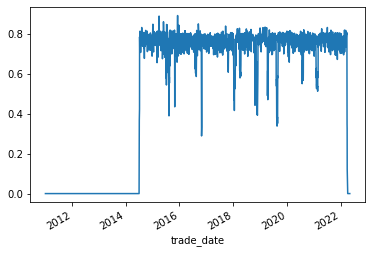

In [289]:
portfolio.alpha_sizing_df.sum(axis = 1).plot()

In [303]:
portfolio.alpha_sizing_df[portfolio.pnl_df.sum(axis = 0).sort_values().index[-2]].dropna()

trade_date
2015-09-30    0.100000
2015-10-08    0.107392
2015-10-09    0.110685
2015-10-12    0.121774
2015-10-13    0.133938
2015-10-14    0.141801
2015-10-15    0.147177
Name: (300013, 2015-09-29 00:00:00, 0.5762606591190798, 186602402.3793104), dtype: float64

In [317]:
trade_alpha500_return_df[trade_alpha500_return_df["suspend"]==1]

,ticker,publish_date,label_mean_val,num_visitors,mutual,broker,foreign,year,quarter,month,...,diver,con_rating_strength,con_rating_type,trade_date,suspend,st,return_post_10d,return_post_15d,return_post_20d,return_post_30d
2440,002683,2021-12-17,1.000000,1,True,True,False,2021,4,12,...,0.019100,0.800000,2.0,2021-12-20,1.0,NaN,-0.039436,-0.037545,-0.033836,0.019003
7413,688368,2021-06-30,0.625000,6,True,True,False,2021,2,6,...,0.158750,0.986800,1.0,2021-07-01,1.0,NaN,0.318580,0.470258,0.421543,0.432156
8532,000906,2021-05-20,0.545455,27,True,True,False,2021,2,5,...,0.036050,0.875000,2.0,2021-05-21,1.0,NaN,0.311932,0.343402,0.314400,0.224929
9976,000401,2021-03-18,NaN,3,True,True,False,2021,1,3,...,0.047400,0.916700,1.0,2021-03-19,1.0,NaN,-0.050971,-0.085503,-0.050946,-0.138371
10321,300737,2021-03-03,0.571429,21,True,True,False,2021,1,3,...,0.082650,0.977900,1.0,2021-03-04,1.0,NaN,-0.053209,0.018932,-0.045619,0.226923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62651,000338,2013-06-26,0.833333,1,False,False,False,2013,2,6,...,0.050622,0.875000,1.0,2013-06-27,1.0,NaN,-0.015007,-0.050575,-0.090985,-0.009006
62898,002505,2013-06-13,NaN,1,True,False,False,2013,2,6,...,0.529266,0.666667,2.0,2013-06-14,1.0,NaN,0.078265,0.355949,0.397419,0.419005
64240,002424,2013-03-20,0.500000,2,True,False,False,2013,1,3,...,0.032878,1.000000,2.0,2013-03-21,1.0,NaN,0.077253,0.067097,0.091177,0.087006
64794,002293,2013-01-24,0.066667,2,True,True,False,2013,1,1,...,0.075172,0.803191,1.0,2013-01-25,1.0,NaN,-0.001239,-0.016316,0.053951,-0.113696


In [318]:
return_df.loc[pd.Timestamp(2021,12,18):,"002683"][:20]

trade_date
2021-12-20    0.000000
2021-12-21    0.000000
2021-12-22    0.000000
2021-12-23    0.000000
2021-12-24    0.000000
2021-12-27    0.000000
2021-12-28    0.000000
2021-12-29    0.000000
2021-12-30    0.000000
2021-12-31    0.000000
2022-01-04   -0.006640
2022-01-05   -0.028743
2022-01-06   -0.030282
2022-01-07    0.034776
2022-01-10   -0.018861
2022-01-11    0.019923
2022-01-12   -0.003427
2022-01-13   -0.007909
2022-01-14   -0.009012
2022-01-17    0.020986
Name: 002683, dtype: float64

In [296]:
portfolio.pnl_df.columns[0]

('000004',
 Timestamp('2016-11-18 00:00:00'),
 0.5960041611967994,
 137911920.24551722)

In [ ]:
portfolio_pre_cost = PortfolioStrategy(return_df, signal_df)
portfolio_pre_cost.get_pnl_curve(0.05, 15, 1, True, "prob_weighted", return_index_df["000905"], 1, 0.8, 0.00, 
                        "quarter_prob_weighted_hedged100_without_cost")

In [ ]:
portfolio_pre_cost.pnl_df.sum(axis = 1)[portfolio_pre_cost.pnl_df.sum(axis = 1)!=0].mean() * 252

In [ ]:
portfolio_pre_cost.pnl_df.sum(axis = 1)[portfolio_pre_cost.pnl_df.sum(axis = 1)!=0].std() * (252**0.5)

In [ ]:
portfolio_50 = PortfolioStrategy(return_df, signal_df)
portfolio_50.get_pnl_curve(0.05, 15, 1, True, "prob_weighted", return_index_df["000905"], 0.5, 0.8, 0.002,
                        "quarter_prob_weighted_hedged50_with_cost")

In [ ]:
portfolio_50.pnl_df.sum(axis = 1)[portfolio_50.pnl_df.sum(axis = 1)!=0].mean() * 252

In [ ]:
portfolio_50.pnl_df.sum(axis = 1)[portfolio_50.pnl_df.sum(axis = 1)!=0].std() * (252**0.5)

In [ ]:
portfolio_abs = PortfolioStrategy(return_df, signal_df)
portfolio_abs.get_pnl_curve(0.05, 15, 1, True, "prob_weighted", return_index_df["000905"], 0, 1, 0.002,
                        "quarter_prob_weighted_hedged0_with_cost")

In [ ]:
portfolio_abs.pnl_df.sum(axis = 1)[portfolio_abs.pnl_df.sum(axis = 1)!=0].mean() * 252

In [ ]:
portfolio_abs.pnl_df.sum(axis = 1)[portfolio_abs.pnl_df.sum(axis = 1)!=0].std() * (252**0.5)

 to do list
- dividend adjustment, ST, limit up and limit down
- what happens if that day is not trade date - don't worry about if as the strategy predates on rolling for one more day
- liquidity adjustment
- risk parity
- add nlp metrics and other nlp measure
- drawdown and return and risk metrics
- write better functions to allow for equal risk and equal size

In [ ]:
trade_alpha300_return_df_large[trade_alpha300_return_df_large["suspend"]==1]

In [ ]:
trade_alpha_return_df["suspend"].dropna()

In [ ]:
ab = pd.read_csv("2022_05_05_jm_data.csv")

In [ ]:
ab.sort_values("stime").iloc[:-150,]

In [ ]:
ab["stime"].sort_values().unique()